In [1269]:
# -*- coding: utf-8 -*-
"""
Model for analysing the effects of coincident peak vs AoB charges

Created on Sun Dec 16 14:46:14 2018

The overall model has 3 components: 
(1) Demand 
(2) Demand-side investment in DG
(3) Supply-side investment in grid-connected generation

This version only looks at allocative efficiency effects (demand with no investment response)

(1) Demand is differentiated by:
(a) type {Mass,DirectConnect}
(b) time of use {Peak,Shoulder,OffPeak,Low}   
(c) region {Backbone node...}
(d) connection (DG, Grid)

"""
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt

In [1270]:
path='/media/usb/notebooks/Doug/'
#db = DB(profile="hallj") 

In [1386]:
#A. DATA import and export
data=pd.read_csv(path+"Data/model_data_bb.csv")
data_gen=pd.read_csv(path+"Data/model_data_bb_gen.csv")
coef_m=pd.read_csv(path+"Data/tou_coef_mass.csv")
coef_i=pd.read_csv(path+"Data/tou_coef_ind.csv")

reg_pop_params=pd.read_csv(path+"Data/reg_pop.csv")#no variable defns for data in this dataframe

reg_inc_params=pd.read_csv(path+"Data/reg_inc.csv")#no variable defns for data in this dataframe

tp_rev=pd.read_csv(path+"Data/forecast_revenue.csv")

exist_s = pd.read_csv(path+"Data/aob_existing_asset_benefit_shares_2022_equal.csv")#no variable defns for data in this dataframe
exist_g=pd.read_csv(path+"Data/existing_gen.csv")
poss_g=pd.read_csv(path+"Data/possible_gen.csv")
major = pd.read_csv(path+"Data/major_capex.csv")
initial_aob = pd.read_csv(path+"Data/Initial_AoB.csv")
data.head()

bb  type  p_yr  m_yr      pk_s      dg_s      sh_s     off_s        pk_p  \
0  MDN     1  2010  2008  0.233045  0.012877  0.229934  0.524144  329.388268   
1  MDN     1  2011  2009  0.342330  0.023511  0.216721  0.417438  241.814622   
2  MDN     1  2012  2010  0.246905  0.022182  0.207982  0.522932  223.576552   
3  MDN     1  2013  2011  0.244829  0.021192  0.236435  0.497544  200.192769   
4  MDN     1  2014  2012  0.204420  0.019323  0.220055  0.556201  233.224559   

         dg_p   ...     sh_theta  off_theta       pk_pr  dg_pr  sh_pr  off_pr  \
0  228.193293   ...          1.0        1.0  102.040969      0      0       0   
1  143.721361   ...          1.0        1.0  103.018564      0      0       0   
2  119.284856   ...          1.0        1.0  103.891211      0      0       0   
3  104.327737   ...          1.0        1.0  103.699741      0      0       0   
4  135.009161   ...          1.0        1.0  108.014962      0      0       0   

        pk_rev  dg_rev  sh_rev  off_rev  
0  14702371.94       0       0        0  
1  14460397.68       0       0        0  
2  14016131.77       0       0        0  
3  14291101.08       0       0        0  
4  15003145.65       0       0        0  

[5 rows x 82 columns]

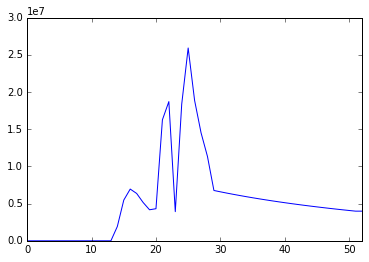

In [892]:
major.major_capex.plot()

# B. PARAMETERS

In [1119]:
#   B.1 Number of trading periods
pk_tp = 1600 
sh_tp = 3075
off_tp = 12845
mwh=np.array([pk_tp/2,sh_tp/2,off_tp/2])

In [1120]:
#   B.2 Base period values - that do not change
yr_0 = 2017 #capacity measurement year ended August 2017
base_year = 2010

In [1121]:
#   B.3 Mass market Time of Use (TOU) elasticity/LAAIDS parameters - from data
gamma=np.column_stack(np.array(coef_m[coef_m['type']=='gamma']['coef']))
gamma = np.transpose(np.reshape(gamma,(4,4)))
beta=np.column_stack(np.array(coef_m[coef_m['type']=='beta']['coef']))
beta=np.transpose(np.matrix(beta))
dg_c = np.column_stack(np.array(coef_m[coef_m['type']=='dg']['coef']))

In [1122]:
gamma

array([[ 0.152,  0.009, -0.038, -0.123],
       [ 0.009,  0.01 , -0.018, -0.001],
       [-0.038, -0.018,  0.155, -0.099],
       [-0.123, -0.001, -0.099,  0.224]])

In [1123]:
#   B.4 Large industrials TOU elasticity/LAAIDS parameters - from data
gamma_i=np.column_stack(np.array(coef_i[coef_i['type']=='gamma']['coef']))
gamma_i = np.transpose(np.reshape(gamma_i,(4,4)))
beta_i=np.column_stack(np.array(coef_i[coef_i['type']=='beta']['coef']))
beta_i=np.transpose(np.matrix(beta_i))
dg_c_i = np.column_stack(np.array(coef_i[coef_i['type']=='dg']['coef']))

In [1124]:
#   B.5 Market aggregate price and demand parameters (non TOU)
p_e = -0.11 #Aggregate mass market price (per ICP) elasticity
m_e = 0.11 #Aggregate mass market income (per ICP) elasticity
p_e_i = -0.02 #Aggregate industrial price (per ICP) elasticity
VOLL = 1000 #Value of lost load for calculating consumer surplus
disc = 0.08 #Discount rate
p_disc = 1/((1+disc)**(19/12)) #Discounting expected interconnection charges

In [1125]:
#   B.6 Dimensions 
share_n=4
ones=np.matrix(np.ones((1,share_n)))
T=33 #Projections time period
yr_l=list(range(yr_0,yr_0+T)) #Years for projections
reg_l=["MDN","OTA","HLY","TRK","WKM","RDF","SFD",
      "BPE","HAY","KIK","ISL","BEN","ROX","TWI"] # Backbone nodes in model
ind_l=["OTA","HLY","TRK","RDF","SFD","BPE","ISL","TWI"] #Nodes with large industrial or direct connect demands
gen_l=["HLY","TRK","WKM","RDF","SFD",
      "BPE","HAY","KIK","ISL","BEN","ROX","TWI"]  #Nodes with grid connected generation (excludes Otahuhu gen now closed)
si_nodes=["KIK","ISL","BEN","ROX","TWI"]     
ni_nodes=["MDN","OTA","HLY","TRK","WKM","RDF","SFD",
      "BPE","HAY"] 
ctype_l=[1,2] #Consumer types, 1= Mass market, 2=Large industrial or direct connect demand

In [47]:
#   B.7 Initial demand growth parameters, need to add
"""
Need to add (a) node-specific values, (b) shifters for scenarios for
electrification or reductions in growth (c) shifters for one off shocks (Tiwai) 
"""
nz_m_g_mu = 1.01 #Mean income growth rate (1+g), labour market earnings per ICP
nz_m_g_sd = 0.005 #Std deviation of income growth rate (1+g), earnings per ICP
icp_g_mu = 1.01 #Mean ICP growth rate (1+g)
icp_g_sd = 0.005 #Std deviation of ICP growth rate

pot4_mw = 50 #Adding Tiwai fourth potline from 2019 to 2022
pot4_on = 2018 # year after which potline turns on
pot4_off = 2022 # year after which potline turns off
pot4 = np.array([(pk_tp/2)*pot4_mw,0,(sh_tp/2)*pot4_mw,(off_tp/2)*pot4_mw])

In [48]:
pot4

array([ 40000.,      0.,  76875., 321125.])

In [161]:
#   B.8 Initial generation cost parameters
#       (a) Parameters
#pg_mu = [89.0,89.0,72.5,58.0] #Mean and standard deviation of generation prices
#pg_sd = [38.0,38.0,27.0,21.0] # 2008 prices
pg_mu = [115.3,115.3,91.6,72.8] #2018 dollars: Mean and standard deviation of generation prices
pg_sd = [49.6,49.6,34.1,28.0]
#       (b) Function for generating new generation prices from a 
#       log normal distribution Note ideally this would be 
#       mutivariate with a covariance matrix, but for simplicity 
#       we assume the values are perfectly correlated (i.e. same random seed)

def rand_pg(mu=pg_mu,sd=pg_sd,n=1):
    cases=len(mu) 
    out=np.zeros((n,cases))
    rnd_num=random.randint(0,10000) #Set a random seed number to ensure values similar (simpler than multivariate)
    for i in range(cases):
        loc=np.log(mu[i]**2/np.sqrt(sd[i]**2+mu[i]**2))
        scale=np.sqrt(np.log(1+(sd[i]**2/mu[i]**2)))
        np.random.seed(rnd_num)
        rnd=np.random.lognormal(loc,scale,n)
        out[:,i]=rnd
    return out   

#       (c) Function for generating the expected value of generation costs, 
#given a weighed average and std deviation       
def ln_exp(mu=pg_mu,sd=pg_sd,n=1):
        cases=len(mu) 
        out=np.zeros((n,cases))
        for i in range(cases):
            loc=np.log(mu[i]**2/np.sqrt(sd[i]**2+mu[i]**2))
            scale=np.sqrt(np.log(1+(sd[i]**2/mu[i]**2)))
            out[:,i] = np.exp(loc+0.5*scale)
        return out

#       (d) Assumed cost of DG (sensitivity will add a random draw to test different price levels)
#           and supply elasticity (percentage change in DG if price breached)        
dg_lrmc_mu=250 # lrmc - capital and fixed O&M only, based on network batteries, with input/'fuel' cost calculated in the model
dg_capex = 733000
dg_fixed = 67000
hybrid_arbitrage_discount = 0.225 # To discount arbitrage outside peak demand months
max_dg = 2 # Maximum MW dg/batteries capacity to total peak demand, 2 = 50% of peak met by batteries
dg_mwh = 3225
dg_lrmc_g = 0.93 #Assume a 7% cost reduction
dg_ds = 0.5 #Supply elasticity - implies 1% cost advantage increases DG by 1% but is also decreasing function of pk_mw/(dg_mw+pk_mw)
dg_horizon = 15 #Years factored into the DG investment decision

In [311]:
mu=115.3
sd=49.6
n=1


# This is in the code now
# loc=np.log(mu**2/np.sqrt(sd**2+mu**2))
# scale=np.sqrt(np.log(1+(sd**2/mu**2)))


#this is corrected
loc=np.log(mu**2/np.sqrt(sd+mu**2))
scale=np.sqrt(np.log(1+(sd/mu**2)))


print(loc)
print(scale)
print(np.random.lognormal(mu,sd,n))
print(np.random.lognormal(loc,scale,n))


4.745675408093123
0.06102489953928338
[1.20761355e+48]
[104.29596548]


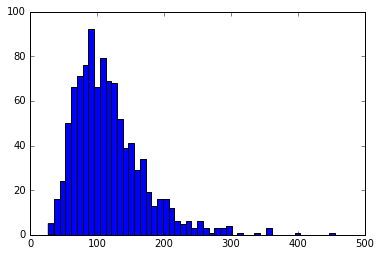

In [1558]:
mu=115.3
sd=49.6
n=1


# This is in the code now
loc=np.log(mu**2/np.sqrt(sd**2+mu**2))
scale=np.sqrt(np.log(1+(sd**2/mu**2)))


#this is corrected
# loc=np.log(mu**2/np.sqrt(sd+mu**2))
# scale=np.sqrt(np.log(1+(sd/mu**2)))

s = np.random.lognormal(loc, scale, 1000)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 50,cumulative=False, align='mid')




In [362]:
s.mean()

114.87814196803892

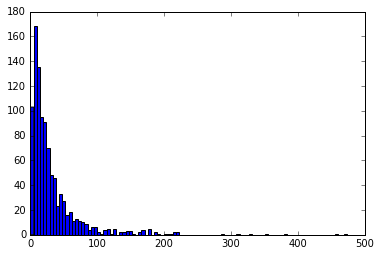

In [309]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 100,cumulative=False, align='mid')

x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

# plt.plot(x, pdf, linewidth=2, color='r')
# plt.axis('tight')
# plt.show()

In [174]:
#   B.9 AOB parameters
r_s = 0.695 #Share of DC + AC IC revenue not recovered via AoB [file aob_existing has the info on IC and DC allocations]
aob_yr=2022 #Year implemented - for measurement purposes(i.e. m_yr) 
aob_tp=[pk_tp,pk_tp,sh_tp,off_tp]

In [169]:
#   B.10 Transpower revenue parameters 
roi=0.06 # A constant return on investment
opex_r=0.06 # An opex allowance - as a share of RAB
deprn=0.05 # Constant average depreciation
gror = roi+opex_r+deprn #Gross rate of return [missing tax?]
ic_s = [1.0,0.0,0.0,0.0] #Share of trading periods to which RCPD applies, by TOU categories - note assumption that average peak price is what matters
ic_s_mwh = [1.0,0.0,1.0,1.0] #Values for application of RCPD to MWh - not applied to DG 

In [79]:
data.head(10)

bb  type  p_yr  m_yr      pk_s      dg_s      sh_s     off_s        pk_p  \
0  MDN     1  2010  2008  0.233045  0.012877  0.229934  0.524144  329.388268   
1  MDN     1  2011  2009  0.342330  0.023511  0.216721  0.417438  241.814622   
2  MDN     1  2012  2010  0.246905  0.022182  0.207982  0.522932  223.576552   
3  MDN     1  2013  2011  0.244829  0.021192  0.236435  0.497544  200.192769   
4  MDN     1  2014  2012  0.204420  0.019323  0.220055  0.556201  233.224559   
5  MDN     1  2015  2013  0.223055  0.016960  0.215613  0.544373  219.210132   
6  MDN     1  2016  2014  0.250691  0.018841  0.205249  0.525219  233.080919   
7  MDN     1  2017  2015  0.237338  0.014619  0.188878  0.559165  225.819836   
8  MDN     1  2018  2016  0.260092  0.019825  0.177982  0.542101  230.384014   
9  MDN     1  2019  2017  0.308484  0.027642  0.202029  0.461845  272.800330   

         dg_p   ...     sh_theta  off_theta       pk_pr  dg_pr  sh_pr  off_pr  \
0  228.193293   ...          1.0        1.0  102.040969      0      0       0   
1  143.721361   ...          1.0        1.0  103.018564      0      0       0   
2  119.284856   ...          1.0        1.0  103.891211      0      0       0   
3  104.327737   ...          1.0        1.0  103.699741      0      0       0   
4  135.009161   ...          1.0        1.0  108.014962      0      0       0   
5   98.956611   ...          1.0        1.0  124.871152      0      0       0   
6  106.815616   ...          1.0        1.0  138.773448      0      0       0   
7   84.556454   ...          1.0        1.0  147.003834      0      0       0   
8   98.191994   ...          1.0        1.0  155.417791      0      0       0   
9  142.986996   ...          1.0        1.0  150.642525      0      0       0   

        pk_rev  dg_rev  sh_rev  off_rev  
0  14702371.94       0       0        0  
1  14460397.68       0       0        0  
2  14016131.77       0       0        0  
3  14291101.08       0       0        0  
4  15003145.65       0       0        0  
5  17044472.77       0       0        0  
6  19192288.28       0       0        0  
7  20373836.16       0       0        0  
8  22036337.84       0       0        0  
9  22082968.22       0       0        0  

[10 rows x 82 columns]

In [149]:
year=2015
rcpd_n=ic_s
q_tou=data.loc[(data['m_yr']==year+1),['pk_q','dg_q','sh_q','off_q']]
Q_tou=np.array(q_tou.sum())
Q_ic_tou=np.multiply(Q_tou,rcpd_n)
Q_ic = np.sum(Q_ic_tou) 
ic_p_update=np.multiply(np.divide(ac_ic,Q_ic),rcpd_n)
px1=np.array(data.loc[(data['m_yr']==year+1),['pk_px','dg_px','sh_px','off_px']])
p_update = np.add(px1,ic_p_update)
print(ac_ic)
# print(rcpd_n)
# print(q_tou)
print(Q_tou)
# print(Q_ic_tou)
# print(Q_ic)
# print(ic_p_update)
# print(ic_p_update)
print(ac_ic/Q_ic)
# print(px1)
# print(p_update)

data.loc[(data['m_yr']==year+1),['pk_i','dg_i','sh_i','off_i']]=ic_p_update
data.loc[(data['m_yr']==year+1),['pk_p','dg_p','sh_p','off_p']]=p_update

#print(data.loc[(data['m_yr']==year+1),['pk_i','dg_i','sh_i','off_i']])
#print(data.loc[(data['m_yr']==year+1),['pk_p','dg_p','sh_p','off_p']])


#data.loc[(data['m_yr']==year+1)]

717127090.5
[ 4544238.781   372593.37   8584774.075 27529342.259]
157.810169108717


In [834]:
ic_s

[1.0, 0.0, 0.0, 0.0]

In [17]:
# Function for updating RCPD interconnection/transmission charges - 
# from expectations to "actuals" based on consumption (price component is forward looking)


# have checked this function. It takes the interconnect revenue for a particular year, divides it by peak MWH
# this gives a $/MWh for interconnect charges. This is allocated to all regions evenly (). it allocates to peak prices
# it doesn't affect prices at other times. 
# The main dataframe is updated for that particular year. 
# It is not clear to me why the code generates only one price per year for all nodes. Maybe because this is RCPD
# and this is the postage stamp. However, ic_p_update only has one price in it and the dataframe it is updateing
# has a price for each bb node which is presumably calculated using historic data. So this doesn't make sense to me. 
#Doug



def rcpd_ic_update(data, year, tp_rev=tp_rev, rcpd_n=ic_s):
    ac_ic = np.asscalar(
        tp_rev.loc[(tp_rev['m_yr'] == year +
                    2), ['ac_ic']].values)  # Interconnection charge
    q_tou = data.loc[(data['m_yr'] == year + 1),
                     ['pk_q', 'dg_q', 'sh_q',
                      'off_q']]  # Market TOU quantities
    Q_tou = np.array(q_tou.sum())  #Aggregate market quantities by TOU
    Q_ic_tou = np.multiply(
        Q_tou,
        rcpd_n)  #Adjust for shares of charges by TOU - default peak only
    Q_ic = np.sum(Q_ic_tou)
    ic_p_update = np.multiply(np.divide(ac_ic, Q_ic), rcpd_n)
    #Get grid price - ex IC
    px1 = np.array(data.loc[(data['m_yr'] == year +
                             1), ['pk_px', 'dg_px', 'sh_px', 'off_px']])
    #Add new IC price into the calculations
    p_update = np.add(px1, ic_p_update)
    #Add new prices back into dataframe
    data.loc[(data['m_yr'] == year +
              1), ['pk_i', 'dg_i', 'sh_i', 'off_i']] = ic_p_update
    data.loc[(data['m_yr'] == year +
              1), ['pk_p', 'dg_p', 'sh_p', 'off_p']] = p_update
    return data

In [867]:
c_ic = np.asscalar(
    tp_rev.loc[(tp_rev['m_yr'] == year +
                2), ['ac_ic']].values)  # Interconnection charge
q_tou = data.loc[(data['m_yr'] == year + 1),
                 ['pk_q', 'dg_q', 'sh_q',
                  'off_q']]  # Market TOU quantities
Q_tou = np.array(q_tou.sum())  #Aggregate market quantities by TOU
Q_ic_tou = np.multiply(
    Q_tou,
    rcpd_n)  #Adjust for shares of charges by TOU - default peak only
Q_ic = np.sum(Q_ic_tou)
ic_p_update = np.multiply(np.divide(ac_ic, Q_ic), rcpd_n)
#Get grid price - ex IC
px1 = np.array(data.loc[(data['m_yr'] == year +
                         1), ['pk_px', 'dg_px', 'sh_px', 'off_px']])
#Add new IC price into the calculations
p_update = np.add(px1, ic_p_update)
#Add new prices back into dataframe
data.loc[(data['m_yr'] == year +
          1), ['pk_i', 'dg_i', 'sh_i', 'off_i']] = ic_p_update
data.loc[(data['m_yr'] == year +
          1), ['pk_p', 'dg_p', 'sh_p', 'off_p']] = p_update

In [869]:
ic_p_update

array([158.48481608,   0.        ,   0.        ,   0.        ])

In [1306]:
ac_ic = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+2),['ac_ic']].values)
q_tou=data.loc[(data['m_yr']==year+1),['pk_q','dg_q','sh_q','off_q']]
Q_tou=np.array(q_tou.sum()) #Aggregate market quantities by TOU
Q_ic_tou=np.multiply(Q_tou,rcpd_n) #Adjust for shares of charges by TOU - default peak only
Q_ic = np.sum(Q_ic_tou) 
ic_pr_update=np.divide(ac_ic,Q_ic) 
px1 = np.array(data.loc[(data['m_yr'] == year +1), ['pk_px', 'dg_px', 'sh_px', 'off_px']])

print(ac_ic)
#print (q_tou)
print(ic_pr_update)
print(Q_tou)
print(Q_ic)
print(Q_ic_tou)
print(rcpd_n)

Q_ic

717127090.5
157.810169108717
[ 4544238.781   372593.37   8584774.075 27529342.259]
4544238.781
[4544238.781       0.          0.          0.   ]
[1.0, 0.0, 0.0, 0.0]


4544238.781

In [1297]:
data[['m_yr','bb','type','pk_i', 'dg_i', 'sh_i', 'off_i']]

m_yr   bb  type        pk_i  dg_i  sh_i  off_i
0    2008  MDN     1  101.194975     0     0      0
1    2009  MDN     1   98.093260     0     0      0
2    2010  MDN     1  104.291695     0     0      0
3    2011  MDN     1   95.865032     0     0      0
4    2012  MDN     1   98.215397     0     0      0
5    2013  MDN     1  120.253521     0     0      0
6    2014  MDN     1  126.265303     0     0      0
7    2015  MDN     1  141.263382     0     0      0
8    2016  MDN     1  132.192020     0     0      0
9    2017  MDN     1  129.813335     0     0      0
10   2008  OTA     1  111.064809     0     0      0
11   2009  OTA     1  106.258707     0     0      0
12   2010  OTA     1  106.224646     0     0      0
13   2011  OTA     1  102.657033     0     0      0
14   2012  OTA     1  106.820083     0     0      0
15   2013  OTA     1  140.407089     0     0      0
16   2014  OTA     1  135.947884     0     0      0
17   2015  OTA     1  155.825826     0     0      0
18   2016  OTA     1  150.069102     0     0      0
19   2017  OTA     1  139.225159     0     0      0
20   2008  OTA     2  103.228697     0     0      0
21   2009  OTA     2   91.460392     0     0      0
22   2010  OTA     2   63.773588     0     0      0
23   2011  OTA     2   76.465132     0     0      0
24   2012  OTA     2  102.549878     0     0      0
25   2013  OTA     2  114.589211     0     0      0
26   2014  OTA     2  126.720467     0     0      0
27   2015  OTA     2  131.065312     0     0      0
28   2016  OTA     2  114.602168     0     0      0
29   2017  OTA     2   79.403309     0     0      0
..    ...  ...   ...         ...   ...   ...    ...
190  2008  ROX     1   69.542530     0     0      0
191  2009  ROX     1   20.111431     0     0      0
192  2010  ROX     1   69.425340     0     0      0
193  2011  ROX     1   19.679018     0     0      0
194  2012  ROX     1  105.930142     0     0      0
195  2013  ROX     1  126.440195     0     0      0
196  2014  ROX     1   65.469811     0     0      0
197  2015  ROX     1  152.093769     0     0      0
198  2016  ROX     1  142.675860     0     0      0
199  2017  ROX     1  113.015860     0     0      0
200  2008  TWI     1   74.297970     0     0      0
201  2009  TWI     1   20.147345     0     0      0
202  2010  TWI     1   73.353425     0     0      0
203  2011  TWI     1   18.899842     0     0      0
204  2012  TWI     1   95.877739     0     0      0
205  2013  TWI     1  121.552137     0     0      0
206  2014  TWI     1   76.909135     0     0      0
207  2015  TWI     1  144.270086     0     0      0
208  2016  TWI     1  148.992544     0     0      0
209  2017  TWI     1  145.908164     0     0      0
210  2008  TWI     2   75.389457     0     0      0
211  2009  TWI     2   15.341432     0     0      0
212  2010  TWI     2   70.824874     0     0      0
213  2011  TWI     2   12.563837     0     0      0
214  2012  TWI     2   92.528342     0     0      0
215  2013  TWI     2  121.707549     0     0      0
216  2014  TWI     2   75.093803     0     0      0
217  2015  TWI     2  125.700249     0     0      0
218  2016  TWI     2  126.387411     0     0      0
219  2017  TWI     2  127.857634     0     0      0

[220 rows x 7 columns]

In [180]:
ac_ic/Q_tou[0]

157.810169108717

In [860]:
px1

array([[142.9869956 , 142.9869956 ,  87.51277281,  59.39836854],
       [137.5031164 , 137.5031164 ,  83.89976492,  58.78023563],
       [131.5892185 , 131.5892185 ,  82.86606681,  56.1929616 ],
       [130.0618036 , 130.0618036 ,  80.93394831,  57.64557627],
       [125.1394375 , 125.1394375 ,  79.59626545,  54.55442993],
       [124.4205488 , 124.4205488 ,  77.73455822,  55.27048365],
       [101.422641  , 101.422641  ,  72.85830361,  52.20686852],
       [122.7598795 , 122.7598795 ,  76.73200656,  54.51184247],
       [123.4674974 , 123.4674974 ,  77.41476046,  55.37969405],
       [110.0557931 , 110.0557931 ,  76.34046277,  53.04390556],
       [122.510615  , 122.510615  ,  76.05471361,  54.67065502],
       [115.8993122 , 115.8993122 ,  74.30357087,  53.26018971],
       [129.2963952 , 129.2963952 ,  79.56758099,  56.32897839],
       [117.2277506 , 117.2277506 ,  76.5202847 ,  53.49902842],
       [134.3600803 , 134.3600803 ,  81.44087612,  57.22816389],
       [151.4447833 , 151

In [853]:
p_update = np.add(px1, ic_p_update)
p_update

array([[300.79716471, 142.9869956 ,  87.51277281,  59.39836854],
       [295.31328551, 137.5031164 ,  83.89976492,  58.78023563],
       [289.39938761, 131.5892185 ,  82.86606681,  56.1929616 ],
       [287.87197271, 130.0618036 ,  80.93394831,  57.64557627],
       [282.94960661, 125.1394375 ,  79.59626545,  54.55442993],
       [282.23071791, 124.4205488 ,  77.73455822,  55.27048365],
       [259.23281011, 101.422641  ,  72.85830361,  52.20686852],
       [280.57004861, 122.7598795 ,  76.73200656,  54.51184247],
       [281.27766651, 123.4674974 ,  77.41476046,  55.37969405],
       [267.86596221, 110.0557931 ,  76.34046277,  53.04390556],
       [280.32078411, 122.510615  ,  76.05471361,  54.67065502],
       [273.70948131, 115.8993122 ,  74.30357087,  53.26018971],
       [287.10656431, 129.2963952 ,  79.56758099,  56.32897839],
       [275.03791971, 117.2277506 ,  76.5202847 ,  53.49902842],
       [292.17024941, 134.3600803 ,  81.44087612,  57.22816389],
       [309.25495241, 151

In [861]:
np.add(px1, ic_p_update)

array([[300.79716471, 142.9869956 ,  87.51277281,  59.39836854],
       [295.31328551, 137.5031164 ,  83.89976492,  58.78023563],
       [289.39938761, 131.5892185 ,  82.86606681,  56.1929616 ],
       [287.87197271, 130.0618036 ,  80.93394831,  57.64557627],
       [282.94960661, 125.1394375 ,  79.59626545,  54.55442993],
       [282.23071791, 124.4205488 ,  77.73455822,  55.27048365],
       [259.23281011, 101.422641  ,  72.85830361,  52.20686852],
       [280.57004861, 122.7598795 ,  76.73200656,  54.51184247],
       [281.27766651, 123.4674974 ,  77.41476046,  55.37969405],
       [267.86596221, 110.0557931 ,  76.34046277,  53.04390556],
       [280.32078411, 122.510615  ,  76.05471361,  54.67065502],
       [273.70948131, 115.8993122 ,  74.30357087,  53.26018971],
       [287.10656431, 129.2963952 ,  79.56758099,  56.32897839],
       [275.03791971, 117.2277506 ,  76.5202847 ,  53.49902842],
       [292.17024941, 134.3600803 ,  81.44087612,  57.22816389],
       [309.25495241, 151

In [862]:
ic_p_update

array([157.81016911,   0.        ,   0.        ,   0.        ])

In [18]:
# Function for updating RCPD revenue per MWh collected by Transpower in each measurement year
# this takes the amount of real revenue to be collected in the year, from forecast/actual revenue
# gets peak demand from the prior year and calculates prices  

# Only difference from above function is the year which q_tou is calculated, year instead of year+1. 
# Otherwise it is the same. It also does not update the main data frame, it just returns the per MWh
# price for interconnection. 

def rcpd_rev_update(data,year,tp_rev=tp_rev,ic_s=ic_s,rcpd_n=ic_s):
    ac_ic = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+1),['ac_ic']].values) # Interconnection charge   
    q_tou=data.loc[(data['m_yr']==year),['pk_q','dg_q','sh_q','off_q']] # Market TOU quantities
    Q_tou=np.array(q_tou.sum()) #Aggregate market quantities by TOU
    Q_ic_tou=np.multiply(Q_tou,rcpd_n) #Adjust for shares of charges by TOU - default peak only
    Q_ic = np.sum(Q_ic_tou) 
    ic_pr_update=np.divide(ac_ic,Q_ic) #New price
    return ic_pr_update  

In [871]:
ac_ic = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+1),['ac_ic']].values) # Interconnection charge   
q_tou=data.loc[(data['m_yr']==year),['pk_q','dg_q','sh_q','off_q']] # Market TOU quantities
Q_tou=np.array(q_tou.sum()) #Aggregate market quantities by TOU
Q_ic_tou=np.multiply(Q_tou,rcpd_n) #Adjust for shares of charges by TOU - default peak only
Q_ic = np.sum(Q_ic_tou) 
ic_pr_update=np.divide(ac_ic,Q_ic) #New price

In [872]:
ic_pr_update

157.810169108717

In [878]:
#tp_rev[['m_yr' , 'ac_ic']]


# D. PROPOSAL PARAMETERS incl forecast revenue and shares of existing assets

In [1391]:
#   D.1 Residual revenue,  calculated from a given year of AOB implementation

# The first line takes total TP revenue for a year and multiplies it by a parameter r_s
# r_s is the share of TP rev not recovered by AoB





tp_rev["resid_rev"] = 0 # Initialise residual revenue series, then get intial value:
rev0=np.asscalar(tp_rev.loc[(tp_rev['m_yr']==aob_yr),['totrev']].values)*r_s
unallocated = 160000000
#       Revenue calculated as a function of gror and depreciation                      
tp_rev.loc[(tp_rev['m_yr']>=aob_yr),['resid_rev']]=unallocated + np.array(
    [gror*(((rev0-unallocated)/gror)*(1-deprn)**i) 
                    for i in range(tp_rev['m_yr'].max()-(aob_yr-1))])

In [1392]:
#tp_rev.loc[(tp_rev['m_yr']>=aob_yr),['resid_rev']]

In [1393]:
rev0/r_s

715870458.8

In [1394]:
r_s

0.695

In [1395]:
aob_yr

2022

In [1396]:
tp_rev[(tp_rev['m_yr']==2022)]

p_yr  m_yr         ac_ic        dc_ic      ic_g     dc_g       totrev  \
14  2024  2022  6.234522e+08  96271373.37  0.993464  0.97127  715870458.8   

    totrev_g   base_capex  major_capex     resid_rev  
14   0.99042  21215572.84  1926548.132  4.975300e+08

In [1397]:
#   D.2 AOB revenue - pre approvals or major capex                        
tp_rev["aob_rev"]=tp_rev["totrev"]-tp_rev['resid_rev']
tp_rev.loc[(tp_rev['m_yr']<aob_yr),['aob_rev']]=0

In [1398]:
#   D.3 Calculate a base capex and approved investment series for AOB - based on revenue and fixed ROR
tp_rev["base_capex"]=0
for i in range(1,len(tp_rev)):
    tp_rev.loc[i, 'base_capex'] = (tp_rev.loc[i, 'totrev']-unallocated) - (((tp_rev.loc[i-1, 'totrev']-unallocated)/gror)*(1-deprn))*gror
tp_rev["major_capex"]=0

# Add unapproved capex - listed and major
tp_rev.major_capex=major.major_capex
tp_rev.ac_ic = tp_rev.ac_ic+major.ac_ic
tp_rev.dc_ic = tp_rev.dc_ic+major.dc_ic
tp_rev.aob_rev=tp_rev.aob_rev+major.totrev
tp_rev.totrev = tp_rev.totrev+major.totrev
tp_rev[['ic_g','dc_g','totrev_g']] = tp_rev[['ac_ic','dc_ic','totrev']].pct_change()+1.0

In [1399]:

year=2010
reg="OTA"
ctype=1

a=data.loc[(data['m_yr']==year)&(data['bb']==reg)&
           (data['type']==ctype),['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
a['lce'] = (
    a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+
    (1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
    a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+
    (1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
    a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+
    (1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))


In [1136]:
a.head()

pk_q         sh_q        off_q  pk_s_pt_mu  sh_s_pt_mu  \
12  1194459.817  2022159.978  5723124.948    1.111301    1.121337   

    off_s_pt_mu  pk_ns_pt_mu  sh_ns_pt_mu  off_ns_pt_mu      pk_pg      sh_pg  \
12     1.090349     1.067274     1.081621        0.8506  91.110773  75.595875   

       off_pg  pk_theta  sh_theta  off_theta           lce  
12  64.103242       1.0       1.0   0.999969  6.380470e+07

In [1137]:
a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)

#price difference times Q times prob-so this is LCE for peak periods where there is scarcity. the rest of the
#function is just the converses, three TP types times scarce, not scarce. 

12    1.211273e+07
dtype: float64

In [1138]:
a.loc[(a['lce']>0),['lce']]=0

In [1139]:
a.pk_s_pt_mu-1

12    0.111301
Name: pk_s_pt_mu, dtype: float64

In [1377]:
##  D.4 Calculate AOB initial charges/shares (for load) 
#       based on exist_s e.g. exist_ls (load share of benefits of existing assets)
#       from the 2nd issues paper (not board paper cause those numbers not by location) 
#       Needs to be split between industrials and mass, which we do by LCE shares

#       (i) First find average benefits at stake for each type in each node - i.e. LCE
#           [Creating later functions that calculate lce by choice of all periods]
#lce_hist = data.loc[:,['bb','type','m_yr','pk_q','sh_q','off_q','pk_pt','sh_pt','off_pt']]
#lce_hist['lce']=lce_hist.pk_q*lce_hist.pk_pt+lce_hist.sh_q*lce_hist.sh_pt+lce_hist.off_q*lce_hist.off_pt
#lce_hist.loc[(lce_hist['lce']<0),['lce']]=0 #Get rid of net negative benefits in a year
#lce_node_hist = lce_hist.groupby(['bb', 'type']).agg({'lce': 'sum'})
#lce_shares = lce_node_hist.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()
#
##       (ii) Then multiply LCE shares by shares of existing assets
#aob_s0=pd.merge(lce_shares,exist_s,on='bb',how='left')
#aob_s0['aob_s0']=aob_s0['lce']*aob_s0['exist_ls']
#aob_s0['bbtype']=aob_s0['bb']+aob_s0.type.map(str)
#aob_s0['aob_rev0']=np.asscalar(tp_rev.loc[(tp_rev['m_yr']==aob_yr),['aob_rev']].values)
#aob_s0['aob_rev0']=aob_s0['aob_rev0']*aob_s0['aob_s0']
#
##       (iii) Generation values
#exist_s['type']=0
#exist_s['bbtype']=exist_s['bb']+exist_s.type.map(str)
#exist_s['aob_rev0']=np.asscalar(tp_rev.loc[(tp_rev['m_yr']==aob_yr),['aob_rev']].values)
#exist_s['aob_rev0_gen']=exist_s['aob_rev0']*exist_s['exist_gs']
#
#gen_aob_shr = exist_s.exist_gs.sum() # For allocations of AOB revenue in the demand model - if want a fixed amount
gen_aob_adj = 0.3333 #Assume area under generation offer curve that is 0.5 

#       (iv) Create a generic trasnport/lce cost function (returns costs as a positive number)
def lce(data=data,reg="OTA",year=yr_0,ctype=1):
        a = data.loc[(data['m_yr']==year)&(data['bb']==reg)&
           (data['type']==ctype),['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
        a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
                    a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
                    a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
        if ctype==0:
            a.loc[(a['lce']>0),['lce']]=0
            b = a.lce.sum()*(-1*gen_aob_adj)
        else:
            a.loc[(a['lce']<0),['lce']]=0
            b = a.lce.sum()
        return b


#lce(data=data_gen,reg="SFD",year=2010,ctype=0)        

#       (v) Lce share function - for load


#not used

def lceshr_load(data=data,reg="OTA",yr=yr_0,ctype=1):   
        a = data.loc[data['m_yr']==yr,['pk_q','sh_q','off_q','pk_pt','sh_pt','off_pt']]
        a['lce'] = a.pk_q*a.pk_pt+a.sh_q*a.sh_pt+a.off_q*a.off_pt
        a.loc[(a['lce']<0),['lce']]=0
        b = a.lce.sum()
        c=lce(data,reg=reg,yr=yr,ctype=ctype)
        c[c<0]=0 #Only count positive benefits when calculating shares
        d = np.asscalar(c/b)
        return d


#       (v) Lce benefit function 
def lceshr(data=data,data_gen=data_gen,reg="OTA",year=yr_0,ctype=1):
    #All load
        a = data.loc[data['m_yr']==year,['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
        a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
                    a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
                    a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
        a.loc[(a['lce']<0),['lce']]=0
        b = a.lce.sum()
    #All Generation        
        c = data_gen.loc[data_gen['m_yr']==year,['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]#generation
        c['lce'] = (c.pk_theta*(c.pk_q*(c.pk_s_pt_mu-1)*c.pk_pg)+(1-c.pk_theta)*(c.pk_q*(c.pk_ns_pt_mu-1)*c.pk_pg)+ 
                    c.sh_theta*(c.sh_q*(c.sh_s_pt_mu-1)*c.sh_pg)+(1-c.sh_theta)*(c.sh_q*(c.sh_ns_pt_mu-1)*c.sh_pg)+
                    c.off_theta*(c.off_q*(c.off_s_pt_mu-1)*c.off_pg)+(1-c.off_theta)*(c.off_q*(c.off_ns_pt_mu-1)*c.off_pg))
        c['lce'] = c['lce']*(-1*gen_aob_adj) #Reverse sign and adjust value to account for area under offer curves  
        c.loc[(c['lce']<0),['lce']]=0
        d=c.lce.sum()
        e = d+b
   #Numerator        
        if ctype==0:
            f=lce(data_gen,reg=reg,year=year,ctype=ctype)
        else:
            f=lce(data,reg=reg,year=year,ctype=ctype)
        if f.size==0:
            g=0
        else:
            g = np.asscalar(f/e)
        return g

#for reg in reg_l:  
#    print(lceshr(data=df_aob,data_gen=gen_aob,reg=reg,year=2022,ctype=0))
#

In [ ]:
data=data
reg="OTA"
year=yr_0
ctype=1


a = data.loc[(data['m_yr']==year)&(data['bb']==reg)&
   (data['type']==ctype),['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
             'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]


a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
            a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
            a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
if ctype==0:
    a.loc[(a['lce']>0),['lce']]=0
    b = a.lce.sum()*(-1*gen_aob_adj)
else:
    a.loc[(a['lce']<0),['lce']]=0
    b = a.lce.sum()
return b

In [1321]:
#lce

data=data
reg="OTA"
year=2017
ctype=1

#gets some data
a = data.loc[(data['m_yr']==year)&(data['bb']==reg)&
   (data['type']==ctype),['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
             'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]

#Makes the LCE calc which is an over complicated way of saying (p_gen-p_load)*quant for 2 scarcity scenarios
# and three TP types. 
# in a loop it could do all nodes which is what is needed as AOB is allocated with LCE. 
# Returns a single number for a year a node and a customer type

a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
             a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
            a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))

# sets ctype 0 LCE to zero if it is positive, then sets b equal to the product of LCE which must be less than or
#equal to zero
#0 generation
if ctype==0:
    a.loc[(a['lce']>0),['lce']]=0
    b = a.lce.sum()*(-1*gen_aob_adj)

#sets ctype 1 LCE to zero if it is negative then sums
    
else:
    a.loc[(a['lce']<0),['lce']]=0
    b = a.lce.sum()

b

64603110.63079208

In [1320]:
a['lce']

19    6.460311e+07
Name: lce, dtype: float64

In [1410]:
def lce(data=data,reg="OTA",year=yr_0,ctype=1):
        a = data.loc[(data['m_yr']==year)&(data['bb']==reg)&
           (data['type']==ctype),['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
                     'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
        a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
                    a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
                    a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
        if ctype==0:
            a.loc[(a['lce']>0),['lce']]=0
            b = a.lce.sum()*(-1*gen_aob_adj)
        else:
            a.loc[(a['lce']<0),['lce']]=0
            b = a.lce.sum()
        return b

In [1559]:
data=data
reg="OTA"
year=yr_0
ctype=1

a = data.loc[(data['m_yr']==year)&(data['bb']==reg)&
   (data['type']==ctype),['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
             'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
            a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
            a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
if ctype==0:
    a.loc[(a['lce']>0),['lce']]=0
    b = a.lce.sum()*(-1*gen_aob_adj)
else:
    a.loc[(a['lce']<0),['lce']]=0
    b = a.lce.sum()
b

64603110.63079208

In [1560]:
a

pk_q         sh_q        off_q  pk_s_pt_mu  sh_s_pt_mu  \
19  1180527.262  1998874.563  5840465.686    1.111301    1.121337   

    off_s_pt_mu  pk_ns_pt_mu  sh_ns_pt_mu  off_ns_pt_mu       pk_pg  \
19     1.090349     1.067274     1.081621        0.8506  131.550025   

        sh_pg     off_pg  pk_theta  sh_theta  off_theta           lce  
19  77.526802  54.043133       1.0       1.0   0.999969  6.460311e+07

In [1383]:
#Not used lce_load


data=data
reg="OTA"
yr=2017
ctype=1  
       
    
a = data.loc[data['m_yr']==yr,['pk_q','sh_q','off_q','pk_pt','sh_pt','off_pt']]
a['lce'] = a.pk_q*a.pk_pt+a.sh_q*a.sh_pt+a.off_q*a.off_pt
a.loc[(a['lce']<0),['lce']]=0
b = a.lce.sum()
c=lce(data,reg=reg,year=2017,ctype=ctype)

#Not sure what happens here as lce returns just a number but this function is expecting a dataframe. 


c[c<0]=0 #Only count positive benefits when calculating shares
# d = np.asscalar(c/b)
# d 

TypeError: 'numpy.float64' object does not support item assignment

In [1382]:
c

64603110.63079208

In [1563]:
#XXXWriteIntoSpreadshee


#lceshr

gen_aob_adj = 0.3333
data=data
data_gen=data_gen
reg="OTA"
year=2012
ctype=1
    #All load
    
#gets a data frame using some data from data, all BB and both c types all TP types
a = data.loc[data['m_yr']==year,['bb','m_yr','type','pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
             'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]
#Calculates LCE for scarce and not scarce periods. 
# this is probability
# times quantity times price difference (calculated from the price ratio)
# all for each TP type
a['lce'] = (a.pk_theta*(a.pk_q*(a.pk_s_pt_mu-1)*a.pk_pg)+(1-a.pk_theta)*(a.pk_q*(a.pk_ns_pt_mu-1)*a.pk_pg)+ 
            a.sh_theta*(a.sh_q*(a.sh_s_pt_mu-1)*a.sh_pg)+(1-a.sh_theta)*(a.sh_q*(a.sh_ns_pt_mu-1)*a.sh_pg)+
            a.off_theta*(a.off_q*(a.off_s_pt_mu-1)*a.off_pg)+(1-a.off_theta)*(a.off_q*(a.off_ns_pt_mu-1)*a.off_pg))
#makes sure no negative LCE
a.loc[(a['lce']<0),['lce']]=0
#sums the LCE for the year and for all nodes/both types
b = a.lce.sum()
#     #All Generation    
#same calc as above from different data
c = data_gen.loc[data_gen['m_yr']==year,['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
             'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]#generation
c['lce'] = (c.pk_theta*(c.pk_q*(c.pk_s_pt_mu-1)*c.pk_pg)+(1-c.pk_theta)*(c.pk_q*(c.pk_ns_pt_mu-1)*c.pk_pg)+ 
            c.sh_theta*(c.sh_q*(c.sh_s_pt_mu-1)*c.sh_pg)+(1-c.sh_theta)*(c.sh_q*(c.sh_ns_pt_mu-1)*c.sh_pg)+
            c.off_theta*(c.off_q*(c.off_s_pt_mu-1)*c.off_pg)+(1-c.off_theta)*(c.off_q*(c.off_ns_pt_mu-1)*c.off_pg))

c['lce'] = c['lce']*(-1*gen_aob_adj) #Reverse sign and adjust value to account for area under offer curves  
#removes negative LCE
c.loc[(c['lce']<0),['lce']]=0
#sums it up
d=c.lce.sum()
#adds it up
e = d+b
   #Numerator   
#gets LCE for a node year and c type. uses different data for different C type...  
#not sure what the difference between the dataframes is... Thought c type
if ctype==0:
    f=lce(data_gen,reg=reg,year=year,ctype=ctype)
else:
    f=lce(data,reg=reg,year=year,ctype=ctype)

    
#Get rid of empty results    
if f.size==0:
    g=0
else:
    #calculate a ratio. 
    #e is all LCE and f is the node specific lce from the lce function...
    g = np.asscalar(f/e)
g

0.37008787687917494

In [1570]:
g

0.37008787687917494

In [1315]:
c = data_gen.loc[data_gen['m_yr']==year,['pk_q','sh_q','off_q','pk_s_pt_mu','sh_s_pt_mu','off_s_pt_mu',
             'pk_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu','pk_pg','sh_pg','off_pg','pk_theta','sh_theta','off_theta']]#generation
c['lce'] = (c.pk_theta*(c.pk_q*(c.pk_s_pt_mu-1)*c.pk_pg)+(1-c.pk_theta)*(c.pk_q*(c.pk_ns_pt_mu-1)*c.pk_pg)+ 
            c.sh_theta*(c.sh_q*(c.sh_s_pt_mu-1)*c.sh_pg)+(1-c.sh_theta)*(c.sh_q*(c.sh_ns_pt_mu-1)*c.sh_pg)+
            c.off_theta*(c.off_q*(c.off_s_pt_mu-1)*c.off_pg)+(1-c.off_theta)*(c.off_q*(c.off_ns_pt_mu-1)*c.off_pg))

c['lce'] = c['lce']*(-1*gen_aob_adj)
c.loc[(c['lce']<0),['lce']]=0
d=c.lce.sum()

In [1316]:
d

27255008.69479385

In [1207]:
data_gen.head()

bb  type  p_yr  m_yr      pk_s  dg_s      sh_s     off_s        pk_p  \
0  HLY     0  2010  2008  0.180993     0  0.229458  0.589549  227.286022   
1  HLY     0  2011  2009  0.265497     0  0.250811  0.483692  124.415054   
2  HLY     0  2012  2010  0.156696     0  0.229997  0.613307  101.997249   
3  HLY     0  2013  2011  0.165332     0  0.220481  0.614186   95.144030   
4  HLY     0  2014  2012  0.163924     0  0.238337  0.597739  119.442274   

         dg_p   ...     off_theta       srmc  pk_pr  dg_pr  sh_pr  off_pr  \
0  227.286022   ...      0.004359  73.172167    0.0    0.0    0.0     0.0   
1  124.415054   ...      0.004359  73.172167    0.0    0.0    0.0     0.0   
2  101.997249   ...      0.004359  73.172167    0.0    0.0    0.0     0.0   
3   95.144030   ...      0.004359  73.172167    0.0    0.0    0.0     0.0   
4  119.442274   ...      0.004359  73.172167    0.0    0.0    0.0     0.0   

   pk_rev  dg_rev  sh_rev  off_rev  
0     0.0     0.0     0.0      0.0  
1     0.0     0.0     0.0      0.0  
2     0.0     0.0     0.0      0.0  
3     0.0     0.0     0.0      0.0  
4     0.0     0.0     0.0      0.0  

[5 rows x 83 columns]

In [1101]:
tp_rev.head()

p_yr  m_yr        ac_ic         dc_ic      ic_g      dc_g       totrev  \
0  2010  2008          NaN           NaN       NaN       NaN          NaN   
1  2011  2009  492627703.1  1.008221e+08       NaN       NaN  593449775.7   
2  2012  2010  492881211.6  9.681609e+07  1.000515  0.960267  589697305.7   
3  2013  2011  500805092.2  1.150981e+08  1.016077  1.188833  615903233.1   
4  2014  2012  561302926.3  1.402350e+08  1.120801  1.218395  701537909.5   

   totrev_g  
0       NaN  
1       NaN  
2  0.993677  
3  1.044440  
4  1.139039

In [1484]:
#  D.4 Create an AoB account and a revenue account - for convenience
#       Columns that indicate node + type
cols=['p_yr','m_yr']+[s + str(1) for s in reg_l]+[s + str(2) for s in ind_l]+[s + str(0) for s in reg_l]

# AOB account
initial_aob['aob_rev0']=np.asscalar(tp_rev.loc[(tp_rev['m_yr']==aob_yr),['aob_rev']].values)*initial_aob.aob_s0    
cols=['p_yr','m_yr']+[s + str(1) for s in reg_l]+[s + str(2) for s in ind_l]+[s + str(0) for s in reg_l]
aob_accnt=pd.DataFrame(columns=cols)
aob_accnt['m_yr']=tp_rev['m_yr']
aob_accnt['p_yr']=tp_rev['p_yr']
aob_accnt=aob_accnt.fillna(0)
load_cols=[s + str(1) for s in reg_l]+[s + str(2) for s in ind_l]
gen_cols = [s + str(0) for s in reg_l]

for i in load_cols:
    #aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=aob_s0.loc[aob_s0['bbtype']==i,['aob_rev0']].values
    aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=initial_aob.loc[initial_aob['bbtype']==i,['aob_rev0']].values
for i in gen_cols:
    #aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=exist_s.loc[exist_s['bbtype']==i,['aob_rev0_gen']].values
    aob_accnt.loc[aob_accnt['m_yr']==aob_yr,[i]]=initial_aob.loc[initial_aob['bbtype']==i,['aob_rev0']].values

In [1634]:
#   D.5 Initialise an AMD function - allowing for periodic resets 
#   This allocation assumes industrial consumers pay based on Offtake (net) and 
#   mass market pay for load (gross)
def amdshr_f(data=data,window=5,gross=1):
    amd0=data.loc[:,['p_yr','m_yr','bb','type']]
    amd0['Load']=data.pk_q+data.dg_q
    amd0['Offtake']=data.loc[:,['pk_q']]
    amd0['Offtake']=data.loc[:,['pk_q']]
    amd0['AMDvol_t']=np.where(amd0['type']==1, amd0['Load'],amd0['Offtake'])
    amd0['AMDvol']=amd0.groupby(['bb','type']).AMDvol_t.apply(lambda x: x.rolling(window=window).sum()).values
    amd0['AMDvol_tot'] = amd0['AMDvol'].groupby(amd0['m_yr']).transform('sum')
    amd0['AMDshr']=amd0.AMDvol/amd0.AMDvol_tot

    return amd0    

#Set initial value for AMD share
amdshr=amdshr_f()

In [1635]:
amdshr

p_yr  m_yr   bb  type          Load      Offtake      AMDvol_t  \
0    2010  2008  MDN     1  1.558805e+05   144083.029  1.558805e+05   
1    2011  2009  MDN     1  1.577338e+05   140366.912  1.577338e+05   
2    2012  2010  MDN     1  1.573033e+05   134911.622  1.573033e+05   
3    2013  2011  MDN     1  1.606188e+05   137812.312  1.606188e+05   
4    2014  2012  MDN     1  1.615703e+05   138898.772  1.615703e+05   
5    2015  2013  MDN     1  1.594903e+05   136496.480  1.594903e+05   
6    2016  2014  MDN     1  1.608143e+05   138299.427  1.608143e+05   
7    2017  2015  MDN     1  1.610786e+05   138593.910  1.610786e+05   
8    2018  2016  MDN     1  1.662916e+05   141787.743  1.662916e+05   
9    2019  2017  MDN     1  1.706945e+05   146591.862  1.706945e+05   
10   2010  2008  OTA     1  1.207333e+06  1183840.102  1.207333e+06   
11   2011  2009  OTA     1  1.230646e+06  1219108.248  1.230646e+06   
12   2012  2010  OTA     1  1.207086e+06  1194459.817  1.207086e+06   
13   2013  2011  OTA     1  1.224309e+06  1210772.119  1.224309e+06   
14   2014  2012  OTA     1  1.219633e+06  1205481.349  1.219633e+06   
15   2015  2013  OTA     1  1.210206e+06  1198370.529  1.210206e+06   
16   2016  2014  OTA     1  1.205916e+06  1193017.741  1.205916e+06   
17   2017  2015  OTA     1  1.234350e+06  1221458.225  1.234350e+06   
18   2018  2016  OTA     1  1.202472e+06  1187312.464  1.202472e+06   
19   2019  2017  OTA     1  1.197480e+06  1180527.262  1.197480e+06   
20   2010  2008  OTA     2  1.123786e+05    61535.658  6.153566e+04   
21   2011  2009  OTA     2  1.109761e+05    88640.291  8.864029e+04   
22   2012  2010  OTA     2  1.193461e+05    96119.999  9.612000e+04   
23   2013  2011  OTA     2  1.187659e+05   101729.079  1.017291e+05   
24   2014  2012  OTA     2  1.185614e+05    92482.659  9.248266e+04   
25   2015  2013  OTA     2  1.174963e+05    84464.206  8.446421e+04   
26   2016  2014  OTA     2  1.133792e+05    81427.923  8.142792e+04   
27   2017  2015  OTA     2  1.111012e+05    79871.060  7.987106e+04   
28   2018  2016  OTA     2  1.178996e+05    85294.465  8.529446e+04   
29   2019  2017  OTA     2  1.217916e+05    88363.849  8.836385e+04   
..    ...   ...  ...   ...           ...          ...           ...   
190  2010  2008  ROX     1  1.641231e+05   138057.427  1.641231e+05   
191  2011  2009  ROX     1  1.563985e+05   138411.985  1.563985e+05   
192  2012  2010  ROX     1  1.637344e+05   133450.301  1.637344e+05   
193  2013  2011  ROX     1  1.670257e+05   135724.284  1.670257e+05   
194  2014  2012  ROX     1  1.575375e+05   124734.103  1.575375e+05   
195  2015  2013  ROX     1  1.612832e+05   127376.091  1.612832e+05   
196  2016  2014  ROX     1  1.603286e+05   125608.143  1.603286e+05   
197  2017  2015  ROX     1  1.637120e+05   128329.755  1.637120e+05   
198  2018  2016  ROX     1  1.576343e+05   123696.330  1.576343e+05   
199  2019  2017  ROX     1  1.631780e+05   125151.168  1.631780e+05   
200  2010  2008  TWI     1  1.208363e+05   103184.227  1.208363e+05   
201  2011  2009  TWI     1  1.174155e+05   100157.693  1.174155e+05   
202  2012  2010  TWI     1  1.159799e+05   100854.940  1.159799e+05   
203  2013  2011  TWI     1  1.221440e+05   102444.416  1.221440e+05   
204  2014  2012  TWI     1  1.245789e+05   106588.337  1.245789e+05   
205  2015  2013  TWI     1  1.201576e+05   101979.485  1.201576e+05   
206  2016  2014  TWI     1  1.211288e+05   103401.556  1.211288e+05   
207  2017  2015  TWI     1  1.227345e+05   104582.768  1.227345e+05   
208  2018  2016  TWI     1  1.205239e+05   100611.685  1.205239e+05   
209  2019  2017  TWI     1  1.203534e+05   102849.534  1.203534e+05   
210  2010  2008  TWI     2  4.824518e+05   482451.805  4.824518e+05   
211  2011  2009  TWI     2  4.353852e+05   435385.136  4.353851e+05   
212  2012  2010  TWI     2  4.955712e+05   495571.192  4.955712e+05   
213  2013  2011  TWI     2  5.101073e+05   510107.258  5.101073e+05   
214  2014  2012  TWI     2  4

In [1549]:
test=data.loc[:,['p_yr','m_yr','bb','type', 'pk_q', 'dg_q']]
test=test.set_index(['p_yr','m_yr','bb','type',])
test['Load']=test.pk_q+test.dg_q
test=test.rename(index=str, columns={"pk_q": "Offtake"})
test['AMDvol_t']=np.where(amd0['type']==1, test['Load'],amd0['Offtake'])
test['AMDvol']=test['AMDvol_t'].groupby(level=[2,3]).transform(sum)


test

Offtake        dg_q          Load      AMDvol_t  \
p_yr m_yr bb  type                                                        
2010 2008 MDN 1      144083.029  11797.4595  1.558805e+05  1.558805e+05   
2011 2009 MDN 1      140366.912  17366.8980  1.577338e+05  1.577338e+05   
2012 2010 MDN 1      134911.622  22391.6450  1.573033e+05  1.573033e+05   
2013 2011 MDN 1      137812.312  22806.4640  1.606188e+05  1.606188e+05   
2014 2012 MDN 1      138898.772  22671.5450  1.615703e+05  1.615703e+05   
2015 2013 MDN 1      136496.480  22993.7990  1.594903e+05  1.594903e+05   
2016 2014 MDN 1      138299.427  22514.8860  1.608143e+05  1.608143e+05   
2017 2015 MDN 1      138593.910  22484.7400  1.610786e+05  1.610786e+05   
2018 2016 MDN 1      141787.743  24503.8910  1.662916e+05  1.662916e+05   
2019 2017 MDN 1      146591.862  24102.6640  1.706945e+05  1.706945e+05   
2010 2008 OTA 1     1183840.102  23492.4160  1.207333e+06  1.207333e+06   
2011 2009 OTA 1     1219108.248  11537.7990  1.230646e+06  1.230646e+06   
2012 2010 OTA 1     1194459.817  12626.2800  1.207086e+06  1.207086e+06   
2013 2011 OTA 1     1210772.119  13536.3880  1.224309e+06  1.224309e+06   
2014 2012 OTA 1     1205481.349  14151.6620  1.219633e+06  1.219633e+06   
2015 2013 OTA 1     1198370.529  11835.7340  1.210206e+06  1.210206e+06   
2016 2014 OTA 1     1193017.741  12898.2790  1.205916e+06  1.205916e+06   
2017 2015 OTA 1     1221458.225  12891.6350  1.234350e+06  1.234350e+06   
2018 2016 OTA 1     1187312.464  15159.3290  1.202472e+06  1.202472e+06   
2019 2017 OTA 1     1180527.262  16952.7390  1.197480e+06  1.197480e+06   
2010 2008 OTA 2       61535.658  50842.9600  1.123786e+05  6.153566e+04   
2011 2009 OTA 2       88640.291  22335.7890  1.109761e+05  8.864029e+04   
2012 2010 OTA 2       96119.999  23226.1480  1.193461e+05  9.612000e+04   
2013 2011 OTA 2      101729.079  17036.8170  1.187659e+05  1.017291e+05   
2014 2012 OTA 2       92482.659  26078.7700  1.185614e+05  9.248266e+04   
2015 2013 OTA 2       84464.206  33032.1290  1.174963e+05  8.446421e+04   
2016 2014 OTA 2       81427.923  31951.2370  1.133792e+05  8.142792e+04   
2017 2015 OTA 2       79871.060  31230.0950  1.111012e+05  7.987106e+04   
2018 2016 OTA 2       85294.465  32605.1460  1.178996e+05  8.529446e+04   
2019 2017 OTA 2       88363.849  33427.7390  1.217916e+05  8.836385e+04   
...                         ...         ...           ...           ...   
2010 2008 ROX 1      138057.427  26065.6565  1.641231e+05  1.641231e+05   
2011 2009 ROX 1      138411.985  17986.4830  1.563985e+05  1.563985e+05   
2012 2010 ROX 1      133450.301  30284.0660  1.637344e+05  1.637344e+05   
2013 2011 ROX 1      135724.284  31301.3990  1.670257e+05  1.670257e+05   
2014 2012 ROX 1      124734.103  32803.4190  1.575375e+05  1.575375e+05   
2015 2013 ROX 1      127376.091  33907.1540  1.612832e+05  1.612832e+05   
2016 2014 ROX 1      125608.143  34720.4530  1.603286e+05  1.603286e+05   
2017 2015 ROX 1      128329.755  35382.2500  1.637120e+05  1.637120e+05   
2018 2016 ROX 1      123696.330  33937.9490  1.576343e+05  1.576343e+05   
2019 2017 ROX 1      125151.168  38026.8040  1.631780e+05  1.631780e+05   
2010 2008 TWI 1      103184.227  17652.0640  1.208363e+05  1.208363e+05   
2011 2009 TWI 1      100157.693  17257.7680  1.174155e+05  1.174155e+05   
2012 2010 TWI 1      100854.940  15124.9930  1.159799e+05  1.159799e+05   
2013 2011 TWI 1      102444.416  19699.5720  1.221440e+05  1.221440e+05   
2014 2012 TWI 1      106588.337  17990.5300  1.245789e+05  1.245789e+05   
2015 2013 TWI 1      101979.485  18178.1560  1.201576e+05  1.201576e+05   
2016 2014 TWI 1      103401.556  17727.2210  1.211288e+05  1.211288e+05   
2017 2015 TWI 1      104582.768  18151.7690  1.227345e+05  1.227345e+05   
2018 2016 TWI 1      100611.685  19912.2220  1.205239e+05  1.205239e+05   
2019 2017 TWI 1      102849.534  17503.8740  1.203534e+05  1.203534e+05   
2010 2008 TWI 2      482451.805      0.0425  4.82

In [1545]:
#share calculator
def rollitup(x):
   for x in x:
       return x/x.rolling(5).sum()

#IPC_hhi['IPC_share'] = IPC_hhi.IPC_counts.groupby(level=0).transform(ipc_share) 

In [1557]:
df1 = (test.iloc[::-1].groupby('AMDvol_t', sort=False).rolling(7, on='AMDvol',min_periods=0).sum().iloc[::-1])
df1

Offtake        dg_q          Load  \
AMDvol_t     p_yr m_yr bb  type                                          
1.558805e+05 2010 2008 MDN 1      144083.029  11797.4595  1.558805e+05   
1.577338e+05 2011 2009 MDN 1      140366.912  17366.8980  1.577338e+05   
1.573033e+05 2012 2010 MDN 1      134911.622  22391.6450  1.573033e+05   
1.606188e+05 2013 2011 MDN 1      137812.312  22806.4640  1.606188e+05   
1.615703e+05 2014 2012 MDN 1      138898.772  22671.5450  1.615703e+05   
1.594903e+05 2015 2013 MDN 1      136496.480  22993.7990  1.594903e+05   
1.608143e+05 2016 2014 MDN 1      138299.427  22514.8860  1.608143e+05   
1.610786e+05 2017 2015 MDN 1      138593.910  22484.7400  1.610786e+05   
1.662916e+05 2018 2016 MDN 1      141787.743  24503.8910  1.662916e+05   
1.706945e+05 2019 2017 MDN 1      146591.862  24102.6640  1.706945e+05   
1.207333e+06 2010 2008 OTA 1     1183840.102  23492.4160  1.207333e+06   
1.230646e+06 2011 2009 OTA 1     1219108.248  11537.7990  1.230646e+06   
1.207086e+06 2012 2010 OTA 1     1194459.817  12626.2800  1.207086e+06   
1.224309e+06 2013 2011 OTA 1     1210772.119  13536.3880  1.224309e+06   
1.219633e+06 2014 2012 OTA 1     1205481.349  14151.6620  1.219633e+06   
1.210206e+06 2015 2013 OTA 1     1198370.529  11835.7340  1.210206e+06   
1.205916e+06 2016 2014 OTA 1     1193017.741  12898.2790  1.205916e+06   
1.234350e+06 2017 2015 OTA 1     1221458.225  12891.6350  1.234350e+06   
1.202472e+06 2018 2016 OTA 1     1187312.464  15159.3290  1.202472e+06   
1.197480e+06 2019 2017 OTA 1     1180527.262  16952.7390  1.197480e+06   
6.153566e+04 2010 2008 OTA 2       61535.658  50842.9600  1.123786e+05   
8.864029e+04 2011 2009 OTA 2       88640.291  22335.7890  1.109761e+05   
9.612000e+04 2012 2010 OTA 2       96119.999  23226.1480  1.193461e+05   
1.017291e+05 2013 2011 OTA 2      101729.079  17036.8170  1.187659e+05   
9.248266e+04 2014 2012 OTA 2       92482.659  26078.7700  1.185614e+05   
8.446421e+04 2015 2013 OTA 2       84464.206  33032.1290  1.174963e+05   
8.142792e+04 2016 2014 OTA 2       81427.923  31951.2370  1.133792e+05   
7.987106e+04 2017 2015 OTA 2       79871.060  31230.0950  1.111012e+05   
8.529446e+04 2018 2016 OTA 2       85294.465  32605.1460  1.178996e+05   
8.836385e+04 2019 2017 OTA 2       88363.849  33427.7390  1.217916e+05   
...                                      ...         ...           ...   
1.641231e+05 2010 2008 ROX 1      138057.427  26065.6565  1.641231e+05   
1.563985e+05 2011 2009 ROX 1      138411.985  17986.4830  1.563985e+05   
1.637344e+05 2012 2010 ROX 1      133450.301  30284.0660  1.637344e+05   
1.670257e+05 2013 2011 ROX 1      135724.284  31301.3990  1.670257e+05   
1.575375e+05 2014 2012 ROX 1      124734.103  32803.4190  1.575375e+05   
1.612832e+05 2015 2013 ROX 1      127376.091  33907.1540  1.612832e+05   
1.603286e+05 2016 2014 ROX 1      125608.143  34720.4530  1.603286e+05   
1.637120e+05 2017 2015 ROX 1      128329.755  35382.2500  1.637120e+05   
1.576343e+05 2018 2016 ROX 1      123696.330  33937.9490  1.576343e+05   
1.631780e+05 2019 2017 ROX 1      125151.168  38026.8040  1.631780e+05   
1.208363e+05 2010 2008 TWI 1      103184.227  17652.0640  1.208363e+05   
1.174155e+05 2011 2009 TWI 1      100157.693  17257.7680  1.174155e+05   
1.159799e+05 2012 2010 TWI 1      100854.940  15124.9930  1.159799e+05   
1.221440e+05 2013 2011 TWI 1      102444.416  19699.5720  1.221440e+05   
1.245789e+05 2014 2012 TWI 1      106588.337  17990.5300  1.245789e+05   
1.201576e+05 2015 2013 TWI 1      101979.485  18178.1560  1.201576e+05   
1.211288e+05 2016 2014 TWI 1      103401.556  17727.2210  1.211288e+05   
1.227345e+05 2017 2015 TWI 1      104582.768  18151.7690  1.227345e+05   
1.205239e+05 2018 2016 TWI 1      100611.685  19912.2220  1.205239e+05   
1.203534e+05 2019 2017 TWI 1      102849.534  17503.8740  1.203534e+05   
4.824518e+05 2010 2008 TWI 2      482451.805      0.0425  4.824518e+05   
4.353851e+05 2011 2009 TWI 2      435385.

In [1507]:
data=data
window=5
gross=1

#reads in some data
amd0=data.loc[:,['p_yr','m_yr','bb','type']]
amd0['Load']=data.pk_q+data.dg_q
amd0['DG']=data.dg_q
amd0['Offtake']=data.loc[:,['pk_q']]
amd0['Offtake']=data.loc[:,['pk_q']]

#two cases, type one and two, load if one (mass market), and offtake if 2 (large industrials) DG the difference
amd0['AMDvol_t']=np.where(amd0['type']==1, amd0['Load'],amd0['Offtake'])
#5 yearly rolling sum by BB and type
amd0['AMDvol']=amd0.groupby(['bb','type']).AMDvol_t.apply(lambda x: x.rolling(window=window).sum()).values
#Sum of the sums but over years, so for each year the total is the sum for all nodes and types of the rolling sums 
#at that year this is the same number for all nodes and bb and type
amd0['AMDvol_tot'] = amd0['AMDvol'].groupby(amd0['m_yr']).transform('sum')
#divides the amd volume by the total for that year. 
#the amd volume is a 5 yearly rolling average divided by the sum of the rolling averages for that year
#so the 5 years is averaged out
amd0['AMDshr']=amd0.AMDvol/amd0.AMDvol_tot

#amd0[(amd0.bb=='OTA')]
amd0[(amd0.m_yr==2013)]

p_yr  m_yr   bb  type         Load         DG      Offtake     AMDvol_t  \
5    2015  2013  MDN     1   159490.279  22993.799   136496.480   159490.279   
15   2015  2013  OTA     1  1210206.263  11835.734  1198370.529  1210206.263   
25   2015  2013  OTA     2   117496.335  33032.129    84464.206    84464.206   
35   2015  2013  HLY     1   351824.632  39995.545   311829.087   351824.632   
45   2015  2013  HLY     2    53993.838      0.033    53993.805    53993.805   
55   2015  2013  TRK     1   248115.627  33489.279   214626.348   248115.627   
65   2015  2013  TRK     2    39058.020      0.018    39058.002    39058.002   
75   2015  2013  WKM     1    66698.892  31436.077    35262.815    66698.892   
85   2015  2013  RDF     1   124346.834     67.142   124279.692   124346.834   
95   2015  2013  RDF     2    41247.726      0.006    41247.720    41247.720   
105  2015  2013  SFD     1   142655.638  10648.043   132007.595   142655.638   
115  2015  2013  SFD     2     5347.152      0.010     5347.142     5347.142   
125  2015  2013  BPE     1   164111.464  39238.882   124872.582   164111.464   
135  2015  2013  BPE     2    25360.363      0.021    25360.342    25360.342   
145  2015  2013  HAY     1   425854.112   4101.506   421752.606   425854.112   
155  2015  2013  KIK     1   158358.927   2118.888   156240.039   158358.927   
165  2015  2013  ISL     1   628149.713  21696.297   606453.416   628149.713   
175  2015  2013  ISL     2     6203.010      0.009     6203.001     6203.001   
185  2015  2013  BEN     1   103959.116  12368.323    91590.793   103959.116   
195  2015  2013  ROX     1   161283.245  33907.154   127376.091   161283.245   
205  2015  2013  TWI     1   120157.641  18178.156   101979.485   120157.641   
215  2015  2013  TWI     2   456245.069      0.021   456245.048   456245.048   

          AMDvol   AMDvol_tot    AMDshr  
5     796716.449  24652710.46  0.032318  
15   6091879.925  24652710.46  0.247108  
25    463436.234  24652710.46  0.018799  
35   1756133.355  24652710.46  0.071235  
45    272056.259  24652710.46  0.011036  
55   1255901.948  24652710.46  0.050944  
65    348328.752  24652710.46  0.014129  
75    340747.806  24652710.46  0.013822  
85    642229.460  24652710.46  0.026051  
95    192460.065  24652710.46  0.007807  
105   701846.555  24652710.46  0.028469  
115    21297.137  24652710.46  0.000864  
125   838516.430  24652710.46  0.034013  
135   132065.617  24652710.46  0.005357  
145  2227987.637  24652710.46  0.090375  
155   800499.650  24652710.46  0.032471  
165  3176017.658  24652710.46  0.128830  
175    31860.301  24652710.46  0.001292  
185   770922.222  24652710.46  0.031271  
195   805979.285  24652710.46  0.032693  
205   600275.890  24652710.46  0.024349  
215  2385551.825  24652710.46  0.096766

In [1117]:
# D.6 Share of investments for reliability vs economic value
econ_share=1
load_reliab_shr = 20000/(20000+200)

In [26]:
#   D.6 Create a benefit share calculation function

# E. OTHER functions

In [1023]:
#   South island mean injection
def simi_f(data_gen=data_gen,window=5,ctype=0):
    simi0=data_gen.loc[:,['p_yr','m_yr','bb','type']]
    simi0['SIMIvol_t']=data_gen.pk_q+data_gen.sh_q+data_gen.off_q
    simi0['SIMIvol_pk_t']=data_gen.pk_q
    simi0['SIMIvol_dg_t']=data_gen.dg_q
    simi0['SIMIvol_sh_t']=data_gen.sh_q
    simi0['SIMIvol_off_t']=data_gen.off_q
    simi0.loc[simi0['bb'].isin(ni_nodes), ['SIMIvol_t','SIMIvol_pk_t','SIMIvol_dg_t','SIMIvol_sh_t','SIMIvol_off_t']] = 0
    simi0['SIMIvol']=simi0.groupby(['bb','type']).SIMIvol_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_pk']=simi0.groupby(['bb','type']).SIMIvol_pk_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_dg']=simi0.groupby(['bb','type']).SIMIvol_dg_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_sh']=simi0.groupby(['bb','type']).SIMIvol_sh_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_off']=simi0.groupby(['bb','type']).SIMIvol_off_t.apply(lambda x: x.rolling(window=window).sum()).values
    simi0['SIMIvol_tot'] = simi0['SIMIvol'].groupby(simi0['m_yr']).transform('sum')
    simi0['SIMIshr']=simi0.SIMIvol/simi0.SIMIvol_tot
    return simi0

In [1465]:
#TAKE A CLOSER LOOK. think that SIMI volume is share of last 5 years vol in SI

#this function reads in quantities for each TP type.
#Sets NI data to zero.
#Calculates a total volume and cumulative volumes for each TP type in SI. 
#calculates the annual total SIMIvolume (what is this?)
#calculates the share for each node for each year
#checked that the annual total is the total using a filter and .sum() at the end: 
#        simi0[(simi0.m_yr==2017)].sum()
#same code checks sum of shares for the year is 1

data_gen=data_gen
window=5
ctype=0
simi0=data_gen.loc[:,['p_yr','m_yr','bb','type']]

#reads in data
simi0['SIMIvol_t']=data_gen.pk_q+data_gen.sh_q+data_gen.off_q
#reads in mostly the same data
simi0['SIMIvol_pk_t']=data_gen.pk_q
simi0['SIMIvol_dg_t']=data_gen.dg_q
simi0['SIMIvol_sh_t']=data_gen.sh_q
simi0['SIMIvol_off_t']=data_gen.off_q

#simi0['testit']=simi0.

#zero's out NI nodes
simi0.loc[simi0['bb'].isin(ni_nodes), ['SIMIvol_t','SIMIvol_pk_t','SIMIvol_dg_t','SIMIvol_sh_t','SIMIvol_off_t']] = 0

#cumulative 5 year sum of total volume excluding the dg_q data which seems to be zero by node/cust type
#The cumsum is only by BB as the function only reads in one type
simi0['SIMIvol']=simi0.groupby(['bb','type']).SIMIvol_t.apply(lambda x: x.rolling(window=window).sum()).values

#cumulative 5 year sum of volume by bb, the type is superfluous. 
simi0['SIMIvol_pk']=simi0.groupby(['bb','type']).SIMIvol_pk_t.apply(lambda x: x.rolling(window=window).sum()).values
simi0['SIMIvol_dg']=simi0.groupby(['bb','type']).SIMIvol_dg_t.apply(lambda x: x.rolling(window=window).sum()).values
simi0['SIMIvol_sh']=simi0.groupby(['bb','type']).SIMIvol_sh_t.apply(lambda x: x.rolling(window=window).sum()).values
simi0['SIMIvol_off']=simi0.groupby(['bb','type']).SIMIvol_off_t.apply(lambda x: x.rolling(window=window).sum()).values

#This column is the sum of SIMIvol for that year for all nodes and TP types
simi0['SIMIvol_tot'] = simi0['SIMIvol'].groupby(simi0['m_yr']).transform('sum')

#this is the share for each node
simi0['SIMIshr']=simi0.SIMIvol/simi0.SIMIvol_tot
#simi0


#12 nodes times 10 year in simi0 when created
# CodeList=numpy.unique(simi0['type']).tolist()
# CodeList


#len(simi0)

simi0[(simi0.m_yr==2013)].head()

p_yr  m_yr   bb  type  SIMIvol_t  SIMIvol_pk_t  SIMIvol_dg_t  \
5   2015  2013  HLY     0        0.0           0.0             0   
15  2015  2013  TRK     0        0.0           0.0             0   
25  2015  2013  WKM     0        0.0           0.0             0   
35  2015  2013  RDF     0        0.0           0.0             0   
45  2015  2013  SFD     0        0.0           0.0             0   

    SIMIvol_sh_t  SIMIvol_off_t  SIMIvol  SIMIvol_pk  SIMIvol_dg  SIMIvol_sh  \
5            0.0            0.0      0.0         0.0         0.0         0.0   
15           0.0            0.0      0.0         0.0         0.0         0.0   
25           0.0            0.0      0.0         0.0         0.0         0.0   
35           0.0            0.0      0.0         0.0         0.0         0.0   
45           0.0            0.0      0.0         0.0         0.0         0.0   

    SIMIvol_off   SIMIvol_tot  SIMIshr  
5           0.0  8.139707e+07      0.0  
15          0.0  8.139707e+07      0.0  
25          0.0  8.139707e+07      0.0  
35          0.0  8.139707e+07      0.0  
45          0.0  8.139707e+07      0.0

In [1572]:
data_gen=data_gen
window=5
ctype=0
simi0=data_gen.loc[:,['p_yr','m_yr','bb','type']]

#reads in data
simi0['SIMIvol_t']=data_gen.pk_q+data_gen.sh_q+data_gen.off_q
#reads in mostly the same data
simi0['SIMIvol_pk_t']=data_gen.pk_q
simi0['SIMIvol_dg_t']=data_gen.dg_q
simi0['SIMIvol_sh_t']=data_gen.sh_q
simi0['SIMIvol_off_t']=data_gen.off_q

#simi0['testit']=simi0.

#zero's out NI nodes
simi0.loc[simi0['bb'].isin(ni_nodes), ['SIMIvol_t','SIMIvol_pk_t','SIMIvol_dg_t','SIMIvol_sh_t','SIMIvol_off_t']] = 0

#cumulative 5 year sum of total volume excluding the dg_q data which seems to be zero by node/cust type
simi0['SIMIvol']=simi0.groupby(['bb','type']).SIMIvol_t.apply(lambda x: x.rolling(window=window).sum()).values


simi0['SIMIvol_pk']=simi0.groupby(['bb','type']).SIMIvol_pk_t.apply(lambda x: x.rolling(window=window).sum()).values
simi0['SIMIvol_dg']=simi0.groupby(['bb','type']).SIMIvol_dg_t.apply(lambda x: x.rolling(window=window).sum()).values
simi0['SIMIvol_sh']=simi0.groupby(['bb','type']).SIMIvol_sh_t.apply(lambda x: x.rolling(window=window).sum()).values
simi0['SIMIvol_off']=simi0.groupby(['bb','type']).SIMIvol_off_t.apply(lambda x: x.rolling(window=window).sum()).values

simi0['SIMIvol_tot'] = simi0['SIMIvol'].groupby(simi0['m_yr']).transform('sum')

simi0['SIMIshr']=simi0.SIMIvol/simi0.SIMIvol_tot

#simi0[(simi0.bb=='BEN')]
simi0[(simi0.m_yr==2013)]#.sum()

p_yr  m_yr   bb  type    SIMIvol_t  SIMIvol_pk_t  SIMIvol_dg_t  \
5    2015  2013  HLY     0        0.000         0.000             0   
15   2015  2013  TRK     0        0.000         0.000             0   
25   2015  2013  WKM     0        0.000         0.000             0   
35   2015  2013  RDF     0        0.000         0.000             0   
45   2015  2013  SFD     0        0.000         0.000             0   
55   2015  2013  BPE     0        0.000         0.000             0   
65   2015  2013  HAY     0        0.000         0.000             0   
75   2015  2013  KIK     0   232336.344     29153.744             0   
85   2015  2013  ISL     0   380544.321     44176.836             0   
95   2015  2013  BEN     0  6977419.066    786015.011             0   
105  2015  2013  ROX     0  3988810.505    499429.484             0   
115  2015  2013  TWI     0  4918507.964    523996.664             0   

     SIMIvol_sh_t  SIMIvol_off_t       SIMIvol   SIMIvol_pk  SIMIvol_dg  \
5           0.000          0.000  0.000000e+00        0.000         0.0   
15          0.000          0.000  0.000000e+00        0.000         0.0   
25          0.000          0.000  0.000000e+00        0.000         0.0   
35          0.000          0.000  0.000000e+00        0.000         0.0   
45          0.000          0.000  0.000000e+00        0.000         0.0   
55          0.000          0.000  0.000000e+00        0.000         0.0   
65          0.000          0.000  0.000000e+00        0.000         0.0   
75      49195.648     153986.952  1.139625e+06   145640.115         0.0   
85      71313.731     265053.754  2.071212e+06   235051.542         0.0   
95    1500436.622    4690967.433  3.594608e+07  4050826.904         0.0   
105    864158.253    2625222.768  1.870422e+07  2196591.339         0.0   
115    969935.174    3424576.126  2.353593e+07  2418239.973         0.0   

      SIMIvol_sh   SIMIvol_off   SIMIvol_tot   SIMIshr  
5          0.000  0.000000e+00  8.139707e+07  0.000000  
15         0.000  0.000000e+00  8.139707e+07  0.000000  
25         0.000  0.000000e+00  8.139707e+07  0.000000  
35         0.000  0.000000e+00  8.139707e+07  0.000000  
45         0.000  0.000000e+00  8.139707e+07  0.000000  
55         0.000  0.000000e+00  8.139707e+07  0.000000  
65         0.000  0.000000e+00  8.139707e+07  0.000000  
75    247421.440  7.465638e+05  8.139707e+07  0.014001  
85    415679.469  1.420481e+06  8.139707e+07  0.025446  
95   7434782.604  2.446047e+07  8.139707e+07  0.441614  
105  4006186.223  1.250145e+07  8.139707e+07  0.229790  
115  4656528.412  1.646116e+07  8.139707e+07  0.289150

In [1089]:
simi0[(simi0.m_yr==2013)]['SIMIvol'].sum()/5

16279414.343400002

In [1278]:
def genshr_f(data_gen=data_gen,window=5,year=yr_0):
    gen=data_gen.loc[:,['p_yr','m_yr','bb','pk_q','sh_q','off_q']]
    gen['pk_roll']=gen.groupby(['bb']).pk_q.apply(lambda x: x.rolling(window=window).sum()).values
    gen['sh_roll']=gen.groupby(['bb']).sh_q.apply(lambda x: x.rolling(window=window).sum()).values
    gen['off_roll']=gen.groupby(['bb']).off_q.apply(lambda x: x.rolling(window=window).sum()).values
    gen['pk_tot']=gen.groupby(['m_yr']).pk_roll.transform('sum')
    gen['sh_tot']=gen.groupby(['m_yr']).sh_roll.transform('sum')
    gen['off_tot']=gen.groupby(['m_yr']).off_roll.transform('sum')
    gen['pk_s']=gen.pk_roll/gen.pk_tot
    gen['sh_s']=gen.sh_roll/gen.sh_tot    
    gen['off_s']=gen.off_roll/gen.off_tot
    shares = gen.loc[gen['m_yr']==year,['m_yr','bb','pk_s','sh_s','off_s']]
    return shares

In [1347]:
data_gen=data_gen
window=5
year=2015

#reads in data for all years
gen=data_gen.loc[:,['p_yr','m_yr','bb','pk_q','sh_q','off_q']]

#creates rolling sum of quantities for 5 yearly windows lagged for each TP type by BB
gen['pk_roll']=gen.groupby(['bb']).pk_q.apply(lambda x: x.rolling(window=window).sum()).values
gen['sh_roll']=gen.groupby(['bb']).sh_q.apply(lambda x: x.rolling(window=window).sum()).values
gen['off_roll']=gen.groupby(['bb']).off_q.apply(lambda x: x.rolling(window=window).sum()).values


#For each year calculates the total of the rolling sums of 5 yearly quantities for each TP type
#first 4 years there is nothing as the rolling window is 5 years
gen['pk_tot']=gen.groupby(['m_yr']).pk_roll.transform('sum')
gen['sh_tot']=gen.groupby(['m_yr']).sh_roll.transform('sum')
gen['off_tot']=gen.groupby(['m_yr']).off_roll.transform('sum')

#calculates shares for each node for each TP type. The share is the share for each node of the previous 5 year's 
#quantity over the total 5 yearly quantity
#tested with this gen[(gen.m_yr==2012)].sum() showing the sums of the shares is 1

gen['pk_s']=gen.pk_roll/gen.pk_tot
gen['sh_s']=gen.sh_roll/gen.sh_tot    
gen['off_s']=gen.off_roll/gen.off_tot

#filtered for one year and returns the one year

#For each node there is a 5 year rolling sum of quantity. 
#These rolling sums are summed up for each year across BB nodes
#then the total for the year is calculated
# then the share for each BB node is calculated by dividing each nodes rolling sum for that year by the total
shares = gen.loc[gen['m_yr']==year,['m_yr','bb','pk_s','sh_s','off_s']]



#gen['testit']=gen.pk_q.cumsum()
gen[(gen.m_yr==2012)].sum()

shares

m_yr   bb      pk_s      sh_s     off_s
7    2015  HLY  0.175414  0.170930  0.162331
17   2015  TRK  0.033038  0.033586  0.038738
27   2015  WKM  0.204402  0.200291  0.207529
37   2015  RDF  0.000139  0.000048  0.000024
47   2015  SFD  0.059497  0.055775  0.053375
57   2015  BPE  0.062321  0.057684  0.054045
67   2015  HAY  0.011881  0.012731  0.015323
77   2015  KIK  0.006284  0.006327  0.005987
87   2015  ISL  0.011370  0.011298  0.012045
97   2015  BEN  0.203507  0.212502  0.206773
107  2015  ROX  0.111397  0.113331  0.107639
117  2015  TWI  0.120750  0.125498  0.136190

In [1356]:
data_gen=data_gen
window=5
year=2015

#reads in data for all years
gen=data_gen.loc[:,['p_yr','m_yr','bb','pk_q','sh_q','off_q']]

#creates rolling sum of quantities for 5 yearly windows lagged for each TP type by BB
gen['pk_roll']=gen.groupby(['bb']).pk_q.apply(lambda x: x.rolling(window=window).sum()).values
gen['sh_roll']=gen.groupby(['bb']).sh_q.apply(lambda x: x.rolling(window=window).sum()).values
gen['off_roll']=gen.groupby(['bb']).off_q.apply(lambda x: x.rolling(window=window).sum()).values

gen['pk_tot']=gen.groupby(['m_yr']).pk_roll.transform('sum')
gen['sh_tot']=gen.groupby(['m_yr']).sh_roll.transform('sum')
gen['off_tot']=gen.groupby(['m_yr']).off_roll.transform('sum')

gen['pk_s']=gen.pk_roll/gen.pk_tot
gen['sh_s']=gen.sh_roll/gen.sh_tot    
gen['off_s']=gen.off_roll/gen.off_tot

In [1359]:
gen[(gen.m_yr==2012)]

p_yr  m_yr   bb         pk_q         sh_q        off_q       pk_roll  \
4    2014  2012  HLY  1004315.796  1689102.435  4756177.519  4.662942e+06   
14   2014  2012  TRK   149051.018   265167.921   991563.274  6.708696e+05   
24   2014  2012  WKM   838602.803  1445338.436  4918014.280  3.917253e+06   
34   2014  2012  RDF      516.940      139.930      257.760  3.383963e+04   
44   2014  2012  SFD   384035.031   640762.082  1859694.918  1.589682e+06   
54   2014  2012  BPE   238246.822   400045.942  1392865.836  1.242843e+06   
64   2014  2012  HAY    41338.524    87146.217   337284.161  1.572828e+05   
74   2014  2012  KIK    29318.792    52014.229   170196.052  1.422022e+05   
84   2014  2012  ISL    46809.319    81337.196   262747.233  2.330062e+05   
94   2014  2012  BEN   652484.589  1357147.853  4416361.010  4.092358e+06   
104  2014  2012  ROX   373663.928   702627.439  2078867.769  2.067206e+06   
114  2014  2012  TWI   493248.138   835357.176  2523064.069  2.331074e+06   

          sh_roll      off_roll        pk_tot        sh_tot       off_tot  \
4    7.983587e+06  2.422414e+07  2.114056e+07  3.727023e+07  1.194514e+08   
14   1.142302e+06  4.039834e+06  2.114056e+07  3.727023e+07  1.194514e+08   
24   6.760128e+06  2.161065e+07  2.114056e+07  3.727023e+07  1.194514e+08   
34   3.812557e+04  6.055712e+04  2.114056e+07  3.727023e+07  1.194514e+08   
44   2.410654e+06  7.477642e+06  2.114056e+07  3.727023e+07  1.194514e+08   
54   2.064689e+06  6.414161e+06  2.114056e+07  3.727023e+07  1.194514e+08   
64   3.006487e+05  1.137517e+06  2.114056e+07  3.727023e+07  1.194514e+08   
74   2.454623e+05  7.276538e+05  2.114056e+07  3.727023e+07  1.194514e+08   
84   4.298243e+05  1.436471e+06  2.114056e+07  3.727023e+07  1.194514e+08   
94   7.472173e+06  2.415515e+07  2.114056e+07  3.727023e+07  1.194514e+08   
104  3.866841e+06  1.215547e+07  2.114056e+07  3.727023e+07  1.194514e+08   
114  4.555796e+06  1.601215e+07  2.114056e+07  3.727023e+07  1.194514e+08   

         pk_s      sh_s     off_s  
4    0.220569  0.214208  0.202795  
14   0.031734  0.030649  0.033820  
24   0.185296  0.181381  0.180916  
34   0.001601  0.001023  0.000507  
44   0.075196  0.064680  0.062600  
54   0.058789  0.055398  0.053697  
64   0.007440  0.008067  0.009523  
74   0.006727  0.006586  0.006092  
84   0.011022  0.011533  0.012026  
94   0.193579  0.200486  0.202217  
104  0.097784  0.103751  0.101761  
114  0.110266  0.122237  0.134047

In [1353]:
gen[(gen.bb=='HLY')]

p_yr  m_yr   bb         pk_q         sh_q        off_q      pk_roll  \
0  2010  2008  HLY  1121976.897  1914136.437  6090902.882          NaN   
1  2011  2009  HLY   974616.392  1631058.522  4873540.191          NaN   
2  2012  2010  HLY   846532.617  1506636.856  4659079.944          NaN   
3  2013  2011  HLY   715499.904  1242652.302  3844438.997          NaN   
4  2014  2012  HLY  1004315.796  1689102.435  4756177.519  4662941.606   
5  2015  2013  HLY   722574.582  1262982.716  3929906.713  4263539.291   
6  2016  2014  HLY   673406.281  1141529.183  3290831.185  3962329.180   
7  2017  2015  HLY   560257.320  1027594.637  3610120.391  3676053.883   
8  2018  2016  HLY   607837.372  1085345.378  3590814.947  3568391.351   
9  2019  2017  HLY   728593.382  1104151.315  3317202.250  3292668.937   

       sh_roll      off_roll        pk_tot        sh_tot       off_tot  
0          NaN           NaN  0.000000e+00  0.000000e+00  0.000000e+00  
1          NaN           NaN  0.000000e+00  0.000000e+00  0.000000e+00  
2          NaN           NaN  0.000000e+00  0.000000e+00  0.000000e+00  
3          NaN           NaN  0.000000e+00  0.000000e+00  0.000000e+00  
4  7983586.552  2.422414e+07  2.114056e+07  3.727023e+07  1.194514e+08  
5  7332432.831  2.206314e+07  2.098582e+07  3.718395e+07  1.200507e+08  
6  6842903.492  2.048043e+07  2.107113e+07  3.733272e+07  1.199059e+08  
7  6363861.273  1.943147e+07  2.095640e+07  3.723088e+07  1.197026e+08  
8  6206554.349  1.917785e+07  2.111299e+07  3.759073e+07  1.204231e+08  
9  5621603.229  1.773888e+07  2.132996e+07  3.792744e+07  1.213879e+08

In [1346]:
def simi_rev_update(data_gen=data_gen,tp_rev=tp_rev,year=yr_0,window=5):
    dc_ic = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+1),['dc_ic']].values) # DC charge
    simishr=simi_f(data_gen=data_gen,window=5)
    vol = simishr[simishr['m_yr']==year].SIMIvol_tot.mean()/window
    vol_q = simishr.loc[simishr['m_yr']==year,['SIMIvol_pk','SIMIvol_dg','SIMIvol_sh','SIMIvol_off']]/window
    price = dc_ic/vol
    rev_q = vol_q*price
    data_gen.loc[(data_gen['m_yr']==year+1),['pk_pr','dg_pr','sh_pr','off_pr']]=price
    data_gen.loc[data_gen['bb'].isin(ni_nodes), ['pk_pr','dg_pr','sh_pr','off_pr']] = 0
    data_gen.loc[(data_gen['m_yr']==year+1),['pk_rev','dg_rev','sh_rev','off_rev']]= rev_q.values   
    return data_gen  

In [1338]:
vol_q.sum().sum()

16279414.3434

In [1638]:
data_gen=data_gen
tp_rev=tp_rev
year=2013
window=5

#gets a value which is the DC interconnect value for that year
dc_ic = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+1),['dc_ic']].values) # DC charge


#gets SIMI share by node and year using a function from above
simishr=simi_f(data_gen=data_gen,window=5)

#Gets mean annual total SIMI volume over the window. but this number is the same for all nodes as it is the total
#SIMI volume for the year. SIMIvol is a 5 year total volume so vol is an annual number
#this is the SIMIvol_tot number (scaler) divided by the window size. The mean is just a way to get a scaler from
#the dataframe
vol = simishr[simishr['m_yr']==year].SIMIvol_tot.mean()/window

# divides the 5 year SIMI volumes by TP type in simishr by the window size and makes new Df.
# The volume shares are 5 year numbers, so this gives annual volume shares
vol_q = simishr.loc[simishr['m_yr']==year,['SIMIvol_pk','SIMIvol_dg','SIMIvol_sh','SIMIvol_off']]/window


#Gets price by dividing the revenue required by the volume for the year. These are both scalers
#So this is a number in $/MWh
price = dc_ic/vol

#multiplies the annual volume numbers by the price to get revenue by node
rev_q = vol_q*price

#updates data_gen with a single price for all TP types for all nodes for the following year
#so the same number in all nodes in data_gen for that year
data_gen.loc[(data_gen['m_yr']==year+1),['pk_pr','dg_pr','sh_pr','off_pr']]=price

#zeros out NI data for the step above
data_gen.loc[data_gen['bb'].isin(ni_nodes), ['pk_pr','dg_pr','sh_pr','off_pr']] = 0

#inserts rev_q data into data_gen for the following hear
data_gen.loc[(data_gen['m_yr']==year+1),['pk_rev','dg_rev','sh_rev','off_rev']]= rev_q.values   
# data_gen

price

10.538371767013427

In [1640]:
vol_q*price

SIMIvol_pk  SIMIvol_dg    SIMIvol_sh   SIMIvol_off
5    0.000000e+00         0.0  0.000000e+00  0.000000e+00
15   0.000000e+00         0.0  0.000000e+00  0.000000e+00
25   0.000000e+00         0.0  0.000000e+00  0.000000e+00
35   0.000000e+00         0.0  0.000000e+00  0.000000e+00
45   0.000000e+00         0.0  0.000000e+00  0.000000e+00
55   0.000000e+00         0.0  0.000000e+00  0.000000e+00
65   0.000000e+00         0.0  0.000000e+00  0.000000e+00
75   3.069619e+05         0.0  5.214838e+05  1.573513e+06
85   4.954121e+05         0.0  8.761170e+05  2.993911e+06
95   8.537824e+06         0.0  1.567010e+07  5.155471e+07
105  4.629699e+06         0.0  8.443736e+06  2.634898e+07
115  5.096862e+06         0.0  9.814446e+06  3.469477e+07

In [1574]:
price

10.538371767013427

In [1482]:
simishr[(gen.m_yr==2013)]#["SIMIvol_pk"]/5



p_yr  m_yr   bb  type    SIMIvol_t  SIMIvol_pk_t  SIMIvol_dg_t  \
5    2015  2013  HLY     0        0.000         0.000             0   
15   2015  2013  TRK     0        0.000         0.000             0   
25   2015  2013  WKM     0        0.000         0.000             0   
35   2015  2013  RDF     0        0.000         0.000             0   
45   2015  2013  SFD     0        0.000         0.000             0   
55   2015  2013  BPE     0        0.000         0.000             0   
65   2015  2013  HAY     0        0.000         0.000             0   
75   2015  2013  KIK     0   232336.344     29153.744             0   
85   2015  2013  ISL     0   380544.321     44176.836             0   
95   2015  2013  BEN     0  6977419.066    786015.011             0   
105  2015  2013  ROX     0  3988810.505    499429.484             0   
115  2015  2013  TWI     0  4918507.964    523996.664             0   

     SIMIvol_sh_t  SIMIvol_off_t       SIMIvol   SIMIvol_pk  SIMIvol_dg  \
5           0.000          0.000  0.000000e+00        0.000         0.0   
15          0.000          0.000  0.000000e+00        0.000         0.0   
25          0.000          0.000  0.000000e+00        0.000         0.0   
35          0.000          0.000  0.000000e+00        0.000         0.0   
45          0.000          0.000  0.000000e+00        0.000         0.0   
55          0.000          0.000  0.000000e+00        0.000         0.0   
65          0.000          0.000  0.000000e+00        0.000         0.0   
75      49195.648     153986.952  1.139625e+06   145640.115         0.0   
85      71313.731     265053.754  2.071212e+06   235051.542         0.0   
95    1500436.622    4690967.433  3.594608e+07  4050826.904         0.0   
105    864158.253    2625222.768  1.870422e+07  2196591.339         0.0   
115    969935.174    3424576.126  2.353593e+07  2418239.973         0.0   

      SIMIvol_sh   SIMIvol_off   SIMIvol_tot   SIMIshr  
5          0.000  0.000000e+00  8.139707e+07  0.000000  
15         0.000  0.000000e+00  8.139707e+07  0.000000  
25         0.000  0.000000e+00  8.139707e+07  0.000000  
35         0.000  0.000000e+00  8.139707e+07  0.000000  
45         0.000  0.000000e+00  8.139707e+07  0.000000  
55         0.000  0.000000e+00  8.139707e+07  0.000000  
65         0.000  0.000000e+00  8.139707e+07  0.000000  
75    247421.440  7.465638e+05  8.139707e+07  0.014001  
85    415679.469  1.420481e+06  8.139707e+07  0.025446  
95   7434782.604  2.446047e+07  8.139707e+07  0.441614  
105  4006186.223  1.250145e+07  8.139707e+07  0.229790  
115  4656528.412  1.646116e+07  8.139707e+07  0.289150

In [1064]:
dc_ic/(simishr[(gen.m_yr==2013)]['SIMIvol_tot'].mean()/5)

10.538371767013427

In [1324]:
simi_f(data_gen=data_gen,window=5)[(gen.m_yr==2013)]#['SIMIvol_pk']/5

p_yr  m_yr   bb  type    SIMIvol_t  SIMIvol_pk_t  SIMIvol_dg_t  \
5    2015  2013  HLY     0        0.000         0.000             0   
15   2015  2013  TRK     0        0.000         0.000             0   
25   2015  2013  WKM     0        0.000         0.000             0   
35   2015  2013  RDF     0        0.000         0.000             0   
45   2015  2013  SFD     0        0.000         0.000             0   
55   2015  2013  BPE     0        0.000         0.000             0   
65   2015  2013  HAY     0        0.000         0.000             0   
75   2015  2013  KIK     0   232336.344     29153.744             0   
85   2015  2013  ISL     0   380544.321     44176.836             0   
95   2015  2013  BEN     0  6977419.066    786015.011             0   
105  2015  2013  ROX     0  3988810.505    499429.484             0   
115  2015  2013  TWI     0  4918507.964    523996.664             0   

     SIMIvol_sh_t  SIMIvol_off_t       SIMIvol   SIMIvol_pk  SIMIvol_dg  \
5           0.000          0.000  0.000000e+00        0.000         0.0   
15          0.000          0.000  0.000000e+00        0.000         0.0   
25          0.000          0.000  0.000000e+00        0.000         0.0   
35          0.000          0.000  0.000000e+00        0.000         0.0   
45          0.000          0.000  0.000000e+00        0.000         0.0   
55          0.000          0.000  0.000000e+00        0.000         0.0   
65          0.000          0.000  0.000000e+00        0.000         0.0   
75      49195.648     153986.952  1.139625e+06   145640.115         0.0   
85      71313.731     265053.754  2.071212e+06   235051.542         0.0   
95    1500436.622    4690967.433  3.594608e+07  4050826.904         0.0   
105    864158.253    2625222.768  1.870422e+07  2196591.339         0.0   
115    969935.174    3424576.126  2.353593e+07  2418239.973         0.0   

      SIMIvol_sh   SIMIvol_off   SIMIvol_tot   SIMIshr  
5          0.000  0.000000e+00  8.139707e+07  0.000000  
15         0.000  0.000000e+00  8.139707e+07  0.000000  
25         0.000  0.000000e+00  8.139707e+07  0.000000  
35         0.000  0.000000e+00  8.139707e+07  0.000000  
45         0.000  0.000000e+00  8.139707e+07  0.000000  
55         0.000  0.000000e+00  8.139707e+07  0.000000  
65         0.000  0.000000e+00  8.139707e+07  0.000000  
75    247421.440  7.465638e+05  8.139707e+07  0.014001  
85    415679.469  1.420481e+06  8.139707e+07  0.025446  
95   7434782.604  2.446047e+07  8.139707e+07  0.441614  
105  4006186.223  1.250145e+07  8.139707e+07  0.229790  
115  4656528.412  1.646116e+07  8.139707e+07  0.289150

In [1328]:
vol_q = simishr.loc[simishr['m_yr']==2013,['SIMIvol_pk','SIMIvol_dg','SIMIvol_sh','SIMIvol_off']]/window
vol_q

SIMIvol_pk  SIMIvol_dg    SIMIvol_sh   SIMIvol_off
5         0.0000         0.0  0.000000e+00  0.000000e+00
15        0.0000         0.0  0.000000e+00  0.000000e+00
25        0.0000         0.0  0.000000e+00  0.000000e+00
35        0.0000         0.0  0.000000e+00  0.000000e+00
45        0.0000         0.0  0.000000e+00  0.000000e+00
55        0.0000         0.0  0.000000e+00  0.000000e+00
65        0.0000         0.0  0.000000e+00  0.000000e+00
75    29128.0230         0.0  4.948429e+04  1.493128e+05
85    47010.3084         0.0  8.313589e+04  2.840962e+05
95   810165.3808         0.0  1.486957e+06  4.892094e+06
105  439318.2678         0.0  8.012372e+05  2.500289e+06
115  483647.9946         0.0  9.313057e+05  3.292232e+06

In [1093]:
rev_q

SIMIvol_pk  SIMIvol_dg    SIMIvol_sh   SIMIvol_off
5    0.000000e+00         0.0  0.000000e+00  0.000000e+00
15   0.000000e+00         0.0  0.000000e+00  0.000000e+00
25   0.000000e+00         0.0  0.000000e+00  0.000000e+00
35   0.000000e+00         0.0  0.000000e+00  0.000000e+00
45   0.000000e+00         0.0  0.000000e+00  0.000000e+00
55   0.000000e+00         0.0  0.000000e+00  0.000000e+00
65   0.000000e+00         0.0  0.000000e+00  0.000000e+00
75   3.069619e+05         0.0  5.214838e+05  1.573513e+06
85   4.954121e+05         0.0  8.761170e+05  2.993911e+06
95   8.537824e+06         0.0  1.567010e+07  5.155471e+07
105  4.629699e+06         0.0  8.443736e+06  2.634898e+07
115  5.096862e+06         0.0  9.814446e+06  3.469477e+07

In [1342]:
data_gen[(data_gen.m_yr==2014)]

bb  type  p_yr  m_yr      pk_s  dg_s      sh_s     off_s         pk_p  \
6    HLY     0  2016  2014  0.157809     0  0.226526  0.615665    97.322316   
16   TRK     0  2016  2014  0.131919     0  0.195726  0.672354    93.162042   
26   WKM     0  2016  2014  0.152013     0  0.204945  0.643041    96.480142   
36   RDF     0  2016  2014  0.958420     0  0.036146  0.005434  1239.886698   
46   SFD     0  2016  2014  0.121533     0  0.212739  0.665728   110.055915   
56   BPE     0  2016  2014  0.181878     0  0.218235  0.599887    91.353860   
66   HAY     0  2016  2014  0.123837     0  0.203732  0.672431    80.287092   
76   KIK     0  2016  2014  0.177330     0  0.259575  0.563094   108.966319   
86   ISL     0  2016  2014  0.179103     0  0.249076  0.571821   103.918773   
96   BEN     0  2016  2014  0.147466     0  0.257114  0.595421    92.038425   
106  ROX     0  2016  2014  0.158044     0  0.264917  0.577040    88.240548   
116  TWI     0  2016  2014  0.130540     0  0.244373  0.625087    84.029660   

            dg_p      ...       off_theta       srmc      pk_pr      dg_pr  \
6      97.322316      ...        0.004359  73.172167  10.538372  10.538372   
16     93.162042      ...        0.990446   4.318265  10.538372  10.538372   
26     96.480142      ...        0.000000   5.219816  10.538372  10.538372   
36   1239.886698      ...        0.989508  56.215672  10.538372  10.538372   
46    110.055915      ...        0.370605  57.018617  10.538372  10.538372   
56     91.353860      ...        0.283922  15.735330  10.538372  10.538372   
66     80.287092      ...        0.999891  30.755082  10.538372  10.538372   
76    101.505151      ...        1.000000   8.816457  10.538372  10.538372   
86     96.457606      ...        1.000000   8.816457  10.538372  10.538372   
96     84.577258      ...        0.000213   8.816457  10.538372  10.538372   
106    80.779381      ...        0.000655   8.816457  10.538372  10.538372   
116    76.568493      ...        0.667826   8.816457  10.538372  10.538372   

         sh_pr     off_pr        pk_rev  dg_rev        sh_rev       off_rev  
6    10.538372  10.538372  0.000000e+00     0.0  0.000000e+00  0.000000e+00  
16   10.538372  10.538372  0.000000e+00     0.0  0.000000e+00  0.000000e+00  
26   10.538372  10.538372  0.000000e+00     0.0  0.000000e+00  0.000000e+00  
36   10.538372  10.538372  0.000000e+00     0.0  0.000000e+00  0.000000e+00  
46   10.538372  10.538372  0.000000e+00     0.0  0.000000e+00  0.000000e+00  
56   10.538372  10.538372  0.000000e+00     0.0  0.000000e+00  0.000000e+00  
66   10.538372  10.538372  0.000000e+00     0.0  0.000000e+00  0.000000e+00  
76   10.538372  10.538372  3.069619e+05     0.0  5.214838e+05  1.573513e+06  
86   10.538372  10.538372  4.954121e+05     0.0  8.761170e+05  2.993911e+06  
96   10.538372  10.538372  8.537824e+06     0.0  1.567010e+07  5.155471e+07  
106  10.538372  10.538372  4.629699e+06     0.0  8.443736e+06  2.634898e+07  
116  10.538372  10.538372  5.096862e+06     0.0  9.814446e+06  3.469477e+07  

[12 rows x 83 columns]

In [1483]:
vol = simishr[simishr['m_yr']==year].SIMIvol_tot.mean()/window
vol

16788174.358400002

In [1636]:
# Update AOB revenue invoiced to generators
def gen_aob_update(data=data,data_gen=data_gen,aob_accnt=aob_accnt,reg="BEN",year=yr_0,ctype=0):
                    if (year+1) == aob_yr:
                        aob1 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]].values)
                    else:
                        reliab_shr=genshr_f(data_gen=data_gen,window=5,year=year)
                        reliab_shr_bb=np.asscalar(reliab_shr.loc[(reliab_shr['m_yr']==year)&
                                    (reliab_shr['bb']==reg),['pk_s']].values)
                        inv = (np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['base_capex']].values)+
                                            np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['major_capex']].values))  
                        inv_shr = (econ_share*(lceshr(data=data,data_gen=data_gen,
                                                 reg=reg,year=year,ctype=ctype)) 
                                                 + (1-econ_share)*reliab_shr_bb*(1-load_reliab_shr))
                        d_aob = inv*inv_shr #New investment                   
                        aob0 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year),[reg+str(ctype)]].values)
                        aob1 = aob0*(1-deprn)+d_aob
                        #Update AOB account
                        aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]]=aob1
                    #Calculate revenue
                    q0=np.matrix(data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
                            (data_gen['m_yr']==year),['pk_q','dg_q','sh_q','off_q']]) #TOU quantities
                    if np.sum(q0)==0: #Adjustment for areas where plants close
                        pr1 =  np.matrix([[aob1/(pk_tp/2),0,aob1/(sh_tp/2),aob1/(off_tp/2)]])#Revenue paid per MWh
                        rev_q = np.matrix([[aob1*(pk_tp/(pk_tp+sh_tp+off_tp)),0,aob1*(sh_tp/(pk_tp+sh_tp+off_tp)),aob1*(off_tp/(pk_tp+sh_tp+off_tp))]])
                    else:
                        pr1 = np.matrix(np.repeat(aob1/np.sum(q0),share_n)) #Revenue paid per MWh
                        rev_q = np.multiply(q0,pr1)
                    data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
                            (data_gen['m_yr']==year+1),['pk_pr','dg_pr','sh_pr','off_pr']]=pr1
                    data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
                            (data_gen['m_yr']==year+1),['pk_rev','dg_rev','sh_rev','off_rev']]= rev_q  
                    return data_gen, aob_accnt 

In [1637]:
rev_q 

matrix([[128441.88089796,      0.        , 231977.26006885,
         686146.28866764]])

In [1578]:
data=data
data_gen=data_gen
aob_accnt=aob_accnt
reg="BEN"
year=2015
ctype=0


if (year+1) == aob_yr:
    aob1 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]].values)
else:
    #gets data from genshr_f
    #this data is described above, but it is the share for each BB for each TP type for each year
    #of quantity
    reliab_shr=genshr_f(data_gen=data_gen,window=5,year=year)
    
    #Picks out the peak share number from above for a bb
    reliab_shr_bb=np.asscalar(reliab_shr.loc[(reliab_shr['m_yr']==year)&
                (reliab_shr['bb']==reg),['pk_s']].values)
    #gets the revenue associated with capex for the following year
    inv = (np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['base_capex']].values)+
                        np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['major_capex']].values))  
    #lce share I think is the ratio of lce for a node/year to the total lce for that year
    #econ share is set to 1 and not defined so the second term is always zero
    #the first term is just an LCE
    #the second term is the reliability share which is the peak load share 
    #multilplied by the undefined load_reliab_shr
    #so overall this is some weighted average share.
    #the weight is the undefined econ_share 
    #one share is based on LCE
    #the other share is based on load_share, but adjusted by load_reliab_shr which is also undefined
    inv_shr = (econ_share*(lceshr(data=data,data_gen=data_gen,
                             reg=reg,year=year,ctype=ctype)) 
                             + (1-econ_share)*reliab_shr_bb*(1-load_reliab_shr))
   
    #this is effectively the lce share times the investment number
    d_aob = inv*inv_shr #New investment 
    
    #Not clear what this number is, but it is 27 million in 2022 for BEN type0. 
    aob0 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year),[reg+str(ctype)]].values)
    
    #this looks like adding the aob flow to the aob stock...
    aob1 = aob0*(1-deprn)+d_aob
    #Update AOB account
    #updating AOB account with aob1 for the next year. This is for a node/type combination
    aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]]=aob1
    
    
    
#Calculate revenue

#gets  quantity data from data_gen for a bb, type, year, to type
q0=np.matrix(data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
        (data_gen['m_yr']==year),['pk_q','dg_q','sh_q','off_q']]) #TOU quantities

# there is no quantity so dividing the aob required revenue by the TPs/hours in the most complex way concievable...
# but gives $/hr not S/mwh. 
if np.sum(q0)==0: #Adjustment for areas where plants close
    pr1 =  np.matrix([[aob1/(pk_tp/2),0,aob1/(sh_tp/2),aob1/(off_tp/2)]])#Revenue paid per MWh for each TP type
    
    #this is aob_1 split using weights based on the number of TPs in each TP type
    rev_q = np.matrix([[aob1*(pk_tp/(pk_tp+sh_tp+off_tp)),0,aob1*(sh_tp/(pk_tp+sh_tp+off_tp)),aob1*(off_tp/(pk_tp+sh_tp+off_tp))]])

    
else:
    #This is a matrix with the same 4 numbers
    #each is aob1 (which looks like total cost to be recovered using aob) divided by the quantity for 
    #that type of consumer, bb and year, over all TP types
    pr1 = np.matrix(np.repeat(aob1/np.sum(q0),share_n)) #Revenue paid per MWh
    #this takes the price and multiplies by quantities to get a matrix of payments by TO type
    rev_q = np.multiply(q0,pr1)
#puts prices into data_gen which is by TP type
data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
        (data_gen['m_yr']==year+1),['pk_pr','dg_pr','sh_pr','off_pr']]=pr1
#puts payments/revenue/cost into data_gen
data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
        (data_gen['m_yr']==year+1),['pk_rev','dg_rev','sh_rev','off_rev']]= rev_q  
# data_gen
# aob_accnt 

In [1576]:
reliab_shr_bb

0.20350701337099972

In [1579]:
aob1

1046565.4296344517

In [1432]:
load_reliab_shr

0.9900990099009901

In [1430]:
lceshr(data=data,data_gen=data_gen,
                             reg=reg,year=year,ctype=ctype)

0.12718268701824686

In [1277]:
#get data from function. Function returns shares
reliab_shr=genshr_f(data_gen=data_gen,window=5,year=year)

In [1179]:
np.asscalar(reliab_shr.loc[(reliab_shr['m_yr']==year)&(reliab_shr['bb']==reg),['pk_s']].values)

0.20350701337099972

In [1182]:
(np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['base_capex']].values)+
                        np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['major_capex']].values))  

8228835.654999971

In [1187]:
lceshr(data=data,data_gen=data_gen,
                             reg=reg,year=year,ctype=ctype)

0.12718268701824686

In [1186]:
inv_shr

0.12718268701824686

In [1433]:
np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==2022,[reg+str(ctype)]].values)

27261225.955896057

In [1219]:
aob_accnt.head()

p_yr  m_yr  MDN1  OTA1  HLY1  TRK1  WKM1  RDF1  SFD1  BPE1  ...   WKM0  \
0  2010  2008   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1  2011  2009   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
2  2012  2010   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3  2013  2011   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4  2014  2012   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   RDF0  SFD0  BPE0  HAY0  KIK0  ISL0  BEN0  ROX0  TWI0  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 38 columns]

In [1230]:
data_gen.loc[(data_gen.m_yr==2015)&(data_gen.bb=='BEN'),['pk_q','dg_q','sh_q','off_q']]

pk_q  dg_q         sh_q        off_q
97  942413.291     0  1702080.751  5034443.419

In [1436]:
np.matrix([[aob1/(pk_tp/2),0,aob1/(sh_tp/2),aob1/(off_tp/2)]])

matrix([[1308.20678704,    0.        ,  680.69296236,  162.95296686]])

In [1435]:
np.matrix(data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
        (data_gen['m_yr']==year),['pk_q','dg_q','sh_q','off_q']])

matrix([[ 942413.291,       0.   , 1702080.751, 5034443.419]])

In [1234]:
(pk_tp+sh_tp+off_tp)/365

48.0

In [1440]:
rev_q.sum()

1046565.4296344516

In [1437]:
aob1

1046565.4296344517

In [1438]:
pk_tp/2

800.0

In [1441]:
pr1

matrix([[0.1362904, 0.1362904, 0.1362904, 0.1362904]])

In [1247]:
np.matrix(np.repeat(aob1/np.sum(q0),share_n))

matrix([[0.1362904, 0.1362904, 0.1362904, 0.1362904]])

In [1248]:
q0

matrix([[ 942413.291,       0.   , 1702080.751, 5034443.419]])

In [1304]:
year=2015

test1=np.matrix(np.repeat(10000000000,4))
test2=np.matrix(np.repeat(20000000000,4))

data_gen.loc[(data_gen['bb']=='BEN')&(data_gen['type']==ctype)&
        (data_gen['m_yr']==year+1),['pk_pr','dg_pr','sh_pr','off_pr']]=test1
#puts payments/revenue/cost into data_gen
data_gen.loc[(data_gen['bb']==reg)&(data_gen['type']==ctype)&
        (data_gen['m_yr']==year+1),['pk_rev','dg_rev','sh_rev','off_rev']]= test2


In [1305]:
data_gen

data_gen[(data_gen.m_yr==2016)][['m_yr','bb','type','pk_pr','dg_pr','sh_pr','off_pr']]

m_yr   bb  type         pk_pr        dg_pr         sh_pr        off_pr
8    2016  HLY     0  0.000000e+00            0  0.000000e+00  0.000000e+00
18   2016  TRK     0  0.000000e+00            0  0.000000e+00  0.000000e+00
28   2016  WKM     0  0.000000e+00            0  0.000000e+00  0.000000e+00
38   2016  RDF     0  0.000000e+00            0  0.000000e+00  0.000000e+00
48   2016  SFD     0  0.000000e+00            0  0.000000e+00  0.000000e+00
58   2016  BPE     0  0.000000e+00            0  0.000000e+00  0.000000e+00
68   2016  HAY     0  0.000000e+00            0  0.000000e+00  0.000000e+00
78   2016  KIK     0  9.803028e+00            0  9.803028e+00  9.803028e+00
88   2016  ISL     0  9.803028e+00            0  9.803028e+00  9.803028e+00
98   2016  BEN     0  1.000000e+10  10000000000  1.000000e+10  1.000000e+10
108  2016  ROX     0  9.803028e+00            0  9.803028e+00  9.803028e+00
118  2016  TWI     0  9.803028e+00            0  9.803028e+00  9.803028e+00

In [1452]:
#Dispatch function - 
# Gets quantities, converts to MW
def dispatch(data=data,exist_g=exist_g,year=yr_0):
    #reads in the quantities for a year, sums for all types/bb nodes
        Q_tou0=np.array(data.loc[(data['m_yr']==year),['pk_q','sh_q','off_q']].sum()) 
        #divides mwh quantities by hours in each class of demand, so the peak mwh is divided by 800 for 1600 tps 
        MW_tou0=np.divide(Q_tou0,mwh)
        #Set a reserve overhead
        uplift = 1.15 #Accounting for observed prices at peak in excess of a simple SRMC calculation, 
        # given e.g. opportunity costs of water and dispatch constraints - calibrated to cause prices similar to 10 year average (real $87/MWh)
        dg_share=0.90 #accounting for DG contribution to generation in the shoulder and off-peak 
    # Collect volumes/offers - based on capacity and srmc
        offer = exist_g.loc[exist_g['m_yr']==year,].copy()
        offer=offer.sort_values('srmc')
    #Peak    Calculates the share of generation each unit has. 
        offer['pk_cum_mw'] = offer.pk_mw.cumsum() 
        offer['pk_balance']=(MW_tou0[0]*uplift)-offer.pk_cum_mw
        #this next step is odd, not sure why pk_mw is added to the pk dispatch number.
        #pk dispatch is the amount of average demand that is unmet at that point
        #in the merit order. OK, I think it sets the price at the marginal cost of the next
        #most expensive generator. But this doesn't get used later in this function
        #but does get outputed in a dataframe called "shares"
        offer['pk_dispatch']=offer.pk_balance+offer.pk_mw
        offer['pk_dispatch']=np.where(offer['pk_balance']<0,offer.pk_dispatch,offer.pk_mw)
        offer['pk_share']=offer.loc[offer.pk_dispatch>0,['pk_dispatch']]/(MW_tou0[0]*uplift)
        #Shoulder
        offer['sh_cum_mw'] = offer.sh_mw.cumsum() 
        offer['sh_balance']=(MW_tou0[1]*(dg_share))-offer.sh_cum_mw
        offer['sh_dispatch']=offer.sh_balance+offer.sh_mw
        offer['sh_dispatch']=np.where(offer['sh_balance']<0,offer.sh_dispatch,offer.sh_mw)
        offer['sh_share']=offer.loc[offer.sh_dispatch>0,['sh_dispatch']]/(MW_tou0[1]*dg_share)
        #Off peak
        offer['off_cum_mw'] = offer.off_mw.cumsum() 
        offer['off_balance']=(MW_tou0[2]*(dg_share))-offer.off_cum_mw
        offer['off_dispatch']=offer.off_balance+offer.off_mw
        offer['off_dispatch']=np.where(offer['off_balance']<0,offer.off_dispatch,offer.off_mw)
        offer['off_share']=offer.loc[offer.off_dispatch>0,['off_dispatch']]/(MW_tou0[2]*dg_share)
        #Get shares
        shares=offer.groupby(['bb'])['pk_share','sh_share','off_share'].apply(lambda x : x.sum())
        shares.reset_index(level=0, inplace=True)
        #Get prices
        
        #sets the pk price at the max if all generation is used to meet average demand. Or sets it at the SRMC 
        #of the marginal plant. 
        if offer.pk_balance.min() >= 0:
                pk_p = 246.0 #Set to maximum observed peak average generation price (2008)
        else:
                pk_p = offer.loc[offer.pk_balance < 0,['srmc']].iloc[0]['srmc']
        if offer.sh_balance.min() >= 0:
                sh_p = 178.0 #set to maxiumum observed shoulder average generation price (2008)
        else:
                sh_p = offer.loc[offer.sh_balance < 0,['srmc']].iloc[0]['srmc']
        if offer.off_balance.min() >= 0:
                off_p = 139.0 #set to maxiumum observed off-peak average generation price (2008)
        else:
                off_p = offer.loc[offer.off_balance < 0,['srmc']].iloc[0]['srmc']
                
        #this limits the price to the max observable. Only matters if srmc is greater than the 
        #max thresholds. As there is no SRMC greater than 246, the first condition is pointless. 
        if pk_p>246.0: #Limit to maximum observed peak average generation price (2008)
            pk_p=246.0
        if sh_p>178.0: #Limit to maximum observed shoulder average generation pice (2008)
            sh_p=178.0
        if off_p>139.0: #Limit to maximum observed off-peak average generation pice (2008)
            off_p=139.0
            
            
            
        if pk_p<79.0: #Limit to minimum observed peak average generation pice (2015)
            pk_p=79.0
        if sh_p<64.0: #Limit to minimum observed shoulder average generation pice (2009)
            sh_p=64.0
        if off_p<40.0:
            off_p=40.0 #Limit to minimum observed off-peak average generation pice (2009)
        p = [pk_p,sh_p,off_p]
        return shares, p

In [1601]:
year=2018
offer = exist_g.loc[exist_g['m_yr']==year,].copy()
offer=offer.sort_values('srmc')
offer['pk_cum_mw'] = offer.pk_mw.cumsum() 
offer['pk_balance']=(MW_tou0[0]*uplift)-offer.pk_cum_mw

offer['pk_dispatch']=offer.pk_balance+offer.pk_mw
offer['pk_dispatch']=np.where(offer['pk_balance']<0,offer.pk_dispatch,offer.pk_mw)
offer['pk_share']=offer.loc[offer.pk_dispatch>0,['pk_dispatch']]/(MW_tou0[0]*uplift)

offer['sh_cum_mw'] = offer.sh_mw.cumsum() 
offer['sh_balance']=(MW_tou0[1]*(dg_share))-offer.sh_cum_mw
offer['sh_dispatch']=offer.sh_balance+offer.sh_mw
offer['sh_dispatch']=np.where(offer['sh_balance']<0,offer.sh_dispatch,offer.sh_mw)
offer['sh_share']=offer.loc[offer.sh_dispatch>0,['sh_dispatch']]/(MW_tou0[1]*dg_share)

offer['off_cum_mw'] = offer.off_mw.cumsum() 
offer['off_balance']=(MW_tou0[2]*(dg_share))-offer.off_cum_mw
offer['off_dispatch']=offer.off_balance+offer.off_mw
offer['off_dispatch']=np.where(offer['off_balance']<0,offer.off_dispatch,offer.off_mw)
offer['off_share']=offer.loc[offer.off_dispatch>0,['off_dispatch']]/(MW_tou0[2]*dg_share)

shares=offer.groupby(['bb'])['pk_share','sh_share','off_share'].apply(lambda x : x.sum())
shares.reset_index(level=0, inplace=True)
#interesting that shoulder periods have no generation by thermal, but off peak does. 
shares


bb  pk_share  sh_share  off_share
0   BEN  0.252903  0.295876   0.225390
1   BPE  0.063685  0.067886   0.070588
2   HAY  0.004366  0.000000   0.014564
3   HLY  0.069257  0.000000   0.041023
4   ISL  0.009614  0.011247   0.009332
5   KIK  0.004654  0.005445   0.004147
6   RDF  0.020069  0.023480   0.017886
7   ROX  0.121580  0.142238   0.108353
8   SFD  0.067855  0.005274   0.072970
9   TRK  0.028030  0.034583   0.036031
10  TWI  0.106164  0.124203   0.094615
11  WKM  0.251824  0.289767   0.305100

In [1602]:
offer

m_yr   bb    tech            name  existing  available        srmc  lrmc  \
72   2018  BEN   HydSC         WtkiHyd         1          0    0.918897     0   
99   2018  TWI   HydSC         FlndHyd         1          0    0.918897     0   
98   2018  TRK   HydSC         BoPyHyd         1          0    0.918897     0   
96   2018  SFD   HydSC         TariHyd         1          0    0.918897     0   
90   2018  ROX   HydSC         WaipHyd         1          0    0.918897     0   
88   2018  RDF   HydSC         HBayHyd         1          0    0.918897     0   
86   2018  KIK   HydSC         NMlbHyd         1          0    0.918897     0   
85   2018  ISL   HydSC         ChchHyd         1          0    0.918897     0   
84   2018  ISL   HydRR    Embed_hyd_WC         1          0    0.918897     0   
89   2018  ROX   HydSC       CluthaHyd         1          0    0.918897     0   
107  2018  WKM   HydSC         WaikHyd         1          0    0.918897     0   
73   2018  BPE   HydSC         BtpeHyd         1          0    0.918897     0   
74   2018  BPE   HydSC         WgtnHyd         1          0    0.918897     0   
100  2018  WKM     Geo           Mokai         1          0    1.946215     0   
97   2018  TRK     Geo        Kawerau1         1          0    1.946215     0   
103  2018  WKM     Geo          Ohaaki         1          0    1.946215     0   
101  2018  WKM     Geo     NgaAwaPurua         1          0    1.946215     0   
102  2018  WKM     Geo         Ngatama         1          0    1.946215     0   
104  2018  WKM     Geo         Poihipi         1          0    1.946215     0   
105  2018  WKM     Geo          TeMihi         1          0    1.946215     0   
106  2018  WKM     Geo         Wairaki         1          0    1.946215     0   
76   2018  BPE    Wind         TeApiti         1          0    3.205454     0   
77   2018  HAY    Wind         WestWnd         1          0    3.205454     0   
75   2018  BPE    Wind         TaraWd3         1          0    3.205454     0   
91   2018  SFD    CCGT         TaranCC         1          0   61.403411     0   
78   2018  HLY    CCGT        HlyUnit5         1          0   62.352267     0   
93   2018  SFD  GasCog          Kapuni         1          0   73.207863     0   
92   2018  SFD  GasCog          Hawera         1          0   73.207863     0   
79   2018  HLY    Coal          HuntC3         1          0   83.892782     0   
80   2018  HLY    Coal          HuntC4         1          0   83.892782     0   
81   2018  HLY    OCGT        HlyUnit6         1          0   91.821941     0   
82   2018  HLY    OCGT        HuntlyG3         1          0   95.002647     0   
83   2018  HLY    OCGT        HuntlyG4         1          0   95.002647     0   
95   2018  SFD  GasPkr  ToddPeak_Mckee         1          0  108.452775     0   
94   2018  SFD  GasPkr     Stratpeaker         1          0  109.404250     0   
87   2018  RDF  DslPkr         Whirina         1          0  277.058347     0   

       pk_mw  dg_mw    ...      pk_dispatch  pk_share  sh_cum_mw   sh_balance  \
72   1652.05      0    ...      1652.050000  0.252903   1486.845  3538.388605   
99    693.50      0    ...       693.500000  0.106164   2110.995  2914.238605   
98     93.10      0    ...        93.100000  0.014252   2194.785  2830.448605   
96     29.45      0    ...        29.450000  0.004508   2221.290  2803.943605   
90     79.80      0    ...        79.800000  0.012216   2293.110  2732.123605   
88    131.10      0    ...       131.100000  0.020069   2411.100  2614.133605   
86     30.40      0    ...        30.400000  0.004654   2438.460  2586.773605   
85     41.80      0    ...        41.800000  0.006399   2476.080  2549.153605   
84     21.00      0    ...        21.000000  0.003215   2494.980  2530.253605   
89    714.40      0    ...       714.400000  0.109364   3137.940  1887.293605   
107   988.00      0    ...       988.000000  0.151247   4027.140   998.093605   
73    342.00      0    ...       34

In [1591]:
MW_tou0

array([5680.29847625, 5583.59289431, 4286.39038677])

In [1453]:
year=2016

#data.loc[(data['m_yr']==year),['type', 'bb','m_yr','pk_q','sh_q','off_q']].sum()

data.loc[(data['m_yr']==year),['pk_q','sh_q','off_q']].sum()/mwh


pk_q     5680.298476
sh_q     5583.592894
off_q    4286.390387
dtype: float64

In [1454]:
Q_tou0=np.array(data.loc[(data['m_yr']==year),['pk_q','sh_q','off_q']].sum()) 
MW_tou0=np.divide(Q_tou0,mwh)
print(Q_tou0)
print (MW_tou0)

[ 4544238.781  8584774.075 27529342.259]
[5680.29847625 5583.59289431 4286.39038677]


In [1455]:
uplift = 1.15 
dg_share=0.9


offer=exist_g.loc[exist_g['m_yr']==year].sort_values('srmc')
# offer['pk_cum_mw'] = offer.pk_mw.cumsum()
# offer['pk_balance']=(MW_tou0[0]*uplift)-offer.pk_cum_mw
# offer['pk_dispatch']=offer.pk_balance+offer.pk_mw #Not sure why peak MW is being added to pk_balance which is a 
# #measure of how much more capacity is required to meet demand. 
# offer['pk_dispatch2']=np.where(offer['pk_balance']<0,offer.pk_dispatch,offer.pk_mw)
# offer['pk_share']=offer.loc[offer.pk_dispatch2>0,['pk_dispatch2']]/(MW_tou0[0]*uplift)

# offer['sh_cum_mw'] = offer.sh_mw.cumsum() 
# offer['sh_balance']=(MW_tou0[1]*(dg_share))-offer.sh_cum_mw
# offer['sh_dispatch']=offer.sh_balance+offer.sh_mw
# offer['sh_dispatch']=np.where(offer['sh_balance']<0,offer.sh_dispatch,offer.sh_mw)
# offer['sh_share']=offer.loc[offer.sh_dispatch>0,['sh_dispatch']]/(MW_tou0[1]*dg_share)
# #Off peak
offer['off_cum_mw'] = offer.off_mw.cumsum() 
offer['off_balance']=(MW_tou0[2]*(dg_share))-offer.off_cum_mw
offer['off_dispatch']=offer.off_balance+offer.off_mw
offer['off_dispatch2']=np.where(offer['off_balance']<0,offer.off_dispatch,offer.off_mw)
offer['off_share']=offer.loc[offer.off_dispatch>0,['off_dispatch']]/(MW_tou0[2]*dg_share)


# shares=offer.groupby(['bb'])['pk_share','sh_share','off_share'].sum()
# shares.reset_index(level=0, inplace=True)

# if offer.pk_balance.min() >= 0:
#         pk_p = 246.0 #Set to maximum observed peak average generation price (2008)
# else:
#         pk_p = offer.loc[offer.pk_balance < 0,['srmc']].iloc[0]['srmc']
# if offer.sh_balance.min() >= 0:
#         sh_p = 178.0 #set to maxiumum observed shoulder average generation price (2008)
# else:
#         sh_p = offer.loc[offer.sh_balance < 0,['srmc']].iloc[0]['srmc']
# if offer.off_balance.min() >= 0:
#         off_p = 139.0 #set to maxiumum observed off-peak average generation price (2008)
# else:
#         off_p = offer.loc[offer.off_balance < 0,['srmc']].iloc[0]['srmc']
# if pk_p>246.0: #Limit to maximum observed peak average generation price (2008)
#     pk_p=246.0
# if sh_p>178.0: #Limit to maximum observed shoulder average generation pice (2008)
#     sh_p=178.0
# if off_p>139.0: #Limit to maximum observed off-peak average generation pice (2008)
#     off_p=139.0
# if pk_p<79.0: #Limit to minimum observed peak average generation pice (2015)
#     pk_p=79.0
# if sh_p<64.0: #Limit to minimum observed shoulder average generation pice (2009)
#     sh_p=64.0
# if off_p<40.0:
#     off_p=40.0 #Limit to minimum observed off-peak average generation pice (2009)
# p = [pk_p,sh_p,off_p]

In [1456]:
shares

m_yr   bb      pk_s      sh_s     off_s
7    2015  HLY  0.175414  0.170930  0.162331
17   2015  TRK  0.033038  0.033586  0.038738
27   2015  WKM  0.204402  0.200291  0.207529
37   2015  RDF  0.000139  0.000048  0.000024
47   2015  SFD  0.059497  0.055775  0.053375
57   2015  BPE  0.062321  0.057684  0.054045
67   2015  HAY  0.011881  0.012731  0.015323
77   2015  KIK  0.006284  0.006327  0.005987
87   2015  ISL  0.011370  0.011298  0.012045
97   2015  BEN  0.203507  0.212502  0.206773
107  2015  ROX  0.111397  0.113331  0.107639
117  2015  TWI  0.120750  0.125498  0.136190

In [1285]:
offer.groupby(['bb'])['off_share'].sum()

bb
BEN    0.806364
BPE    0.629115
HAY    0.124539
HLY    0.041023
ISL    0.411510
KIK    0.147560
RDF    0.458752
ROX    0.910505
SFD    0.583632
TRK    1.352680
TWI    0.580974
WKM    6.882406
Name: off_share, dtype: float64

In [1622]:
off_p = offer.loc[offer.off_balance < 0,['srmc']].iloc[0]['srmc']

In [1623]:
off_p

62.352267000000005

In [1624]:
offer.loc[offer.off_balance < 0,['srmc']]

srmc
78   62.352267
93   73.207863
92   73.207863
79   83.892782
80   83.892782
81   91.821941
82   95.002647
83   95.002647
95  108.452775
94  109.404250
87  277.058347

In [1289]:
gen_update.head()

AttributeError: 'function' object has no attribute 'head'

In [1290]:

import numpy
CodeList=numpy.unique(data['bb']).tolist()
CodeList

['BEN',
 'BPE',
 'HAY',
 'HLY',
 'ISL',
 'KIK',
 'MDN',
 'OTA',
 'RDF',
 'ROX',
 'SFD',
 'TRK',
 'TWI',
 'WKM']

In [1291]:
L=list(data.columns.values)
L

['bb',
 'type',
 'p_yr',
 'm_yr',
 'pk_s',
 'dg_s',
 'sh_s',
 'off_s',
 'pk_p',
 'dg_p',
 'sh_p',
 'off_p',
 'pk_q',
 'dg_q',
 'sh_q',
 'off_q',
 'exp_per_icp',
 'exp_all',
 'icp',
 'dg_max',
 'earn_icp',
 'dg_icp',
 'pk_pt',
 'dg_pt',
 'sh_pt',
 'off_pt',
 'pk_i',
 'dg_i',
 'sh_i',
 'off_i',
 'pk_ic',
 'dg_ic',
 'sh_ic',
 'off_ic',
 'pk_pg',
 'dg_pg',
 'sh_pg',
 'off_pg',
 'pk_px',
 'dg_px',
 'sh_px',
 'off_px',
 'pk_e',
 'dg_e',
 'sh_e',
 'off_e',
 'pk_pt_mu',
 'dg_pt_mu',
 'sh_pt_mu',
 'off_pt_mu',
 'pk_s_pt_mu',
 'dg_s_pt_mu',
 'sh_s_pt_mu',
 'off_s_pt_mu',
 'pk_ns_pt_mu',
 'dg_ns_pt_mu',
 'sh_ns_pt_mu',
 'off_ns_pt_mu',
 'pk_pt_sd',
 'dg_pt_sd',
 'sh_pt_sd',
 'off_pt_sd',
 'pk_s_pt_sd',
 'dg_s_pt_sd',
 'sh_s_pt_sd',
 'off_s_pt_sd',
 'pk_ns_pt_sd',
 'dg_ns_pt_sd',
 'sh_ns_pt_sd',
 'off_ns_pt_sd',
 'pk_theta',
 'dg_theta',
 'sh_theta',
 'off_theta',
 'pk_pr',
 'dg_pr',
 'sh_pr',
 'off_pr',
 'pk_rev',
 'dg_rev',
 'sh_rev',
 'off_rev']

In [1292]:
pg0=np.matrix(data.loc[(data['bb']=='MDN')&(data['type']==1)&
(data['m_yr']==year),['pk_pg','dg_pg','sh_pg','off_pg']])



ptmu0=np.matrix(data.loc[(data['bb']=='MDN')&(data['type']==1)&
            (data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']])



px0=np.matrix(data.loc[(data['bb']=='MDN')&(data['type']==1)&
            (data['m_yr']==year),['pk_px','dg_px','sh_px','off_px']])

In [1293]:
ptmu0


matrix([[1.1804793 , 1.1804793 , 1.17554403, 1.12605102]])

In [1510]:
def ln_exp(mu=pg_mu,sd=pg_sd,n=1):
        cases=len(mu) 
        out=np.zeros((n,cases))
        for i in range(cases):
            loc=np.log(mu[i]**2/np.sqrt(sd[i]**2+mu[i]**2))
            scale=np.sqrt(np.log(1+(sd[i]**2/mu[i]**2)))
            out[:,i] = np.exp(loc+0.5*scale)
        return out



year=2018

#Gets price from merit order for both the current and previous years. 

_, dispatch_p0=dispatch(data=data,exist_g=exist_g,year=year)
_, dispatch_p1=dispatch(data=data,exist_g=exist_g,year=year-1)

#finds the mean of the two vectors of prices. The prices are for the three different TP types

dispatch_p=np.divide(np.add(dispatch_p0,dispatch_p1),2)

#Uses the mean prices from above to make a vector of prices. Repeats the peak price

pg_mu=[dispatch_p[0],dispatch_p[0],dispatch_p[1],dispatch_p[2]]

#get the expected value of a distribution of prices from a lognormal distribution
#using hard coded standard deviations and means as calculated above from the dispatch function

pg1 = ln_exp(mu=pg_mu,sd=pg_sd)

#Gets the ratio of the two vectors of prices for some reason. Can't see where this is used. 
pg_g = np.divide(pg1,pg0)

#I can't see where this is used. 
dp_g = pg_g-1

#Hard coded. This is a vector of ratios. The ratio of nodal price to generation cost. 
#This is a proxy for transport
#costs. 
ptmu1=ptmu0

#This is new transport costs. ptmul-1 is the increment of transpower costs over 
#and above generation costs. 

pt1 = np.multiply(pg1,ptmu1-1)

#the algebra is the same as below, so testitout and PX1 are equal
A = np.squeeze(np.asarray(ptmu1))
testitout=A*pg1

#New grid price
px1=pg1+pt1

#Price ratio between years. 
dpx = np.divide(px1,px0)

print (testitout)
print (px1)
print(A)
print (pg1)

[[106.9985669  106.9985669   85.25221677  63.54833923]]
[[106.9985669  106.9985669   85.25221677  63.54833923]]
[1.1804793  1.1804793  1.17554403 1.12605102]
[[90.63993512 90.63993512 72.52150059 56.4346892 ]]


In [447]:
type(ptmu1)

numpy.matrixlib.defmatrix.matrix

In [448]:
type(pg1)

numpy.ndarray

In [449]:
A = np.squeeze(np.asarray(ptmu1))

In [450]:
A*pg1

array([[106.9985669 , 106.9985669 ,  85.25221677,  63.54833923]])

In [453]:
print('dispatch_p0 from dispatch function, so based on srmc and merit order')
print(dispatch_p0)
print()
print('dispatch_p1 from dispatch function, so based on srmc and merit order')
print(dispatch_p1)
print()
print('dispatch_p--mean of dispatch_p1 and _p0')
print(dispatch_p)
print()
print('pg_mu--dispatch_p prices, with peak repeated')
print(pg_mu)
print()
print('pg1--this is a vector of expected prices generated by pg_mu and pg_sd. pg_sd is set above based on historical values.')
print('not clear if this is updated')
print(pg1)
print()
print()
print('pg_sd generation sd based on historic data')
print(pg_sd)
print()
print('pg_g')
print(pg_g)
print()
print('dp_g')
print(dp_g)
print()
print('pt1--transport costs which ratio of nodal to generation prices times the estimated generation price')
print(pt1)
print()
print('px1--new prices that include transport')
print(px1)
print('testitout--a more succinct way of calculating px1')
print(testitout)
print()
print('dpx--a price ratio between the just calculated prices and the previous prices')
print(dpx)
print()
print()
print()
print('ptmu1--ratio of nodal to geneation prices')
print(ptmu1)

dispatch_p0 from dispatch function, so based on srmc and merit order
[79.0, 64.0, 40.0]

dispatch_p1 from dispatch function, so based on srmc and merit order
[81.36264777, 64.0, 59.63544044]

dispatch_p--mean of dispatch_p1 and _p0
[80.18132388 64.         49.81772022]

pg_mu--dispatch_p prices, with peak repeated
[80.181323885, 80.181323885, 64.0, 49.81772022]

pg1--this is a vector of expected prices generated by pg_mu and pg_sd. pg_sd is set above based on historical values.
not clear if this is updated
[[90.63993512 90.63993512 72.52150059 56.4346892 ]]


pg_sd generation sd based on historic data
[49.6, 49.6, 34.1, 28.0]

pg_g
[[0.69887286 0.69887286 0.94302852 1.0684373 ]]

dp_g
[[-0.30112714 -0.30112714 -0.05697148  0.0684373 ]]

pt1--transport costs which ratio of nodal to generation prices times the estimated generation price
[[16.35863177 16.35863177 12.73071618  7.11365002]]

px1--new prices that include transport
[[106.9985669  106.9985669   85.25221677  63.54833923]]
testi

In [ ]:
#Function firsts uses a dataframe with potential investments which are organised by the year
#that they are available. The function calculates a weighted average (over time) per MW revenue 
#number based on expected prices calculated using dispatch_p and the MW offered for each TP 
#type and a parameter to adjust for losses. This is for each potential plant. It compares this 
#with a cost number which is a combination of the LRMC in the dataframe (given) and the 
#transport costs (weighted over TP types). The function nets the costs from the revenue 
#then filters for a positive net revenue. It selects the best two investments (hard coded) 
#by getting all the investments with positive returns, selecting the two withthe smallest 
#cost (if there are more than two), and then appending these to the exist_g dataframe. 

In [307]:
# Investment function - takes the possible generation
# Checks if it is available, 
# Checks the returns the state of the demand/supply balance
# Whatever is cheapest gets invested - but before deciding which is 
# cheapest we add expected AOB charges to SRMC BY SUBTRACTING SRMC FROM
# THE LRMC and then multiplying it by the lce value
# USE THE LCE SHARE VALUE FROM THE BENEFIT CALCS AND TAKE EXPECTATIONS OVER 
# rEVENUE THAT IT MIGHT ATTRACT... OR CONSIDER THE LCE SHARE FROM PRIOR
# PERIODS AND USE THAT AS AN ASSUMPTION ABOUT WHAT MIGHT HAPPEN

In [1641]:
#Investment function - note this is an updating function,using this year as input and getting next year value
def invest_gen(data=data,data_gen=data_gen,exist_g=exist_g,poss_g=poss_g,year=yr_0,max_inv=2):
            #Decommission plant            
            if year==2024:
                dcom2023 = ['HuntC3','HuntC4','HuntlyG3','HuntlyG4']
                exist_g = exist_g[~((exist_g.name.isin(dcom2023))&(exist_g.m_yr>=2024))]
            if year == 2028:
                dcom2027 = ['HlyUnit6']
                exist_g = exist_g[~((exist_g.name.isin(dcom2027))&(exist_g.m_yr>=2028))]   
            #Force new plant to join - in this case Todd peaker
            if year == 2019:
               ToddPkr = poss_g.loc[(poss_g['name']=='ToddPeak_npl')&(poss_g['m_yr']>=year+1),]
            #Append new plant to existing plant
               exist_g=exist_g.append(ToddPkr,ignore_index=True)
            #Remove the invested plant from the list of possible
               poss_g=poss_g[~((poss_g['name']=='ToddPeak_npl')&(poss_g.m_yr>=year+1))]
            # Check of their are any plans for the year - and not ones previously used
            #this means any available plant that is not existing
            plan = poss_g.loc[(poss_g['m_yr']==year+1)&(poss_g['available']==1),].copy()
            if plan.empty:
                pass
            else:
                _,dispatch_p=dispatch(data=data,exist_g=exist_g,year=year)
                                
                #Add nodal price differentials
                plan=plan.merge(data_gen.loc[data_gen['m_yr']==year,['bb','pk_pt_mu','sh_pt_mu','off_pt_mu']],on='bb',how='left')
                
                #Revenue from average MW at dispatch prices        
                plan['rev']=((plan.pk_mw*plan.pk_pt_mu*dispatch_p[0]+
                    plan.sh_mw*plan.sh_pt_mu*dispatch_p[1]+
                    plan.off_mw*plan.off_pt_mu*dispatch_p[2])/
                    (plan.pk_mw+plan.sh_mw+plan.off_mw))
                
                #Add interconnection charges
                plan=plan.merge(data_gen.loc[data_gen['m_yr']==year,['bb','pk_pr','dg_pr','sh_pr','off_pr']],on='bb',how='left')

                plan['ic']=((plan.pk_mw*plan.pk_pr+plan.sh_mw*plan.sh_pr+plan.off_mw*plan.off_pr)/
                    (plan.pk_mw+plan.sh_mw+plan.off_mw)) 
                
                # Add interconnection charge to lrmc
                plan['lrmc_ic']=plan.lrmc+plan.ic
                #Select one plant, with highest return
                plan['return']=plan.rev-(plan.lrmc+plan.ic)
                if plan['return'].max()>0:
                    #prior version with one investment
                    long_list=plan.loc[(plan['return']>0),]
                    if len(long_list)>max_inv:
                        short_list = long_list.nsmallest(max_inv,'lrmc_ic')
                    else:
                        short_list = long_list
                    invest_names = short_list.loc[(short_list['return']>0),['name']] 
                    lookup_names = invest_names.name.unique().tolist()
                #Get all current and fture
                    invest = poss_g.loc[(poss_g['name'].isin(lookup_names))&(poss_g['m_yr']>=year+1),]
                #Append new plant to existing plant
                    exist_g=exist_g.append(invest,ignore_index=True)
                #Remove the invested plant from the list of possible
                    poss_g=poss_g[~((poss_g.name.isin(lookup_names))&(poss_g.m_yr>=year+1))]
            return exist_g, poss_g

In [1633]:
poss_g.head(30)

m_yr   bb    tech           name  existing  available        srmc  \
0   2016  BEN   HydPK        HaweaCG         0          0    0.918897   
1   2016  BEN   HydPK     LakePukaki         0          0    0.918897   
2   2016  BEN   HydSC        NorthBT         0          0    0.897527   
3   2016  BPE     Geo       GGeoTok1         0          0    0.809256   
4   2016  BPE    Wind     GWindL1_s1         0          0    3.205454   
5   2016  BPE    Wind     GWindL1_s2         0          0    3.205454   
6   2016  BPE    Wind        GWindM1         0          0    3.205454   
7   2016  BPE    Wind        GWindM3         0          0    3.205454   
8   2016  BPE    Wind        Puketoi         0          0    3.205454   
9   2016  BPE    Wind        Turitea         0          0    3.205454   
10  2016  BPE    Wind      Waitohora         0          0    3.205454   
11  2016  HAY    Wind  CastleHill_s1         0          0    3.205454   
12  2016  HAY    Wind  CastleHill_s2         0          0    3.205454   
13  2016  HAY    Wind  CastleHill_s3         0          0    3.205454   
14  2016  HLY    CCGT          CCGT4         0          0   56.113018   
15  2016  HLY    Coal       ASCCCSG1         0          0   84.418343   
16  2016  HLY    Coal          ASCG1         0          0   58.236624   
17  2016  HLY    Coal      IGCCCCSG1         0          0   88.285207   
18  2016  HLY    Coal         IGCCG1         0          0   67.497652   
19  2016  HLY  GasPkr      OCGTPkrG6         0          0  107.175438   
20  2016  HLY  GasPkr      OCGTPkrG8         0          0  107.175438   
21  2016  HLY   HydPD        GPdHyd2         0          0    0.000000   
22  2016  HLY    Wind        GWindM2         0          0    3.205454   
23  2016  HLY    Wind        Taharoa         0          0    3.205454   
24  2016  HLY    Wind        Taumata         0          0    3.205454   
25  2016  ISL  DslPkr       OCGTDSL4         0          0  208.324894   
26  2016  ISL   HydPK    Coleridge_2         0          0    0.908212   
27  2016  ISL   HydRR        Clarenc         0          0    0.918897   
28  2016  ISL   HydRR      Clarenc54         0          0    0.918897   
29  2016  ISL   HydRR     ClarencCon         0          0    0.918897   

          lrmc   pk_mw  dg_mw    sh_mw   off_mw         capex  
0    50.828992   17.00      0   15.300    8.500  4.112893e+07  
1    67.220231   35.00      0   31.500   17.500  1.133816e+08  
2    83.883436  247.00      0  222.300  130.000  1.059312e+09  
3   107.693766   31.50      0   31.500   31.500  2.614504e+08  
4    96.259010   50.00      0   45.000   98.500  6.844939e+08  
5    96.273510   50.00      0   45.000   98.500  6.846219e+08  
6   104.969155   40.00      0   36.000   78.800  5.872267e+08  
7   104.969155   40.00      0   36.000   78.800  5.872267e+08  
8   101.873390   31.80      0   28.620   62.646  4.668452e+08  
9    97.302671   36.60      0   32.940   72.102  5.077905e+08  
10  101.873390   31.20      0   28.080   61.464  4.580368e+08  
11   96.259010   40.00      0   36.000   78.800  5.475952e+08  
12   96.273510   40.00      0   36.000   78.800  5.476975e+08  
13   96.288011   40.00      0   36.000   78.800  5.477999e+08  
14   87.317894  451.25      0  406.125  332.500  7.478010e+08  
15  187.244233  418.00      0  376.200  330.000  2.875636e+09  
16  119.179293  532.00      0  478.800  420.000  2.167100e+09  
17  206.381072  541.50      0  487.350  427.500  3.968237e+09  
18  150.939988  684.00      0  615.600  540.000  3.547475e+09  
19  253.553690  190.00      0  171.000   20.000  2.272880e+08  
20  253.553690  190.00      0  171.000   20.000  2.272880e+08  
21  158.588415  300.00      0  270.000  150.000  2.325537e+09  
22  104.969155   40.00      0   36.000   78.800  5.872267e+08  
23  118.491811   10.80      0    9.720   21.276  1.843242e+08  
24  118.491811    8.80      0    7.920   17.336  1.501901e+08  
25  501.081399  190.00      0  171.000   10.000  2.272880e+08  
26   85.8414

In [1632]:
max_inv

NameError: name 'max_inv' is not defined

In [629]:
# year=2019

# if year == 2019:
#     ToddPkr = poss_g.loc[(poss_g['name']=='ToddPeak_npl')&(poss_g['m_yr']>=year+1),]
#     exist_g=exist_g.append(ToddPkr,ignore_index=True)
_,dispatch_p=dispatch(data=data,exist_g=exist_g,year=year)                
dispatch_p               

[79.0, 64.0, 40.0]

In [674]:
# year=2026

# plan

In [773]:
year=2030
#reading in output data as there is no comparable input data. 
#The input data is generated iteratively, so does not exist for this static sort of testing. 

plan = poss_g.loc[(poss_g['m_yr']==year+1)&(poss_g['available']==1),].copy()

datatest=pd.read_csv(path+"aob_no_copy.csv")

plan=plan.merge(datatest.loc[datatest['m_yr']==year,['bb','pk_pt_mu','sh_pt_mu','off_pt_mu']],on='bb',how='left')

plan=plan.merge(datatest.loc[datatest['m_yr']==year,['bb','pk_pr','dg_pr','sh_pr','off_pr']],on='bb',how='left')

In [774]:
#This depends a lot on what pk_pt_mu is. The documentation says it is a ratio of price 
#to revenue which is wrong. 
#Volume weighted mean transport cost (ratio of nodal price to average generation revenue)
#Maybe it is the ratio of nodal price times volume to nodal generation revenue. 
#Not sure how this works in the simplified grid
#So what is the unit of analysis as these numbers are different for each node

#assuming that pk_pt_mu is some average measure of losses then what this is
#a time and volume weighted average price for all three TP types
#this is done by node by year by plant


#not sure of the logic here of megawatts v megawatt hours...
#this is not revenue so much as a price

plan['rev']=((plan.pk_mw*plan.pk_pt_mu*dispatch_p[0]+
                    plan.sh_mw*plan.sh_pt_mu*dispatch_p[1]+
                    plan.off_mw*plan.off_pt_mu*dispatch_p[2])/
                    (plan.pk_mw+plan.sh_mw+plan.off_mw))

In [775]:
#pk_pr is interconnect revenue per unit of demand. So this formula essentially calculates 
#a time and volume weighted interconnect price. Calculated by node, year, plant

plan['ic']=((plan.pk_mw*plan.pk_pr+plan.sh_mw*plan.sh_pr+plan.off_mw*plan.off_pr)/
                    (plan.pk_mw+plan.sh_mw+plan.off_mw))

In [776]:
plan['lrmc_ic']=plan.lrmc+plan.ic
plan['return']=plan.rev-(plan.lrmc+plan.ic)

In [777]:
plan.loc[(plan['return']>0)]

Empty DataFrame
Columns: [m_yr, bb, tech, name, existing, available, srmc, lrmc, pk_mw, dg_mw, sh_mw, off_mw, capex, pk_pt_mu, sh_pt_mu, off_pt_mu, pk_pr, dg_pr, sh_pr, off_pr, rev, ic, lrmc_ic, return]
Index: []

[0 rows x 24 columns]

In [780]:
plan[['m_yr','bb', 'tech','name', 'ic', 'rev','lrmc_ic','lrmc','return','pk_mw', 'sh_mw']]

m_yr   bb   tech          name         ic        rev     lrmc_ic  \
0    2031  BEN  HydPK       HaweaCG   9.572458  59.601769   60.401450   
1    2031  BEN  HydPK    LakePukaki   9.572458  59.601769   76.792689   
2    2031  BEN  HydSC       NorthBT   9.572458  59.332691   93.455894   
3    2031  BPE    Geo      GGeoTok1  16.445971  64.261938  153.641848   
4    2031  BPE    Geo      GGeoTok1  13.967541  64.261938  151.163419   
5    2031  BPE    Geo      GGeoTok1  16.445971  64.132949  153.641848   
6    2031  BPE    Geo      GGeoTok1  13.967541  64.132949  151.163419   
7    2031  BPE   Wind    GWindL1_s1  16.445971  58.594756  112.704981   
8    2031  BPE   Wind    GWindL1_s1  13.967541  58.594756  110.226551   
9    2031  BPE   Wind    GWindL1_s1  16.445971  58.489977  112.704981   
10   2031  BPE   Wind    GWindL1_s1  13.967541  58.489977  110.226551   
11   2031  BPE   Wind    GWindL1_s2  16.445971  58.594756  112.719481   
12   2031  BPE   Wind    GWindL1_s2  13.967541  58.594756  110.241052   
13   2031  BPE   Wind    GWindL1_s2  16.445971  58.489977  112.719481   
14   2031  BPE   Wind    GWindL1_s2  13.967541  58.489977  110.241052   
15   2031  BPE   Wind       GWindM1  16.445971  58.594756  121.415125   
16   2031  BPE   Wind       GWindM1  13.967541  58.594756  118.936696   
17   2031  BPE   Wind       GWindM1  16.445971  58.489977  121.415125   
18   2031  BPE   Wind       GWindM1  13.967541  58.489977  118.936696   
19   2031  BPE   Wind       GWindM3  16.445971  58.594756  121.415125   
20   2031  BPE   Wind       GWindM3  13.967541  58.594756  118.936696   
21   2031  BPE   Wind       GWindM3  16.445971  58.489977  121.415125   
22   2031  BPE   Wind       GWindM3  13.967541  58.489977  118.936696   
23   2031  BPE   Wind       Puketoi  16.445971  58.594756  118.319360   
24   2031  BPE   Wind       Puketoi  13.967541  58.594756  115.840931   
25   2031  BPE   Wind       Puketoi  16.445971  58.489977  118.319360   
26   2031  BPE   Wind       Puketoi  13.967541  58.489977  115.840931   
27   2031  BPE   Wind       Turitea  16.445971  58.594756  113.748642   
28   2031  BPE   Wind       Turitea  13.967541  58.594756  111.270213   
29   2031  BPE   Wind       Turitea  16.445971  58.489977  113.748642   
..    ...  ...    ...           ...        ...        ...         ...   
191  2031  TRK    Geo        Rotoma  14.726192  63.374816  152.312318   
192  2031  TRK    Geo        Rotoma  10.428522  63.374816  148.014649   
193  2031  TRK    Geo      Tikitere  14.726192  63.908808  143.745586   
194  2031  TRK    Geo      Tikitere  10.428522  63.908808  139.447917   
195  2031  TRK    Geo      Tikitere  14.726192  63.374816  143.745586   
196  2031  TRK    Geo      Tikitere  10.428522  63.374816  139.447917   
197  2031  TWI   Coal        GLig1S  10.625336  60.717161  444.184933   
198  2031  TWI   Coal        GLig1S   8.875042  60.717161  442.434638   
199  2031  TWI   Coal        GLig1S  10.625336  60.679846  444.184933   
200  2031  TWI   Coal        GLig1S   8.875042  60.679846  442.434638   
201  2031  TWI   Wind    GWindL2_s1  10.625336  54.143979  106.884346   
202  2031  TWI   Wind    GWindL2_s1   8.875042  54.143979  105.134052   
203  2031  TWI   Wind    GWindL2_s1  10.625336  54.099912  106.884346   
204  2031  TWI   Wind    GWindL2_s1   8.875042  54.099912  105.134052   
205  2031  TWI   Wind    GWindL2_s2  10.625336  54.143979  106.898847   
206  2031  TWI   Wind    GWindL2_s2   8.875042  54.143979  105.148552   
207  2031  TWI   Wind    GWindL2_s2  10.625336  54.099912  106.898847   
208  2031  TWI   Wind    GWindL2_s2   8.875042  54.099912  105.148552   
209  2031  TWI   Wind  KaiweraDowns  10.625336  54.143979  112.498726   
210  2031  TWI   Wind  KaiweraDowns   8.875042  54.143979  110.748432   
211  2031  TWI   Wind  KaiweraDowns  10.625336  54.099912  112.498726   
212  2031  TWI   Wind  KaiweraDowns   8.875042  54.099912  110.748432   
213  2031  TWI   Wind  Mahinerangi2  10.625336  54.143979  104.

In [636]:
L=list(plan.columns.values)
L

['m_yr',
 'bb',
 'tech',
 'name',
 'existing',
 'available',
 'srmc',
 'lrmc',
 'pk_mw',
 'dg_mw',
 'sh_mw',
 'off_mw',
 'capex',
 'pk_pr_x',
 'dg_pr_x',
 'sh_pr_x',
 'off_pr_x',
 'pk_pt_mu_x',
 'sh_pt_mu_x',
 'off_pt_mu_x',
 'rev',
 'pk_pt_mu_y',
 'sh_pt_mu_y',
 'off_pt_mu_y',
 'pk_pr_y',
 'dg_pr_y',
 'sh_pr_y',
 'off_pr_y',
 'pk_pt_mu',
 'sh_pt_mu',
 'off_pt_mu',
 'pk_pr',
 'dg_pr',
 'sh_pr',
 'off_pr']

In [624]:
datatest.head()


L=list(datatest.columns.values)
L

['Unnamed: 0',
 'bb',
 'type',
 'p_yr',
 'm_yr',
 'pk_s',
 'dg_s',
 'sh_s',
 'off_s',
 'pk_p',
 'dg_p',
 'sh_p',
 'off_p',
 'pk_q',
 'dg_q',
 'sh_q',
 'off_q',
 'exp_per_icp',
 'exp_all',
 'icp',
 'dg_max',
 'earn_icp',
 'dg_icp',
 'pk_pt',
 'dg_pt',
 'sh_pt',
 'off_pt',
 'pk_i',
 'dg_i',
 'sh_i',
 'off_i',
 'pk_ic',
 'dg_ic',
 'sh_ic',
 'off_ic',
 'pk_pg',
 'dg_pg',
 'sh_pg',
 'off_pg',
 'pk_px',
 'dg_px',
 'sh_px',
 'off_px',
 'pk_e',
 'dg_e',
 'sh_e',
 'off_e',
 'pk_pt_mu',
 'dg_pt_mu',
 'sh_pt_mu',
 'off_pt_mu',
 'pk_s_pt_mu',
 'dg_s_pt_mu',
 'sh_s_pt_mu',
 'off_s_pt_mu',
 'pk_ns_pt_mu',
 'dg_ns_pt_mu',
 'sh_ns_pt_mu',
 'off_ns_pt_mu',
 'pk_pt_sd',
 'dg_pt_sd',
 'sh_pt_sd',
 'off_pt_sd',
 'pk_s_pt_sd',
 'dg_s_pt_sd',
 'sh_s_pt_sd',
 'off_s_pt_sd',
 'pk_ns_pt_sd',
 'dg_ns_pt_sd',
 'sh_ns_pt_sd',
 'off_ns_pt_sd',
 'pk_theta',
 'dg_theta',
 'sh_theta',
 'off_theta',
 'pk_pr',
 'dg_pr',
 'sh_pr',
 'off_pr',
 'pk_rev',
 'dg_rev',
 'sh_rev',
 'off_rev']

In [551]:
#year=2017
data.loc[(data['m_yr']==year+1),['m_yr','bb','pk_q','dg_q','sh_q','off_q']]
#data.loc[(data['m_yr']==year+1)]

m_yr   bb         pk_q       dg_q         sh_q        off_q
9    2017  MDN   146591.862  24102.664   298340.493  1008365.256
19   2017  OTA  1180527.262  16952.739  1998874.563  5840465.686
29   2017  OTA    88363.849  33427.739   231607.987   908250.773
39   2017  HLY   316487.650  52058.820   636234.858  1967173.898
49   2017  HLY    51503.920      0.027   101702.671   427436.032
59   2017  TRK   236553.157  29328.748   438504.052  1360872.273
69   2017  TRK    25830.270    357.815    72218.146   338134.282
79   2017  WKM      571.451  30965.412    51923.576   160648.164
89   2017  RDF   165654.673   5355.810   277505.784   847817.311
99   2017  RDF    40374.525      0.017    89268.681   376167.803
109  2017  SFD   132713.388  13047.298   253647.467   830656.635
119  2017  SFD     4768.172      0.022     9614.397    40990.384
129  2017  BPE   129988.891  39132.885   281633.676   857817.752
139  2017  BPE    21600.983      0.018    42969.909   184333.342
149  2017  HAY   405659.476  23904.348   685583.596  1981549.508
159  2017  KIK   134766.530  18954.353   261979.875   802229.670
169  2017  ISL   616204.765  29456.864  1141041.180  3589383.664
179  2017  ISL     9040.040      7.759    16478.032    60913.034
189  2017  BEN   106597.897  13412.973   212151.767   689479.044
199  2017  ROX   125151.168  38026.804   261201.089   732637.831
209  2017  TWI   102849.534  17503.874   223028.935   694761.567
219  2017  TWI   471436.197      0.024   932928.395  3653197.502

In [588]:
year=2017
data_gen.loc[data_gen['m_yr']==year,['bb','pk_pr','dg_pr','sh_pr','off_pr']]

bb   pk_pr  dg_pr   sh_pr  off_pr
9    HLY  0.0000      0  0.0000  0.0000
19   TRK  0.0000      0  0.0000  0.0000
29   WKM  0.0000      0  0.0000  0.0000
39   RDF  0.0000      0  0.0000  0.0000
49   SFD  0.0000      0  0.0000  0.0000
59   BPE  0.0000      0  0.0000  0.0000
69   HAY  0.0000      0  0.0000  0.0000
79   KIK  9.6757      0  9.6757  9.6757
89   ISL  9.6757      0  9.6757  9.6757
99   BEN  9.6757      0  9.6757  9.6757
109  ROX  9.6757      0  9.6757  9.6757
119  TWI  9.6757      0  9.6757  9.6757

In [1603]:
#Need to understand if this overwrites or interates forward in time


year=2018

def gen_update(data=data,data_gen=data_gen,year=yr_0,exist_g=exist_g):
    #takes next year's quantities
    qtou1=data.loc[(data['m_yr']==year+1),['pk_q','dg_q','sh_q','off_q']] # Market TOU quantities  
    #This just takes them out of the df and makes an array
    Q_tou1=np.array(qtou1.sum())#Aggregate market quantities by TOU for the year
    #some fiddle factor I think is defined above too. 
    dg_share=0.90 #accounting for DG contribution to generation in the shoulder and off-peak 
    #gets the shares from dispatch function, so shares of generation by node for a year
    genshr,_= dispatch(data=data,exist_g=exist_g,year=year)
    #Multiplies the total TP type quantity by the share for each node and thereby gets the generation for 
    #each node by TP type
    genshr['pk_q']=genshr.pk_share*Q_tou1[0]
    genshr['sh_q']=genshr.sh_share*Q_tou1[2]*dg_share
    genshr['off_q']=genshr.off_share*Q_tou1[3]*dg_share
    #writes into data_gen for year plus one. This is because it uses expected prices from dispatch function
    for reg in gen_l:
        data_gen.loc[(data_gen['m_yr']==year+1)&(data_gen['bb']==reg),['pk_q','sh_q','off_q']]=genshr.loc[genshr['bb']==reg,['pk_q','sh_q','off_q']].values
    return data_gen

In [833]:
gen_l

['HLY',
 'TRK',
 'WKM',
 'RDF',
 'SFD',
 'BPE',
 'HAY',
 'KIK',
 'ISL',
 'BEN',
 'ROX',
 'TWI']

In [830]:
data[['bb','m_yr','pk_q','dg_q','sh_q','off_q']].head()

bb  m_yr        pk_q        dg_q        sh_q        off_q
0  MDN  2008  144083.029  11797.4595  280029.756  938345.9755
1  MDN  2009  140366.912  17366.8980  275811.439  916050.5680
2  MDN  2010  134911.622  22391.6450  275192.895  910902.6160
3  MDN  2011  137812.312  22806.4640  280871.241  926000.9190
4  MDN  2012  138898.772  22671.5450  281523.494  940913.7650

In [1610]:
2014
qtou1=data.loc[(data['m_yr']==year+1),['pk_q','dg_q','sh_q','off_q']]
Q_tou1=np.array(qtou1.sum())
qtou1.sum()

pk_q     4.491379e+06
dg_q     3.381601e+05
sh_q     8.413165e+06
off_q    2.685061e+07
dtype: float64

In [1609]:
#annual total quantities. Assume these are MWh

Q_tou1

array([ 4491379.478,   338160.091,  8413164.722, 26850612.154])

In [1619]:

_,P= dispatch(data=data,exist_g=exist_g,year=2018)
P

[79.0, 64.0, 40.0]

In [1620]:
year=2017
genshr,_= dispatch(data=data,exist_g=exist_g,year=year)
genshr['pk_q']=genshr.pk_share*Q_tou1[0]
genshr['sh_q']=genshr.sh_share*Q_tou1[2]*dg_share
genshr['off_q']=genshr.off_share*Q_tou1[3]*dg_share
genshr

bb  pk_share  sh_share  off_share          pk_q          sh_q  \
0   BEN  0.254640  0.298180   0.226841  1.143687e+06  2.257773e+06   
1   BPE  0.064122  0.068415   0.071042  2.879968e+05  5.180283e+05   
2   HAY  0.004396  0.000000   0.014658  1.974392e+04  0.000000e+00   
3   HLY  0.062864  0.000000   0.034850  2.823452e+05  0.000000e+00   
4   ISL  0.009680  0.011335   0.009392  4.347539e+04  8.582556e+04   
5   KIK  0.004686  0.005487   0.004174  2.104541e+04  4.154613e+04   
6   RDF  0.020207  0.023662   0.018001  9.075835e+04  1.791677e+05   
7   ROX  0.122415  0.143346   0.109051  5.498114e+05  1.085393e+06   
8   SFD  0.068321  0.005315   0.073440  3.068546e+05  4.024781e+04   
9   TRK  0.028222  0.034853   0.036263  1.267571e+05  2.638999e+05   
10  TWI  0.106893  0.125170   0.095224  4.800985e+05  9.477711e+05   
11  WKM  0.253554  0.284237   0.307064  1.138806e+06  2.152196e+06   

           off_q  
0   5.481740e+06  
1   1.716779e+06  
2   3.542131e+05  
3   8.421764e+05  
4   2.269611e+05  
5   1.008716e+05  
6   4.350087e+05  
7   2.635270e+06  
8   1.774709e+06  
9   8.763219e+05  
10  2.301133e+06  
11  7.420366e+06

In [1621]:
genshr['pk_q']=genshr.pk_share*Q_tou1[0]
genshr['sh_q']=genshr.sh_share*Q_tou1[2]*dg_share
genshr['off_q']=genshr.off_share*Q_tou1[3]*dg_share

for reg in gen_l:
    data_gen.loc[(data_gen['m_yr']==year+1)&(data_gen['bb']==reg),['pk_q','sh_q','off_q']]=genshr.loc[genshr['bb']==reg,['pk_q','sh_q','off_q']].values
data_gen


bb  type  p_yr  m_yr      pk_s  dg_s      sh_s     off_s        pk_p  \
0    HLY     0  2010  2008  0.180993     0  0.229458  0.589549  227.286022   
1    HLY     0  2011  2009  0.265497     0  0.250811  0.483692  124.415054   
2    HLY     0  2012  2010  0.156696     0  0.229997  0.613307  101.997249   
3    HLY     0  2013  2011  0.165332     0  0.220481  0.614186   95.144030   
4    HLY     0  2014  2012  0.163924     0  0.238337  0.597739  119.442274   
5    HLY     0  2015  2013  0.127486     0  0.217587  0.654927   90.367860   
6    HLY     0  2016  2014  0.157809     0  0.226526  0.615665   97.322316   
7    HLY     0  2017  2015  0.105578     0  0.195582  0.698840   77.014333   
8    HLY     0  2018  2016  0.145716     0  0.202737  0.651547   88.548434   
9    HLY     0  2019  2017  0.247584     0  0.240533  0.511884  130.689757   
10   TRK     0  2010  2008  0.256439     0  0.241442  0.502118  183.521073   
11   TRK     0  2011  2009  0.217045     0  0.234328  0.548627  112.456988   
12   TRK     0  2012  2010  0.172913     0  0.213828  0.613259   96.591922   
13   TRK     0  2013  2011  0.161040     0  0.205242  0.633718   84.011857   
14   TRK     0  2014  2012  0.131778     0  0.204806  0.663415  113.839281   
15   TRK     0  2015  2013  0.110532     0  0.205016  0.684452   83.285838   
16   TRK     0  2016  2014  0.131919     0  0.195726  0.672354   93.162042   
17   TRK     0  2017  2015  0.114520     0  0.187316  0.698164   74.205869   
18   TRK     0  2018  2016  0.142835     0  0.188110  0.669055   85.225541   
19   TRK     0  2019  2017  0.205129     0  0.226579  0.568292  121.618974   
20   WKM     0  2010  2008  0.194626     0  0.232866  0.572508  210.323320   
21   WKM     0  2011  2009  0.258164     0  0.251764  0.490072  124.077696   
22   WKM     0  2012  2010  0.170841     0  0.229079  0.600080   98.774494   
23   WKM     0  2013  2011  0.179670     0  0.215094  0.605235   86.032444   
24   WKM     0  2014  2012  0.143504     0  0.214705  0.641791  113.755496   
25   WKM     0  2015  2013  0.123674     0  0.220868  0.655458   85.192676   
26   WKM     0  2016  2014  0.152013     0  0.204945  0.643041   96.480142   
27   WKM     0  2017  2015  0.120492     0  0.196741  0.682767   74.970895   
28   WKM     0  2018  2016  0.145452     0  0.199333  0.655215   84.926603   
29   WKM     0  2019  2017  0.214100     0  0.231827  0.554073  123.074861   
..   ...   ...   ...   ...       ...   ...       ...       ...         ...   
90   BEN     0  2010  2008  0.161096     0  0.239737  0.599167  226.883923   
91   BEN     0  2011  2009  0.187479     0  0.212985  0.599535   72.609234   
92   BEN     0  2012  2010  0.141590     0  0.251483  0.606928   78.876633   
93   BEN     0  2013  2011  0.169227     0  0.224024  0.606749   85.868328   
94   BEN     0  2014  2012  0.117351     0  0.216610  0.666039  137.693227   
95   BEN     0  2015  2013  0.134197     0  0.258303  0.607500   95.752058   
96   BEN     0  2016  2014  0.147466     0  0.257114  0.595421   92.038425   
97   BEN     0  2017  2015  0.125896     0  0.221402  0.652702   82.464523   
98   BEN     0  2018  2016  0.138624     0  0.224495  0.636881   74.587222   
99   BEN     0  2019  2017  0.207160     0  0.248903  0.543937  130.235821   
100  ROX     0  2010  2008  0.144349     0  0.229669  0.625982  208.401343   
101  ROX     0  2011  2009  0.205239     0  0.236312  0.558449   71.761876   
102  ROX     0  2012  2010  0.145589     0  0.255572  0.598838   78.175098   
103  ROX     0  2013  2011  0.167856     0  0.228733  0.603411   85.399311   
104  ROX     0  2014  2012  0.140425     0  0.230850  0.628724  143.296837   
105  ROX     0  2015  2013  0.159503     0  0.261220  0.579278   89.798050   
106  ROX     0  2016  2014  0.158044     0  0.264917  0.577040   88.240548   
107  ROX     0  2017  2015  0.128683     0  0.223805  0.647511   78.846983   
108  ROX     0  2018  2016  0.135974     0  0.223658  0.640368   72.107991   
109  ROX     0  2019  2017  

In [1451]:
genshr

bb  pk_share  sh_share  off_share          pk_q          sh_q  \
0   BEN  0.252903  0.295876   0.225390  1.149252e+06  2.286024e+06   
1   BPE  0.063685  0.055411   0.070588  2.893983e+05  4.281224e+05   
2   HAY  0.004366  0.000000   0.014564  1.984000e+04  0.000000e+00   
3   HLY  0.069257  0.000000   0.041023  3.147223e+05  0.000000e+00   
4   ISL  0.009614  0.011247   0.009332  4.368696e+04  8.689950e+04   
5   KIK  0.004654  0.000000   0.004147  2.114783e+04  0.000000e+00   
6   RDF  0.020069  0.023480   0.017886  9.120000e+04  1.814096e+05   
7   ROX  0.121580  0.142238   0.108353  5.524870e+05  1.098974e+06   
8   SFD  0.067855  0.005274   0.072970  3.083478e+05  4.075144e+04   
9   TRK  0.028030  0.034583   0.036031  1.273739e+05  2.672021e+05   
10  TWI  0.106164  0.124203   0.094615  4.824348e+05  9.596306e+05   
11  WKM  0.251824  0.307687   0.305100  1.144348e+06  2.377283e+06   

           off_q  
0   5.584364e+06  
1   1.748919e+06  
2   3.608443e+05  
3   1.016398e+06  
4   2.312100e+05  
5   1.027600e+05  
6   4.431525e+05  
7   2.684605e+06  
8   1.807934e+06  
9   8.927275e+05  
10  2.344213e+06  
11  7.559283e+06

In [829]:
#data_gen.head()

data_gen.loc[(data_gen['m_yr']==year+1),['m_yr','bb','pk_q','dg_q','sh_q','off_q']]

m_yr   bb         pk_q  dg_q         sh_q        off_q
9    2017  HLY   728593.382     0  1104151.315  3317202.250
19   2017  TRK   173246.281     0   304355.222  1100163.226
29   2017  WKM  1058713.285     0  1823562.472  6217721.312
39   2017  RDF     2364.919     0      323.138      122.865
49   2017  SFD   473992.007     0   642123.514  1266327.610
59   2017  BPE   279673.112     0   482038.815  1443424.155
69   2017  HAY    51205.223     0    98251.998   382056.740
79   2017  KIK     7178.137     0    11528.908    30246.405
89   2017  ISL    48748.373     0    91683.627   323999.487
99   2017  BEN   884096.421     0  1724927.018  5037698.581
109  2017  ROX   376369.779     0   739049.209  2374806.763
119  2017  TWI   384420.842     0   870897.704  3178102.320

# F. MAIN DEMAND STEP FUNCTION

In [35]:
# Takes last year's values and model parameters and steps demand and prices forward by a year

In [1443]:
def dmnd(data=data,aob_accnt=aob_accnt,data_gen=data_gen,reg="MDN",ctype=1,
         year=yr_0,base_year=base_year,exist_g=exist_g,
         pg_mu=pg_mu,pg_sd=pg_sd,nz_m_g_mu=nz_m_g_mu,nz_m_g_sd=nz_m_g_sd,
         share_n=share_n,gamma=gamma,gamma_i=gamma_i,
         beta=beta,beta_i=beta_i,dg_g=1.0,ic_eg=1.0,ic_g=1.0,pop='med',
         pop_data=reg_pop_params,inc_data=reg_inc_params,tp_rev=tp_rev,aob=False,
         aob_yr=aob_yr,amd_yr=2017,amdshr=amdshr,econ_share=econ_share,rcpd_n=ic_s):
         
            #Get prior variables from dataframes - 0 suffix indicates prior period
            p0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_p','dg_p','sh_p','off_p']]) #Price
            s0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_s','dg_s','sh_s','off_s']]) #TOU expenditure shares
            q0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_q','dg_q','sh_q','off_q']]) #TOU quantities
            e0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_e','dg_e','sh_e','off_e']]) #Expenditures
            sb=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['p_yr']==base_year),['pk_s','dg_s','sh_s','off_s']])  #TOU expenditure shares in base year (2010)
            dgmax0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['dg_max']]) # Maximum DG output, as a measure of capacity of access to grid alternatives            
            dg0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['dg_icp']]) # Maximum DG output per ICP
            icp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['icp']]) # Number of ICPs
            m0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['earn_icp']]) #Averaeg earnings per ICP
            pt0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pt','dg_pt','sh_pt','off_pt']]) # Transport price
            pi0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)& #Interconnection price per MWh equivalent
            (data['m_yr']==year),['pk_i','dg_i','sh_i','off_i']])
            ic0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)& #Interconnection charge (IC) - total annual
            (data['m_yr']==year),['pk_ic','dg_ic','sh_ic','off_ic']])
            pg0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pg','dg_pg','sh_pg','off_pg']]) # Generation price
            ptmu0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']]) # Transport mean multiplier (parameter)
            px0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_px','dg_px','sh_px','off_px']]) # Grid price - ex IC
            exp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['exp_all']]) # Expenditure by node
            exp_icp0=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['exp_per_icp']]) # Expenditure per ICP
            theta = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_theta','dg_theta','sh_theta','off_theta']])             
            pt_mu0 = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_pt_mu','dg_pt_mu','sh_pt_mu','off_pt_mu']]) #Transport price ratio, mean
            pt_s_mu0 = np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_s_pt_mu','dg_s_pt_mu','sh_s_pt_mu','off_s_pt_mu']]) #Transport price ratio, mean
            pt_ns_mu0 =np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),['pk_ns_pt_mu','dg_ns_pt_mu','sh_ns_pt_mu','off_ns_pt_mu']]) #Transport price ratio, mean
            params=np.matrix(data.loc[(data['bb']==reg)&(data['type']==ctype)&
            (data['m_yr']==year),list(data.iloc[:,58:74])]) #Other parameters - related to e.g. transport charges during scarcity

            # Income and population parameters
            icp_g_mu=np.asscalar(pop_data.loc[(pop_data['bb']==reg),
                                              [pop]].values) #Reg ICP growth           
            m_g_reg_mu=np.asscalar(inc_data.loc[(pop_data['bb']==reg),
                                                ['reg_m_mu']].values)#Reg income growth relative to NZ  
            m_g_mu=nz_m_g_mu*m_g_reg_mu #Income growth scenario
            
            #Expected price for generation in the next period
            #Expected price for generation in the next period, based on price in current period
            _, dispatch_p0=dispatch(data=data,exist_g=exist_g,year=year)
            _, dispatch_p1=dispatch(data=data,exist_g=exist_g,year=year-1)
            
            dispatch_p=np.divide(np.add(dispatch_p0,dispatch_p1),2)
            
            pg_mu=[dispatch_p[0],dispatch_p[0],dispatch_p[1],dispatch_p[2]]
            
            pg1 = ln_exp(mu=pg_mu,sd=pg_sd)
            pg_g = np.divide(pg1,pg0)
            dp_g = pg_g-1
            
            #New price for transport costs
            ptmu1=ptmu0 #For the purposes of the demand model this value is unchanged from the average
            pt1 = np.multiply(pg1,ptmu1-1)
            
            #New grid price
            px1=pg1+pt1
            dpx = np.divide(px1,px0)
            
            #New IC prices - interim ones - to be updated after demand calculated
            #The growth that matters is growth in two years, three years forward 
            #Of the prior period input (year) value
            if aob==True and (year+1) >= aob_yr:
                #Use initial shares
                amd_share=np.asscalar(amdshr.loc[(amdshr['m_yr']==amd_yr)&(amdshr['bb']==reg)&
                                (amdshr['type']==ctype),["AMDshr"]].values)
                amd=amd_share*np.asscalar(
                                tp_rev.loc[(tp_rev['m_yr']==(year+1)),['resid_rev']].values)
                if (year+1) == aob_yr:
                    aob1 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]].values)
                    
                else: # Note capex values here are revenue years - assume assets commissioned at start of year too.
                    reliab_shr=amdshr_f(data=data,window=3)
                    reliab_shr_bb=np.asscalar(reliab_shr.loc[(reliab_shr['m_yr']==year)&
                                    (reliab_shr['type']==ctype)&
                                    (reliab_shr['bb']==reg),['AMDshr']].values)
                    inv = (np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['base_capex']].values)+
                          np.asscalar(tp_rev.loc[(tp_rev['m_yr']==(year+1)),['major_capex']].values))  
                    inv_shr = (econ_share*(lceshr(data=data,data_gen=data_gen,
                                                 reg=reg,year=year,ctype=ctype)) 
                                                 + (1-econ_share)*reliab_shr_bb*load_reliab_shr)
                    d_aob = inv*inv_shr #New investment                   
                    aob0 = np.asscalar(aob_accnt.loc[aob_accnt['m_yr']==(year),[reg+str(ctype)]].values)
                    aob1 = aob0*(1-deprn)+d_aob
                    
                ic_tmp = amd+aob1
                pi1 = np.matrix(np.repeat(ic_tmp/np.sum(q0),share_n))
                aob_accnt.loc[aob_accnt['m_yr']==(year+1),[reg+str(ctype)]]=aob1
                
                pr1 = pi1 #Interconnection revenue per MWh paid in year
            
            else:
                ic_g = np.asscalar(tp_rev.loc[(tp_rev['m_yr']==year+2),['ic_g']].values)
                pi1 = np.multiply(pi0,rcpd_n)*ic_g
                
                pr1=rcpd_rev_update(data=data,year=year,rcpd_n=rcpd_n)
                
            #New wholesale prices, faced by consumers
            p1 = np.add(px1,pi1)
            p_g = np.divide(p1,p0)
            dp = p_g-1 
            
            # Matrix of  demand elasticities
            if ctype== 1:
                elas_tou=(-np.eye(share_n)+(gamma/(np.transpose(s0)*ones))-
                                (((beta*ones*np.transpose(ones)*sb))/
                                (np.transpose(s0)*ones)))
                        #This adds the market elasticity to the TOU elasticities, to get a total effect
                elas = elas_tou*abs(p_e)
            else:
                elas_tou=(-np.eye(share_n)+(gamma_i/(np.transpose(s0)*ones))-
                                (((beta_i*ones*np.transpose(ones)*sb))/
                                (np.transpose(s0)*ones)))
                elas = elas_tou*abs(p_e_i)
            
            #DG investment decision
            #(i) Expected interconnection charges (take the average of initial and end point for simplicity)
            exp_ic_g = tp_rev.loc[tp_rev['m_yr']>year,['totrev_g']].mean()-1
            pv_pi=np.zeros(shape=(1,share_n))
            for i in range(share_n):
                pv_pi[0,i] = (pi0[0,i]+(pi0[0,i]*(1+exp_ic_g)**dg_horizon))/2
            #Values during high and low priced (locally scarce/abundant generation)        
            p_s_g=np.multiply(pt_s_mu0,pg1)
            p_ns_g=np.multiply(pt_ns_mu0,pg1)
            
            #Expected grid price            
            p_grid = np.add(np.multiply(theta,p_s_g),np.multiply((1-theta),p_ns_g))
            #Expected gain from DG - based on peak and shoulder prices
            #Peak volumes as share of peak and shoulder            
            pk_sh_shr = q0[0,0]/(q0[0,0]+q0[0,2])
            #Weighted average of peak and shoulder prices
            #Divided by lrmc - capital cost - plus SRMC at off-peak price,  with an energy loss uplift (1.1)
            
            dg_lrmc = (dg_capex*(dg_lrmc_g**(year-yr_0))+
                              dg_fixed)/dg_mwh

            if aob==(False or (year+1)<aob_yr) and ic_s[0]==1:
                p_gain = ((pv_pi[0,0]+(p_grid[0,2]-p_grid[0,3]*1.1)*hybrid_arbitrage_discount)/dg_lrmc)-1
            else: 
                p_gain=((p_grid[0,0]*pk_sh_shr+(p_grid[0,2]*(1-pk_sh_shr))-p_grid[0,3]*1.1)/
                        dg_lrmc)-1
            
            if p_gain>0 and (q0[0,0]/(pk_tp/2))>(dgmax0*max_dg):
                dg_g=1+p_gain*dg_ds*((q0[0,0]/(pk_tp/2))/((q0[0,0]/(pk_tp/2))+dgmax0))
                dgmax1=max(dgmax0*dg_g,dgmax0+1) #Updated dgmax    
            else:
                dgmax1=dgmax0*dg_g #Updated dgmax    
            
            # Get new demand - in response to price 
            # First adjust quantity bases for change in DG
            d_dg_g = dgmax1/dgmax0 #Percent change in DG
            d_dg = q0[0,1]*(d_dg_g-1) #Delta in DG, base is prior year (q0)
            dq_dg = np.multiply(dg_c,d_dg) # Multiply delta by coeffs for TOU delta
            q0_tmp = np.add(q0,dq_dg) #Add deltas (should sum to 0)  
            #Now apply price elasticities
            dq = 1+dp*np.transpose(elas)
            q_tmp = np.multiply(q0_tmp,dq)
            q_tmp[q_tmp<10]=10 # Stop negative values - which occur if prices rise high enough
            
            # Add income effect - using income elasticity and assumed income growth
            # Industrials are included to allow for output to increase in line with earnings
            q_tmp=q_tmp*(1+((m_g_mu-1)*m_e))
            
            q_tmp2 = q_tmp           
            if reg=='TWI' and ctype==2 and year==pot4_on:
                q_tmp = np.add(q_tmp2,pot4)
            if reg=='TWI' and ctype==2 and year==pot4_off:
                q_tmp = np.subtract(q_tmp2,pot4)  
                
            # Update earnings
            m1 = m0*m_g_mu
            
            # Calculate new shares
            e_tmp = np.multiply(p1,q_tmp)
            s_tmp = e_tmp/np.sum(e_tmp)
            
            # Adjustment to ensure adding up of shares (not clear if this is still necessary - was there for prior DG adjustment)
            s1 = s_tmp/np.sum(s_tmp) 
            e1=s1*np.sum(e_tmp) #expenditure by tou
            
            # Adjust for growth in ICPs
                       
            if ctype==1:
                icp1=icp0*icp_g_mu
                e1=e1*icp_g_mu #Expenditure by tou    
                exp1=np.sum(e1)
                exp_icp1=np.divide(exp1,icp1)
                dg1=dg0*(dg_g-(icp_g_mu-1)) #Updated dg per ICP
            else:
                icp1=icp0
                exp1=np.sum(e1)
                exp_icp1=np.divide(exp1,icp1)
                dg1=dg0*dg_g  #Updated dg per ICP
            
            q1=np.divide(e1,p1)
            
            #Expected interconnection charges
            if aob==True and (year+1) >= aob_yr:
                ic1=np.multiply(pi1,q0)
                rev1 = ic1 #Interconnection revenue paid in year +1
            else: 
                ic1=np.multiply(pi1,q1)
                revq=np.multiply(q0,rcpd_n)
                rev1=np.multiply(pr1,revq)
                pr1=np.reshape(np.multiply(rcpd_n,pr1),(1,4))
            
            #Transport charge adjustment - for demand growth
            dq = np.divide(q1,q0)
            dpt_dq_s = 0.13 #elasticity of transport price to demand in areas with scarce generation
            dpt_dq_ns = -0.06 #elasticity of transport price to demand in areas without scarce generation
            
            #Limit the value of demand changes - affecting transport charges to 20% in any period - due to issues in WKM            
            dq[dq>2]=2  
            # Keep DG changes to 1 (increases do not affect)
            dq[0,1]=1

            #Initialise net period values                  
            pt_mu1=pt_mu0  
            pt_s_mu1=pt_s_mu0
            pt_ns_mu1=pt_ns_mu0
            #Apply elasticity
            for i in range(share_n):
                pt_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_mu0[0,i] if pt_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_mu0[0,i]
                pt_s_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_s_mu0[0,i] if pt_s_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_s_mu0[0,i]
                pt_ns_mu1[0,i]=(1+(dq[0,i]-1)*dpt_dq_ns)*pt_ns_mu0[0,i] if pt_ns_mu1[0,i]<1 else (1+(dq[0,i]-1)*dpt_dq_s)*pt_ns_mu0[0,i]
            #Keep peak dg the same as peak grid
            pt_mu1[0,1]=pt_mu1[0,0]  
            pt_s_mu1[0,1]=pt_s_mu1[0,0]  
            pt_ns_mu1[0,1]=pt_ns_mu1[0,0]  
            
            #Add extras
            ctype1 = ctype
            p_yr1 = year+3
            m_yr1=year+1
            
            # List of data/values to add to dataframe
            nums=pd.DataFrame(np.concatenate((np.array([[ctype1]],float), #1
                            np.array([[p_yr1]],float),    #2                  
                            np.array([[m_yr1]],float),    #3
                            s1, #7
                            p1, #11
                            q1, # 15
                            exp_icp1, #16
                            np.array([[exp1]]), #17
                            np.array(icp1), #18
                            dgmax1,
                            m1,
                            dg1,
                            pt1,
                            pi1,
                            ic1,
                            pg1,
                            px1,
                            e1,
                            pt_mu1,
                            pt_s_mu1,
                            pt_ns_mu1,
                            params,
                            pr1,
                            rev1),
                            axis=1),
                            columns=list(data.iloc[:,1:]))

            
            node=pd.Series(reg)
            vals=pd.concat([node,nums],axis=1)
            vals.columns=list(data)
            main = data.append(vals,ignore_index=True)
            
            #Generation data - add but only in mass loops so no double up
            if ctype==1 and reg in gen_l:
                    gen_params=np.matrix(data_gen.loc[(data_gen['bb']==reg)&
                    (data_gen['m_yr']==year),list(data_gen.iloc[:,58:75])])
            #Values for generation to add to dataframe - only price information added at this stage                       
                    nums_gen=pd.DataFrame(np.concatenate((np.array([[0]],float),
                            np.array([[p_yr1]],float),
                            np.array([[m_yr1]],float),
                            np.matrix([0.0,0.0,0.0,0.0]), #s1
                            px1,
                            np.matrix([0.0,0.0,0.0,0.0]), #q1
                            np.array([[0]],float), #exp_icp1
                            np.array([[exp1]]), 
                            np.array(icp1),
                            np.array([[0]],float), #dgmax1
                            np.array([[0]],float), #m1
                            np.array([[0]],float), #dg1
                            pt1, 
                            np.matrix([0.0,0.0,0.0,0.0]), #pi1
                            np.matrix([0.0,0.0,0.0,0.0]), #ic1
                            pg1,
                            px1,
                            np.matrix([0.0,0.0,0.0,0.0]), #e1
                            pt_mu1,
                            pt_s_mu1,
                            pt_ns_mu1,                            
                            gen_params,
                            np.matrix([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])), #pr1,rev1
                            axis=1),
                            columns=list(data_gen.iloc[:,1:]))
                  
            
                    vals_gen=pd.concat([node,nums_gen],axis=1)
                    vals_gen.columns=list(data_gen)
                    gen_out=data_gen.append(vals_gen,ignore_index=True)
            else:
                gen_out=data_gen
            
            return main, aob_accnt, gen_out

NameError: name 'amdshr' is not defined

In [1444]:
icp_g_mu=np.asscalar(pop_data.loc[(pop_data['bb']==reg),
                                  [pop]].values) #Reg ICP growth           
m_g_reg_mu=np.asscalar(inc_data.loc[(pop_data['bb']==reg),
                                    ['reg_m_mu']].values)#Reg income growth relative to NZ  
m_g_mu=nz_m_g_mu*m_g_reg_mu

NameError: name 'pop_data' is not defined

# G. Run models - with AOB version and an RCPD version

In [37]:
#   G.1 AOB version
df_aob=data #Initialise dataframe for main results
accnt_aob=aob_accnt # Initialise an AOB account dataframe
gen_aob=data_gen # Initialise a generation data frame - used for calculating shares of AoB
exist_g_aob=exist_g
poss_g_aob=poss_g

# Loop over each customer type and BB node for each year
for t in range(T-1):
    year=yr_0+t
    aob=True
    aob_yr=aob_yr
    for node in reg_l:        
        df_aob,accnt_aob,gen_aob = dmnd(data=df_aob,reg=node,ctype=1,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
        aob_accnt=accnt_aob,data_gen=gen_aob,exist_g=exist_g_aob)
    for node in ind_l:
        df_aob,accnt_aob, gen_aob = dmnd(data=df_aob,reg=node,ctype=2,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
                aob_accnt=accnt_aob,data_gen=gen_aob,exist_g=exist_g_aob)
    
    # Update RCPD interconnection charges
    if aob==False or (year+1)<aob_yr:
        df_aob = rcpd_ic_update(data=df_aob,year=year)
        
    #Update generation to meet demand (one-for-one basis) and update simi charges    
    exist_g_aob, poss_g_aob = invest_gen(data=df_aob,data_gen=gen_aob,exist_g=exist_g_aob,poss_g=poss_g_aob,year=year)
    gen_aob=gen_update(data=df_aob,data_gen=gen_aob,year=year,exist_g=exist_g_aob)
        
    if aob==False or (year+1)<aob_yr:
        gen_aob=simi_rev_update(data_gen=gen_aob,tp_rev=tp_rev,year=year)
    else:
        for node in gen_l:
            gen_aob, accnt_aob = gen_aob_update(data=df_aob,data_gen=gen_aob,
                    aob_accnt=accnt_aob,reg=node,year=year,ctype=0)

In [39]:
#    G.1.1 Sort and save results    
out_fn=path+"Output/All_major_capex/"
df_aob = df_aob.sort_values(['bb', 'type','m_yr'], ascending=[1,1,1])
df_aob.to_csv(out_fn+"aob.csv") 
accnt_aob.to_csv(out_fn+"accnt_aob.csv") 
gen_aob.to_csv(out_fn+"gen_aob.csv")
exist_g_aob.to_csv(out_fn+"exist_g_aob.csv")

In [40]:
# G.2 RCPD version
df_rcpd=data #Initialise dataframe for main results
accnt_rcpd=aob_accnt# Initialise an AOB account dataframe - for completeness as the demand function produces one - but it is zero
gen_rcpd=data_gen # Initialise a generation data frame - although redundant for RCPD version
exist_g_rcpd=exist_g
poss_g_rcpd=poss_g

for t in range(T-1):
    year=yr_0+t
    aob=False
    aob_yr=aob_yr
    for node in reg_l:
        df_rcpd,accnt_rcpd,gen_rcpd=dmnd(data=df_rcpd,reg=node,ctype=1,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
                aob_accnt=accnt_rcpd,data_gen=gen_rcpd,exist_g=exist_g_rcpd)
    for node in ind_l:
        df_rcpd,accnt_rcpd,gen_rcpd=dmnd(data=df_rcpd,reg=node,ctype=2,year=year,dg_g=1.00,aob=aob,aob_yr=aob_yr,
                aob_accnt=accnt_rcpd,data_gen=gen_rcpd,exist_g=exist_g_rcpd)
    
    # Update RCPD interconnection charges
    if aob==False or (year+1)<aob_yr:
        df_rcpd = rcpd_ic_update(data=df_rcpd,year=year)
    
    #Update generation to meet demand (one-for-one basis)   
    exist_g_rcpd, poss_g_rcpd = invest_gen(data=df_rcpd,data_gen=gen_rcpd,exist_g=exist_g_rcpd,poss_g=poss_g_rcpd,year=year)
    gen_rcpd=gen_update(data=df_rcpd,data_gen=gen_rcpd,year=year,exist_g=exist_g_rcpd)
    if aob==False or (year+1)<aob_yr:
        gen_rcpd=simi_rev_update(data_gen=gen_rcpd,tp_rev=tp_rev,year=year)
    else:
        for node in gen_l:
            gen_rcpd, accnt_rcpd = gen_aob_update(data=df_rcpd,data_gen=gen_rcpd,
                    aob_accnt=accnt_rcpd,reg=node,year=year,ctype=0)

In [41]:
#    G.2.1 Sort and save results
df_rcpd = df_rcpd.sort_values(['bb', 'type','m_yr'], ascending=[1,1,1])
df_rcpd.to_csv(out_fn+"rcpd.csv") 
gen_rcpd.to_csv(out_fn+"gen_rcpd.csv")
exist_g_rcpd.to_csv(out_fn+"exist_g_rcpd.csv")

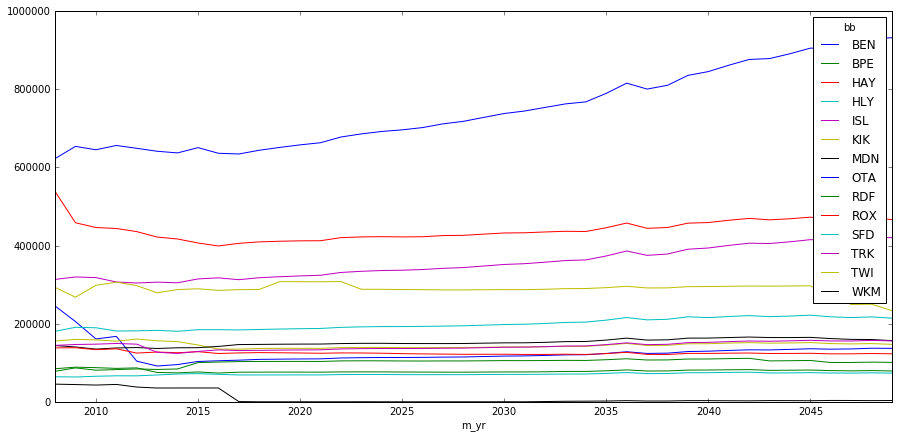

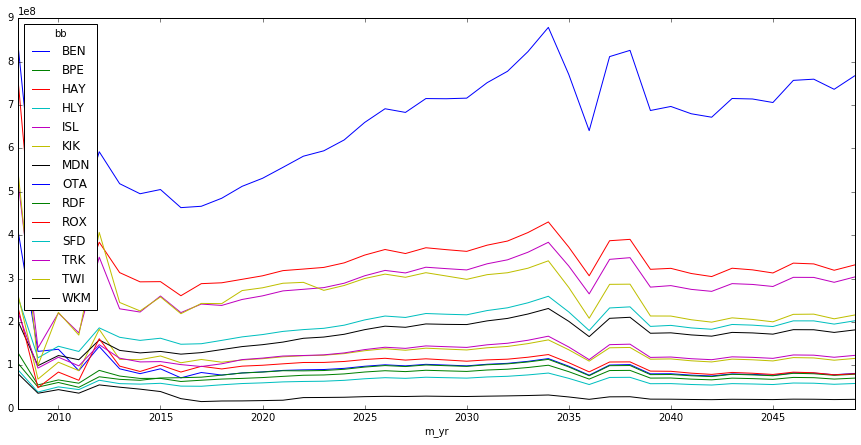

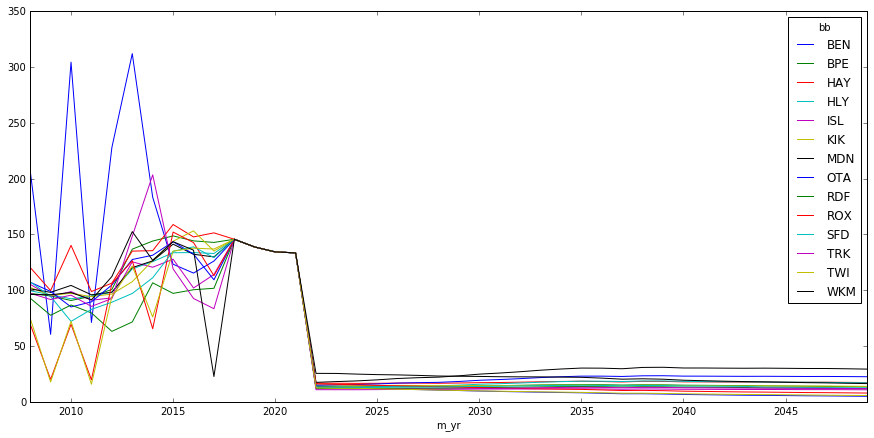

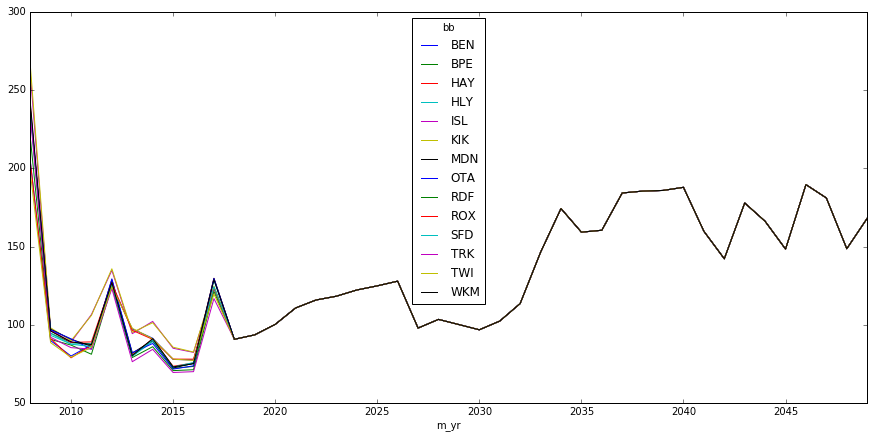

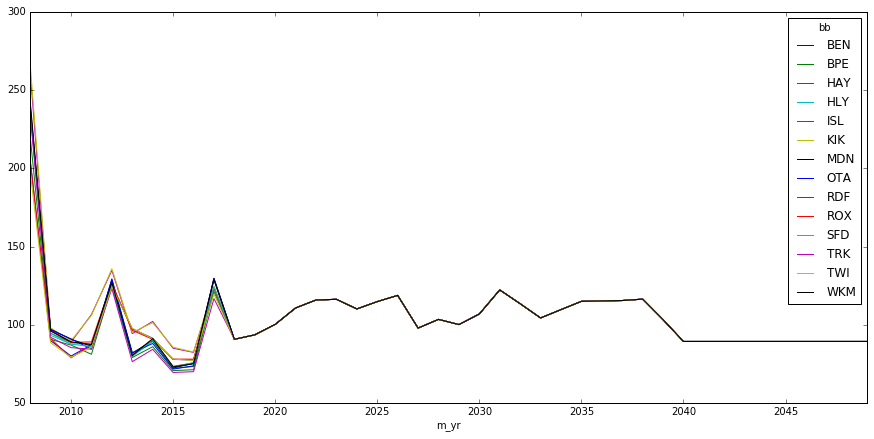

In [42]:
#Other - transformed input data
tp_rev.to_csv(out_fn+"tp_revenue.csv")

# Check a plot of the data
fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['pk_q'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['exp_all'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['pk_i'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_aob.groupby(['m_yr','bb']).mean()['pk_pg'].unstack().plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,7))
df_rcpd.groupby(['m_yr','bb']).mean()['pk_pg'].unstack().plot(ax=ax)